# EAD

In [2]:
import datetime
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings("ignore")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(context='talk', style='whitegrid', palette='deep')
plt.rcParams['figure.figsize'] = 12, 8
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 25
plt.rcParams['figure.titlesize'] = 32
plt.rcParams['axes.titlesize'] = 32
plt.rcParams['savefig.format'] = 'pdf'
plt.rcParams['figure.autolayout'] = 'true'
plt.rcParams['figure.frameon'] = 'false'
plt.rcParams['axes.spines.left'] = 'false'
plt.rcParams['axes.spines.right'] = 'false'
plt.rcParams['axes.spines.top'] = 'false'
plt.rcParams['legend.fancybox'] = 'false'
plt.rcParams['axes.spines.bottom'] = 'false'
plt.rcParams['font.size'] = 20
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# для графиков, где надо много цветов, юзайте воть:
sns.set_palette(sns.color_palette('deep'))
# а по дефолту воть:
sns.set_palette(sns.color_palette("BuGn_r", n_colors=10)[2::3])
pd.set_option('display.max_columns', 60)

In [3]:
feeding_details_22 = pd.read_csv("datasets/2022-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_22 = pd.read_csv("datasets/2022-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_23 = pd.read_csv("datasets/2023-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_23 = pd.read_csv("datasets/2023-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_24 = pd.read_csv("datasets/2024-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_24 = pd.read_csv("datasets/2024-feeding-tasks.csv", on_bad_lines="skip")

feeding_details_25 = pd.read_csv("datasets/2025-feeding-tasks-details.csv", on_bad_lines="skip")
feeding_25 = pd.read_csv("datasets/2025-feeding-tasks.csv", on_bad_lines="skip")

monthly_feeding = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Feeding")

herd_metrics = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Herd maintenance").replace("-", np.nan)
production_indicators = pd.read_excel("datasets/Ekoniva_dataset.xlsx", sheet_name="Dairy indicators").replace("-", np.nan)

In [4]:
def merge_tables() -> pd.DataFrame:
    """
    Merges all feeding dataframes with all details dataframes
    returns: merged dataframe
    rtype: pd.DataFrame
    """
    feeding_22["year"] = "2022"
    feeding_23["year"] = "2023"
    feeding_24["year"] = "2024"
    feeding_25["year"] = "2025"
    feeding_details_22["year"] = "2022"
    feeding_details_23["year"] = "2023"
    feeding_details_24["year"] = "2024"
    feeding_details_25["year"] = "2025"

    feeding_all = pd.concat([feeding_22, feeding_23, feeding_24, feeding_25], ignore_index=True)
    feeding_details_all = pd.concat([feeding_details_22, feeding_details_23, feeding_details_24, feeding_details_25], ignore_index=True)
    
    return feeding_all.merge(feeding_details_all, on=["FeedingTaskID", "SectionID", "year", "PhysiologicalGroupID", "PhysiologicalGroupName"], how="left"), feeding_all, feeding_details_all

In [5]:
feeding_and_details, feeding_all, feeding_details_all = merge_tables()


## Должно быть 16,411,365 строк

## Описание данных

- feeding-task - все описание кормления по фермам + секциям + группе животного
- detais - хз пока что чем отличаются details от просто feeding-task, мб тут как то поочередно загружаются ингредиенты, потом посмотрим еще
- monthly-feeding - тут название какого-то пресета кормления и распределение по времени на группу животных на конкретной ферме, пока что хз что за пресеты и где их найти
- herd-metrics - стадо, там тоже есть количество молока(это исследуемая переменная)
- production-indicators - ферма там количество коров разных типов, разделенных по группам и количество молока - или это исследуемая переменная(скорее всего)

> Тут будем действовать от того, как построим исследовательский вопрос, нужно понять как лучше исследовать, по ферме или по стаду, изначально мне кажется 2, поскольку больше переменных по которым можно смотреть переменную интереса
---

## Пример Исследовательских вопросов:
- Как какой-то тип питания (допустим разнообразное питание) влияет на аппетит и следовательно качество дойки коров? $\rightarrow$ Скорее всего придется группировать данные по питанию, жестко изучать, какие корма что означают, чтобы понять что означает разнообразное питание. Если тяжело, можно проанализировать добавки в пищу и их количество, понять как они влияют на аппетит и качество дойки.
- Можно попробовать сделать что то с заболеваниями коров, но насколько я понял, заболевших коров достаточно мало, это может быть безрезультативно. (я не склоняюсь к этому варианту)
- Как изменение количества основных ингредиентов в рационе отражается на аппетите и продуктивности дойных коров в разных физиологических группах? - что то интересное, тут 50/50, может полуиться, может  полностью ничего не найтись
> Итого я склоняюсь к 1 исследовательскому вопросу, он выглядит как наиболее возможный
---

## Распределения

In [6]:
production_indicators

date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
4    2022-12-01  Воронеж                 ЭНА Восток       МТФ   
...         ...      ...                        ...       ...   
1742 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1743 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1744 2025-07-01   Сибирь   Сибирская Нива Маслянино        РМ   
1745 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1746 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1           ЖК Бобров-2      2882.0     2591.0         131.0        2149.0   
2     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
3      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
4              МТФ ЭНАВ       799.0      738.0           8.0         507.0   
...                 ...         ...        ...           ...           ...   
1742          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1743        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1744        РМ Пеньково         0.0        0.0           0.0           0.0   
1745   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1746       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            261.0          50.0                    36.3           88816.0   
2            375.0           0.0                    38.3           98563.0   
3            163.0         162.0                    35.2           87647.0   
4              0.0         223.0                     NaN               NaN   
...            ...           ...                     ...               ...   
1742         288.0         556.0                    36.0          191276.0   
1743         559.0         286.0                    36.7          147218.0   
1744           0.0           0.0                     NaN               NaN   
1745        1027.0          57.0                    40.4          119264.0   
1746         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            68.0                   NaN                 NaN   
2            85.0                   NaN                 NaN   
3           153.0                   NaN                 NaN   
4            66.0                   NaN                 NaN   
...           ...                   ...                 ...   
1742        526.0                   0.0                14.0   
1743        189.0                  48.0                23.0   
1744          0.0                   NaN                 NaN   
1745        115.0                  21.0                18.0   
1746         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  
0                       NaN                 NaN              NaN      23.0  
1                       NaN                 NaN              NaN      18.0  
2                       NaN                 NaN              NaN       0.0  
3                       NaN                 NaN              NaN      26.0  
4                       NaN                 NaN              NaN       0.0  
...                     ...                 ...              ...       ...  
1742                   33.0                13.0             

In [7]:
production_indicators["weekly_milking_per_cow"].isna().sum() / production_indicators.shape[0]

np.float64(0.25701202060675443)

In [8]:
farm_milk = production_indicators[production_indicators["milk_cows"] > 0]
farm_milk

date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
4    2022-12-01  Воронеж                 ЭНА Восток       МТФ   
...         ...      ...                        ...       ...   
1741 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1742 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1743 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1745 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1746 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1           ЖК Бобров-2      2882.0     2591.0         131.0        2149.0   
2     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
3      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
4              МТФ ЭНАВ       799.0      738.0           8.0         507.0   
...                 ...         ...        ...           ...           ...   
1741         ЖК Борково      2561.0     2405.0           0.0        1946.0   
1742          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1743        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1745   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1746       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            261.0          50.0                    36.3           88816.0   
2            375.0           0.0                    38.3           98563.0   
3            163.0         162.0                    35.2           87647.0   
4              0.0         223.0                     NaN               NaN   
...            ...           ...                     ...               ...   
1741           0.0         459.0                    35.3           81682.0   
1742         288.0         556.0                    36.0          191276.0   
1743         559.0         286.0                    36.7          147218.0   
1745        1027.0          57.0                    40.4          119264.0   
1746         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            68.0                   NaN                 NaN   
2            85.0                   NaN                 NaN   
3           153.0                   NaN                 NaN   
4            66.0                   NaN                 NaN   
...           ...                   ...                 ...   
1741         97.0                   6.0                 5.0   
1742        526.0                   0.0                14.0   
1743        189.0                  48.0                23.0   
1745        115.0                  21.0                18.0   
1746         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  
0                       NaN                 NaN              NaN      23.0  
1                       NaN                 NaN              NaN      18.0  
2                       NaN                 NaN              NaN       0.0  
3                       NaN                 NaN              NaN      26.0  
4                       NaN                 NaN              NaN       0.0  
...                     ...                 ...              ...       ...  
1741                    5.0                15.0             

In [9]:
farm_milk["weekly_milking_per_cow"].isna().sum() / farm_milk.shape[0]

np.float64(0.1485148514851485)

In [10]:
farm_milk["farm_type"].value_counts()

farm_type
ЖК     1272
МТФ     197
РЖК      46
Name: count, dtype: int64

In [11]:
farm_milk[farm_milk["weekly_milking_per_cow"].isna()]["farm_type"].value_counts()

farm_type
МТФ    191
ЖК      31
РЖК      3
Name: count, dtype: int64

## Итого: почти все МТФ - NaN в количестве молока

<Axes: xlabel='weekly_milking_per_cow', ylabel='Count'>

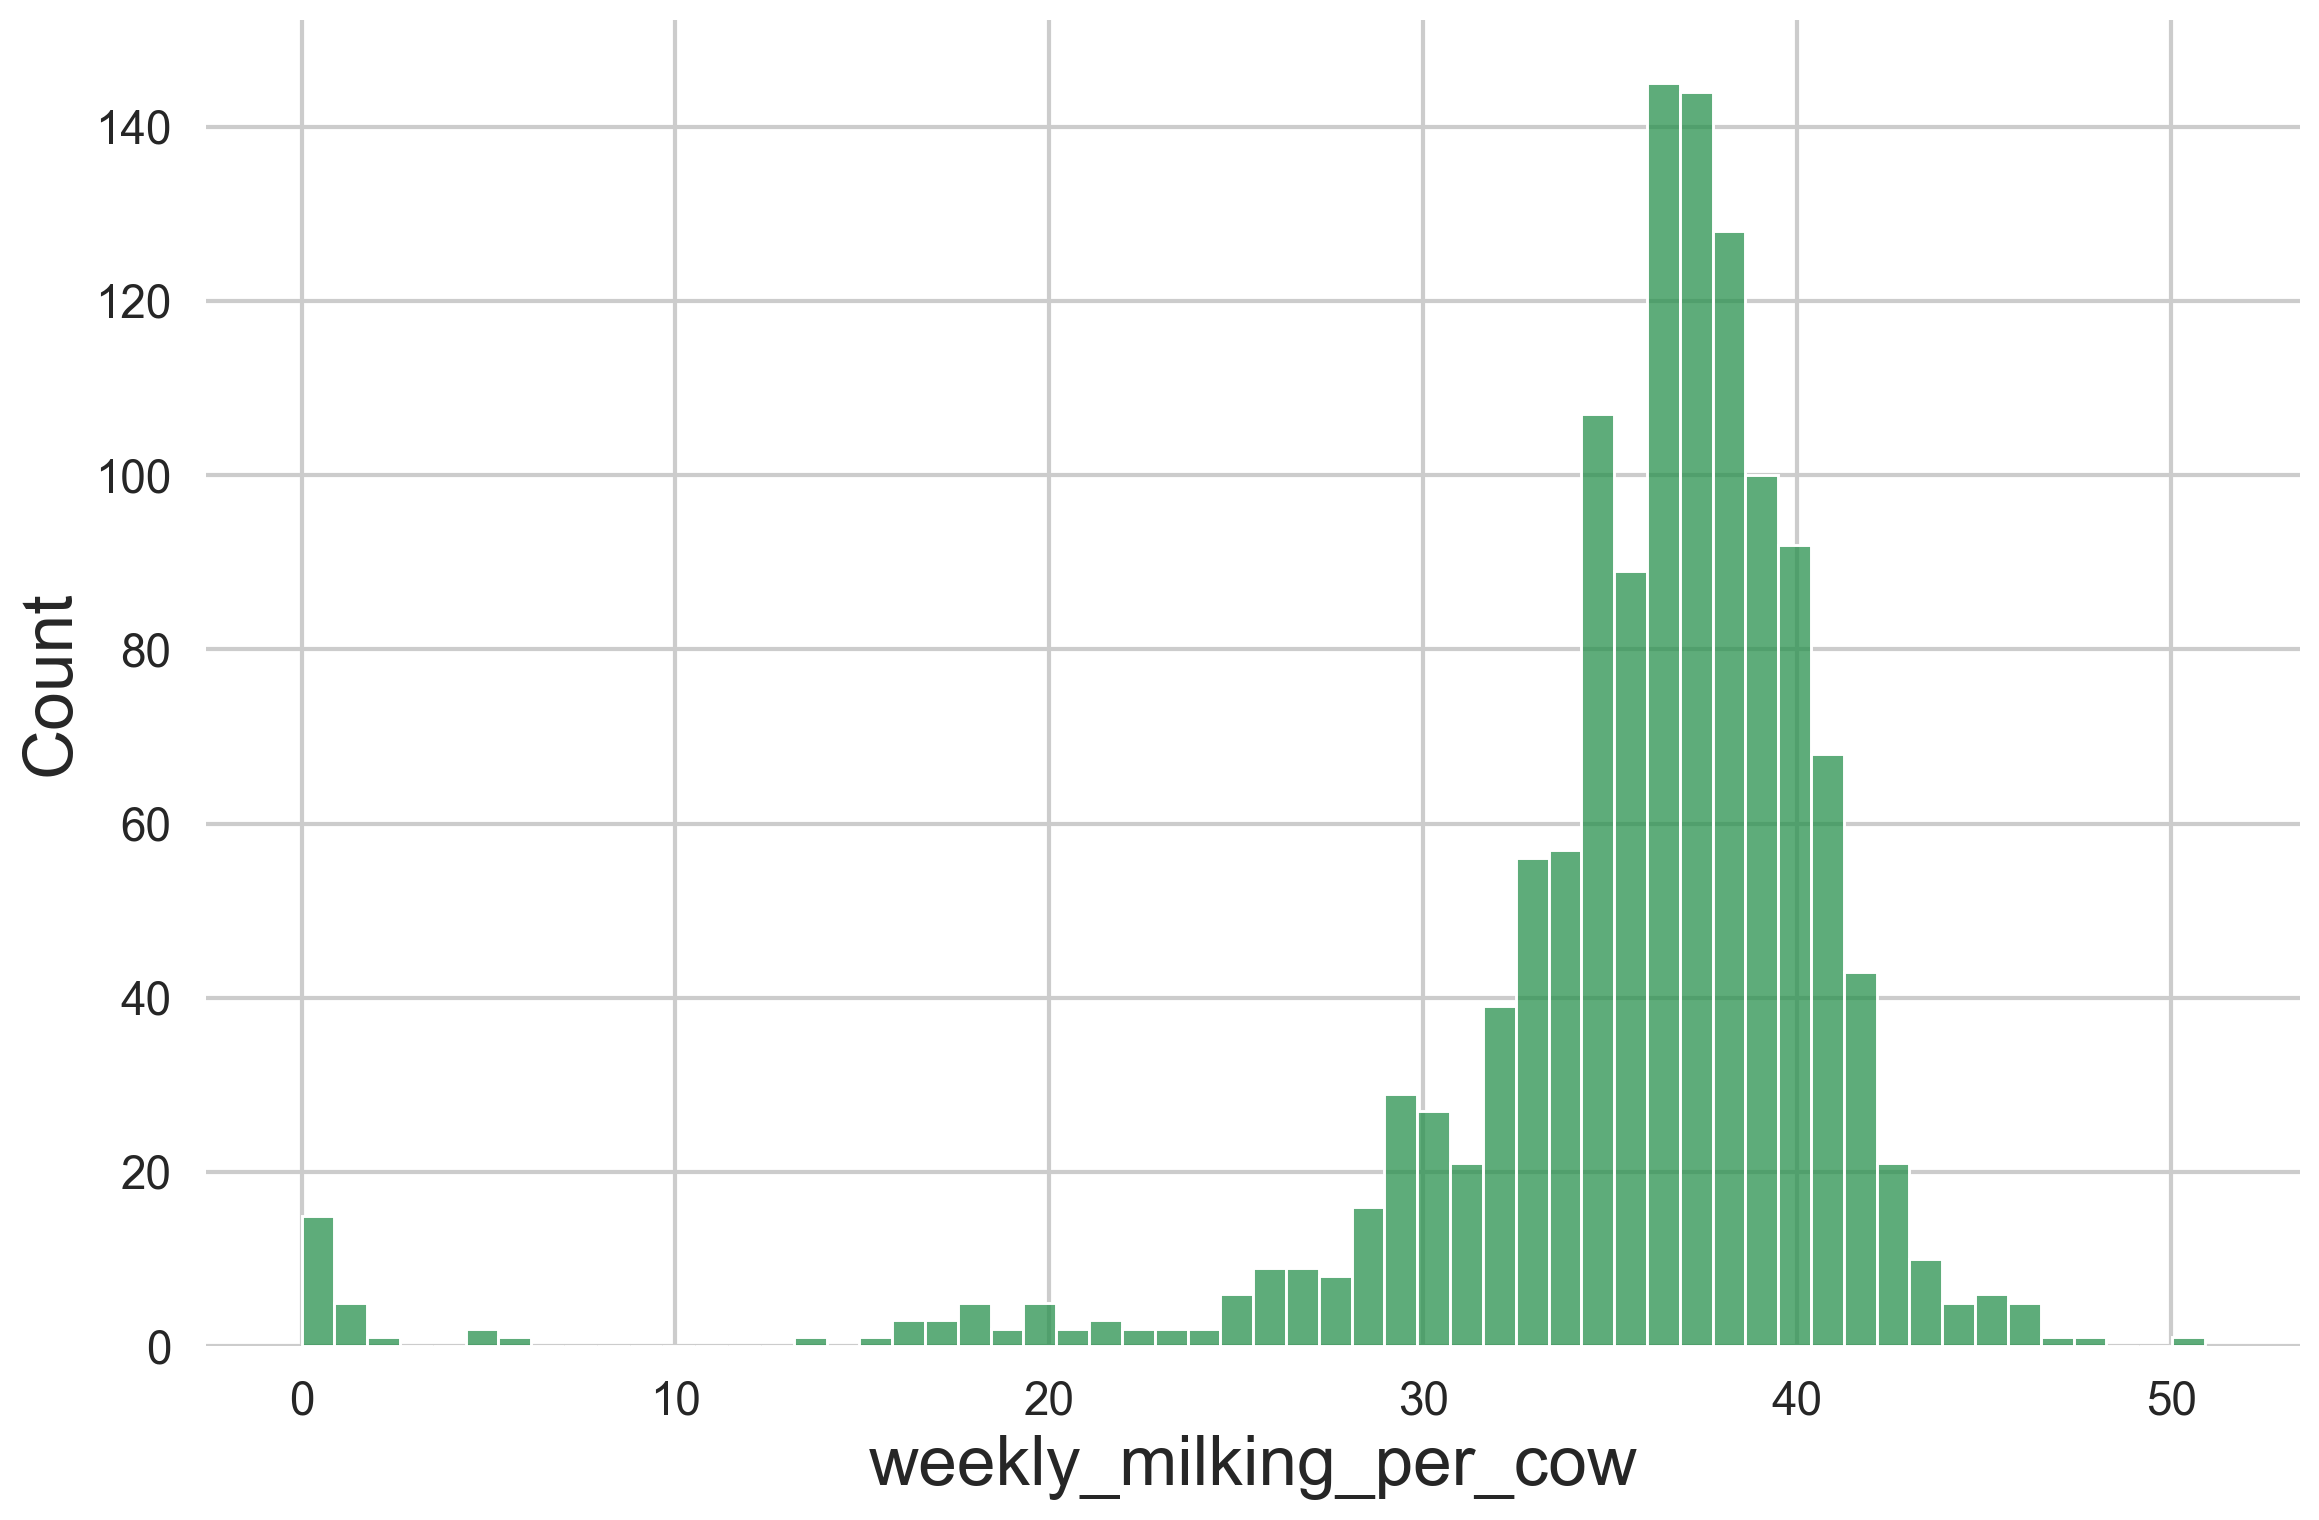

In [12]:
sns.histplot(production_indicators, x="weekly_milking_per_cow")

In [13]:
herd_milk = herd_metrics[herd_metrics["milk_cow"] > 0]
herd_milk


date   region             prod_farm_name farm_type  \
0    2020-01-01  Воронеж                 ЭНА Восток        ЖК   
1    2020-01-01  Воронеж                 ЭНА Восток        ЖК   
2    2020-01-01  Воронеж                 ЭНА Восток        ЖК   
3    2020-01-01  Воронеж                 ЭНА Восток        ЖК   
4    2020-01-01  Воронеж                 ЭНА Восток       МТФ   
...         ...      ...                        ...       ...   
4295 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
4296 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
4297 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
4299 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
4300 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  ls_capacity  ls_occupancy  forage_cow  milk_cow  \
0             ЖК Бобров       2800.0     95.535714      2675.0    2329.0   
1           ЖК Бобров-2       2800.0    101.678571      2847.0    2378.0   
2     ЖК Верхний Икорец       2800.0    101.071429      2830.0    2363.0   
3      ЖК Петропавловка       2800.0     59.321429      1661.0    1632.0   
4      МТФ Владимировка        467.0     37.473233       175.0     175.0   
...                 ...          ...           ...         ...       ...   
4295         ЖК Борково       2750.0     93.000000      2561.0    2405.0   
4296          ЖК Елбань       6200.0     95.000000      5882.0    5468.0   
4297        ЖК Пеньково       4700.0     99.000000      4666.0    4172.0   
4299   ЖК Огнева Заимка       3550.0    100.000000      3544.0    3141.0   
4300       ЖК Курочкино       3550.0     97.000000      3429.0    3189.0   

      dry_cow  milk_marketab_prc  forcow_milk_yeild  forcow_milk_yeild_stand  \
0       346.0               94.0                NaN                      NaN   
1       469.0               96.0                NaN                      NaN   
2       467.0               96.0                NaN                      NaN   
3        29.0               99.0                NaN                      NaN   
4         0.0               96.0                NaN                      NaN   
...       ...                ...                ...                      ...   
4295    156.0               97.0              33.78                     36.0   
4296    414.0               98.0              32.20                     33.9   
4297    494.0               95.0              30.11                     31.8   
4299    403.0               94.0              34.95                     36.0   
4300    240.0               98.0              36.40                     37.3   

      milk_fat  milk_protein  somatic_cells  bac_contam  cow_retired  \
0          NaN           NaN           92.0       41.00         52.0   
1          NaN           NaN           90.0       29.00         30.0   
2          NaN           NaN          161.0       72.00         52.0   
3          NaN           NaN           69.0        8.00         35.0   
4          NaN           NaN          259.0       58.00         17.0   
...        ...           ...            ...         ...          ...   
4295       4.0           3.4           96.0       33.00         97.0   
4296       3.9           3.4          102.5       39.36        526.0   
4297       3.9           3.4          114.0       46.00        189.0   
4299       3.8           3.3           91.0       38.00        115.0   
4300       3.7           3.4           75.0       30.00         76.0   

      cow_lame cow_mastits  calves  cow_metrit  ph_urine_avr  
0         90.0          57     NaN         NaN           NaN  
1         44.0          27     NaN         NaN           NaN  
2         57.0          77     NaN         NaN           NaN  
3        120.0          26     NaN         NaN           NaN  
4          2.0          10     NaN         NaN           NaN  
...        ...         ...     ...         ...           ...  
4295     102.0          48     NaN         NaN    

In [14]:
print(herd_metrics["forcow_milk_yeild"].isna().sum() / herd_metrics.shape[0], herd_metrics["forcow_milk_yeild_stand"].isna().sum() / herd_metrics.shape[0])

0.6168332945826552 0.6168332945826552


### Обновление: оказывается, достаточно много пропусков на объеме молока, в рамках стада - 60%, в рамках фермы - 25%, хз пока что что с этим делать, или забить, или исследовать аппетит

In [15]:
feeding_25

FeedingTaskID        Date  \
0       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
1       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
2       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
3       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
4       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
...                                                   ...         ...   
586831  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586832  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586833  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586834  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586835  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   

             FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0         ЖК Пеневичи           4         17                    14   
1         ЖК Пеневичи           6         10                    14   
2         ЖК Пеневичи           5         21                    14   
3       ЖК Бортниково           5         55                     5   
4       ЖК Бортниково           4         47                     5   
...               ...         ...        ...                   ...   
586831  ЖК Подболотье          16          1                     3   
586832  ЖК Подболотье          17         14                     7   
586833  ЖК Подболотье          18        139                     7   
586834  ЖК Подболотье          19        103                     7   
586835  ЖК Подболотье          20        131                     1   

       PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                          Д1                          275       1.0   
1                          Д1                          306       0.9   
2                          Д1                          260       1.0   
3                          Д1                          296       1.1   
4                          Д1                          293       1.0   
...                       ...                          ...       ...   
586831                     Д1                          139       1.1   
586832                     С1                           37       1.2   
586833                     С1                           37       1.3   
586834                     С1                           37       1.4   
586835                 Нетели                           32       1.2   

             RationName  RationPart  TotalWeight_kg  \
0                    Д1         0.8         11366.0   
1                    Д1         0.8         11075.0   
2                    Д1         1.0         11686.0   
3       Д1 (Лактация 1)         0.5          8997.0   
4       Д1 (Лактация 1)         0.5          8574.0   
...                 ...         ...             ...   
586831               Д1         0.6          5476.0   
586832               С1         1.0          1390.0   
586833               С1         1.0          1435.0   
586834               С1         1.0          1601.0   
586835               С1         1.0          1106.0   

                        CompletedAt  year  
0       2025-01-01T10:30:52.9959775  2025  
1       2025-01-01T09:18:28.5568200  2025  
2       2025-01-01T08:33:33.8061927  2025  
3       2025-01-01T10:23:00.0000000  2025  
4       2025-01-01T09:23:00.0000000  2025  
...                             ...   ...  
586831  2025-10-22T08:30:28.0916260  2025  
586832  2025-10-22T08:53:57.7488136  2025  
586833  2025-10-22T08:53:09.7102933  2025  
586834  2025-10-22T08:51:09.2068847  2025  
586835  2025-10-22T08:50:05.2368034  2025  

[586836 rows x 14 columns]

<Axes: xlabel='Appetite', ylabel='count'>

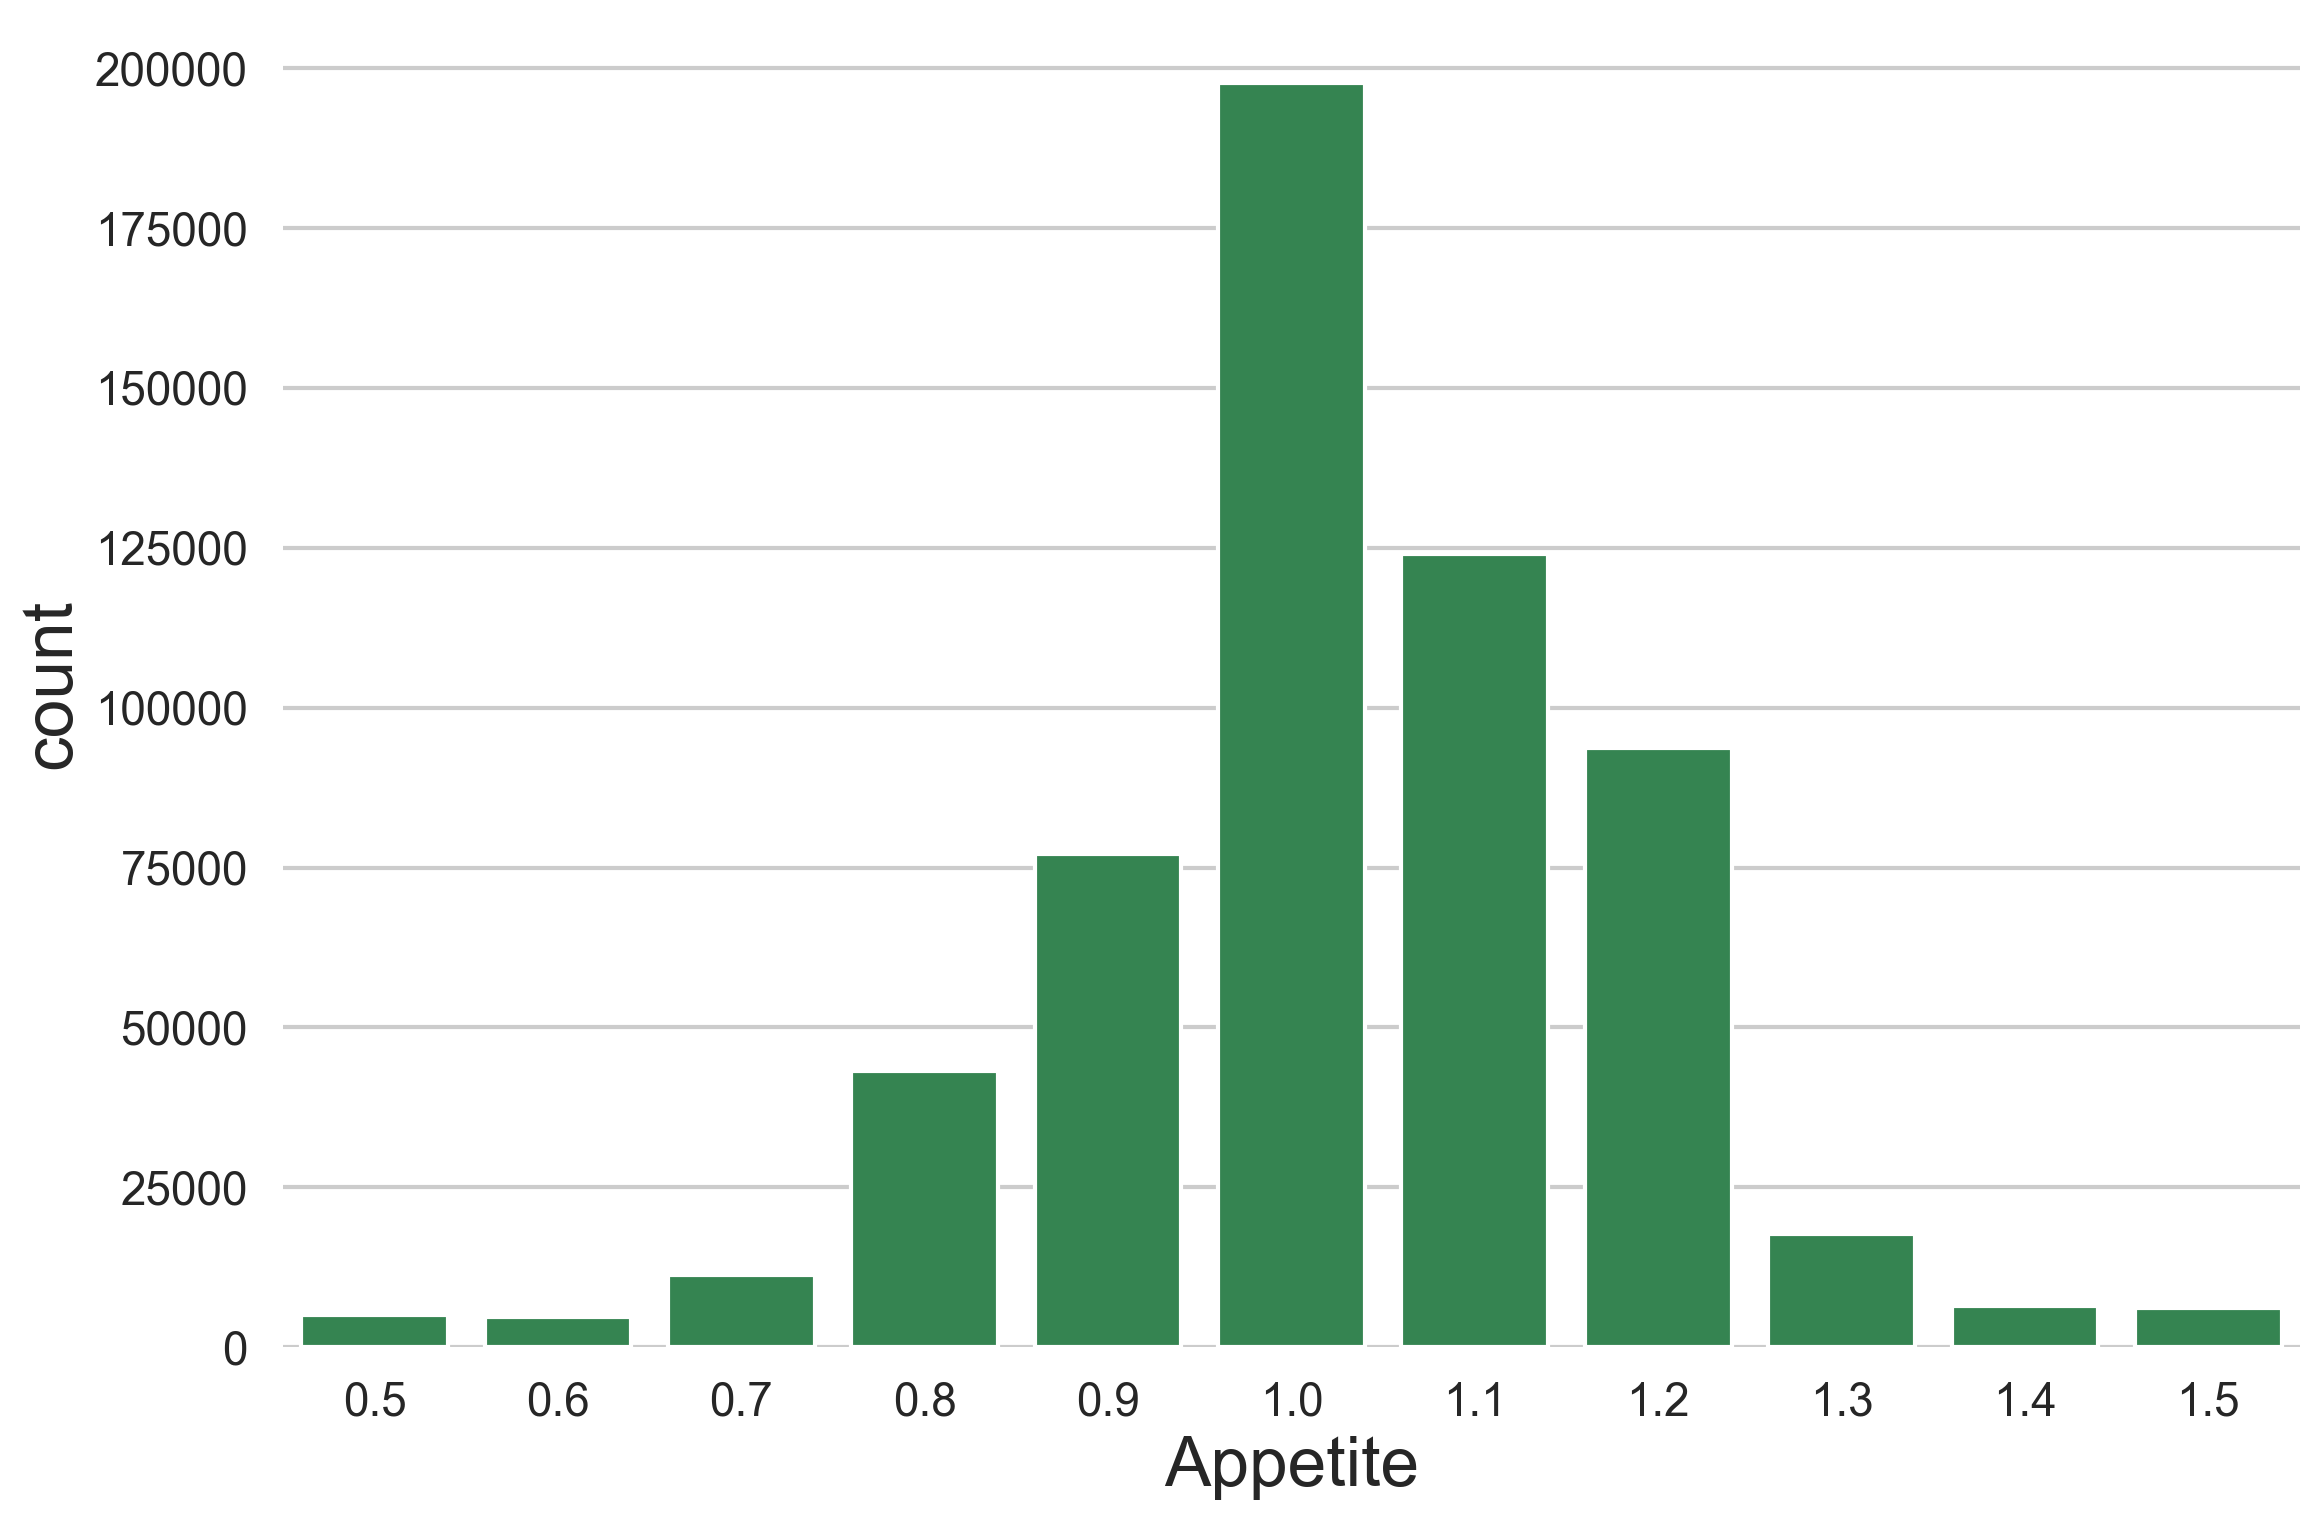

In [16]:
sns.countplot(feeding_25, x="Appetite")

In [17]:
feeding_25["Appetite"].isna().sum() / feeding_25.shape[0]

np.float64(0.0)

## Это хорошо, но все еще не понимаю как это связать

<Axes: xlabel='milk_marketab_prc', ylabel='Count'>

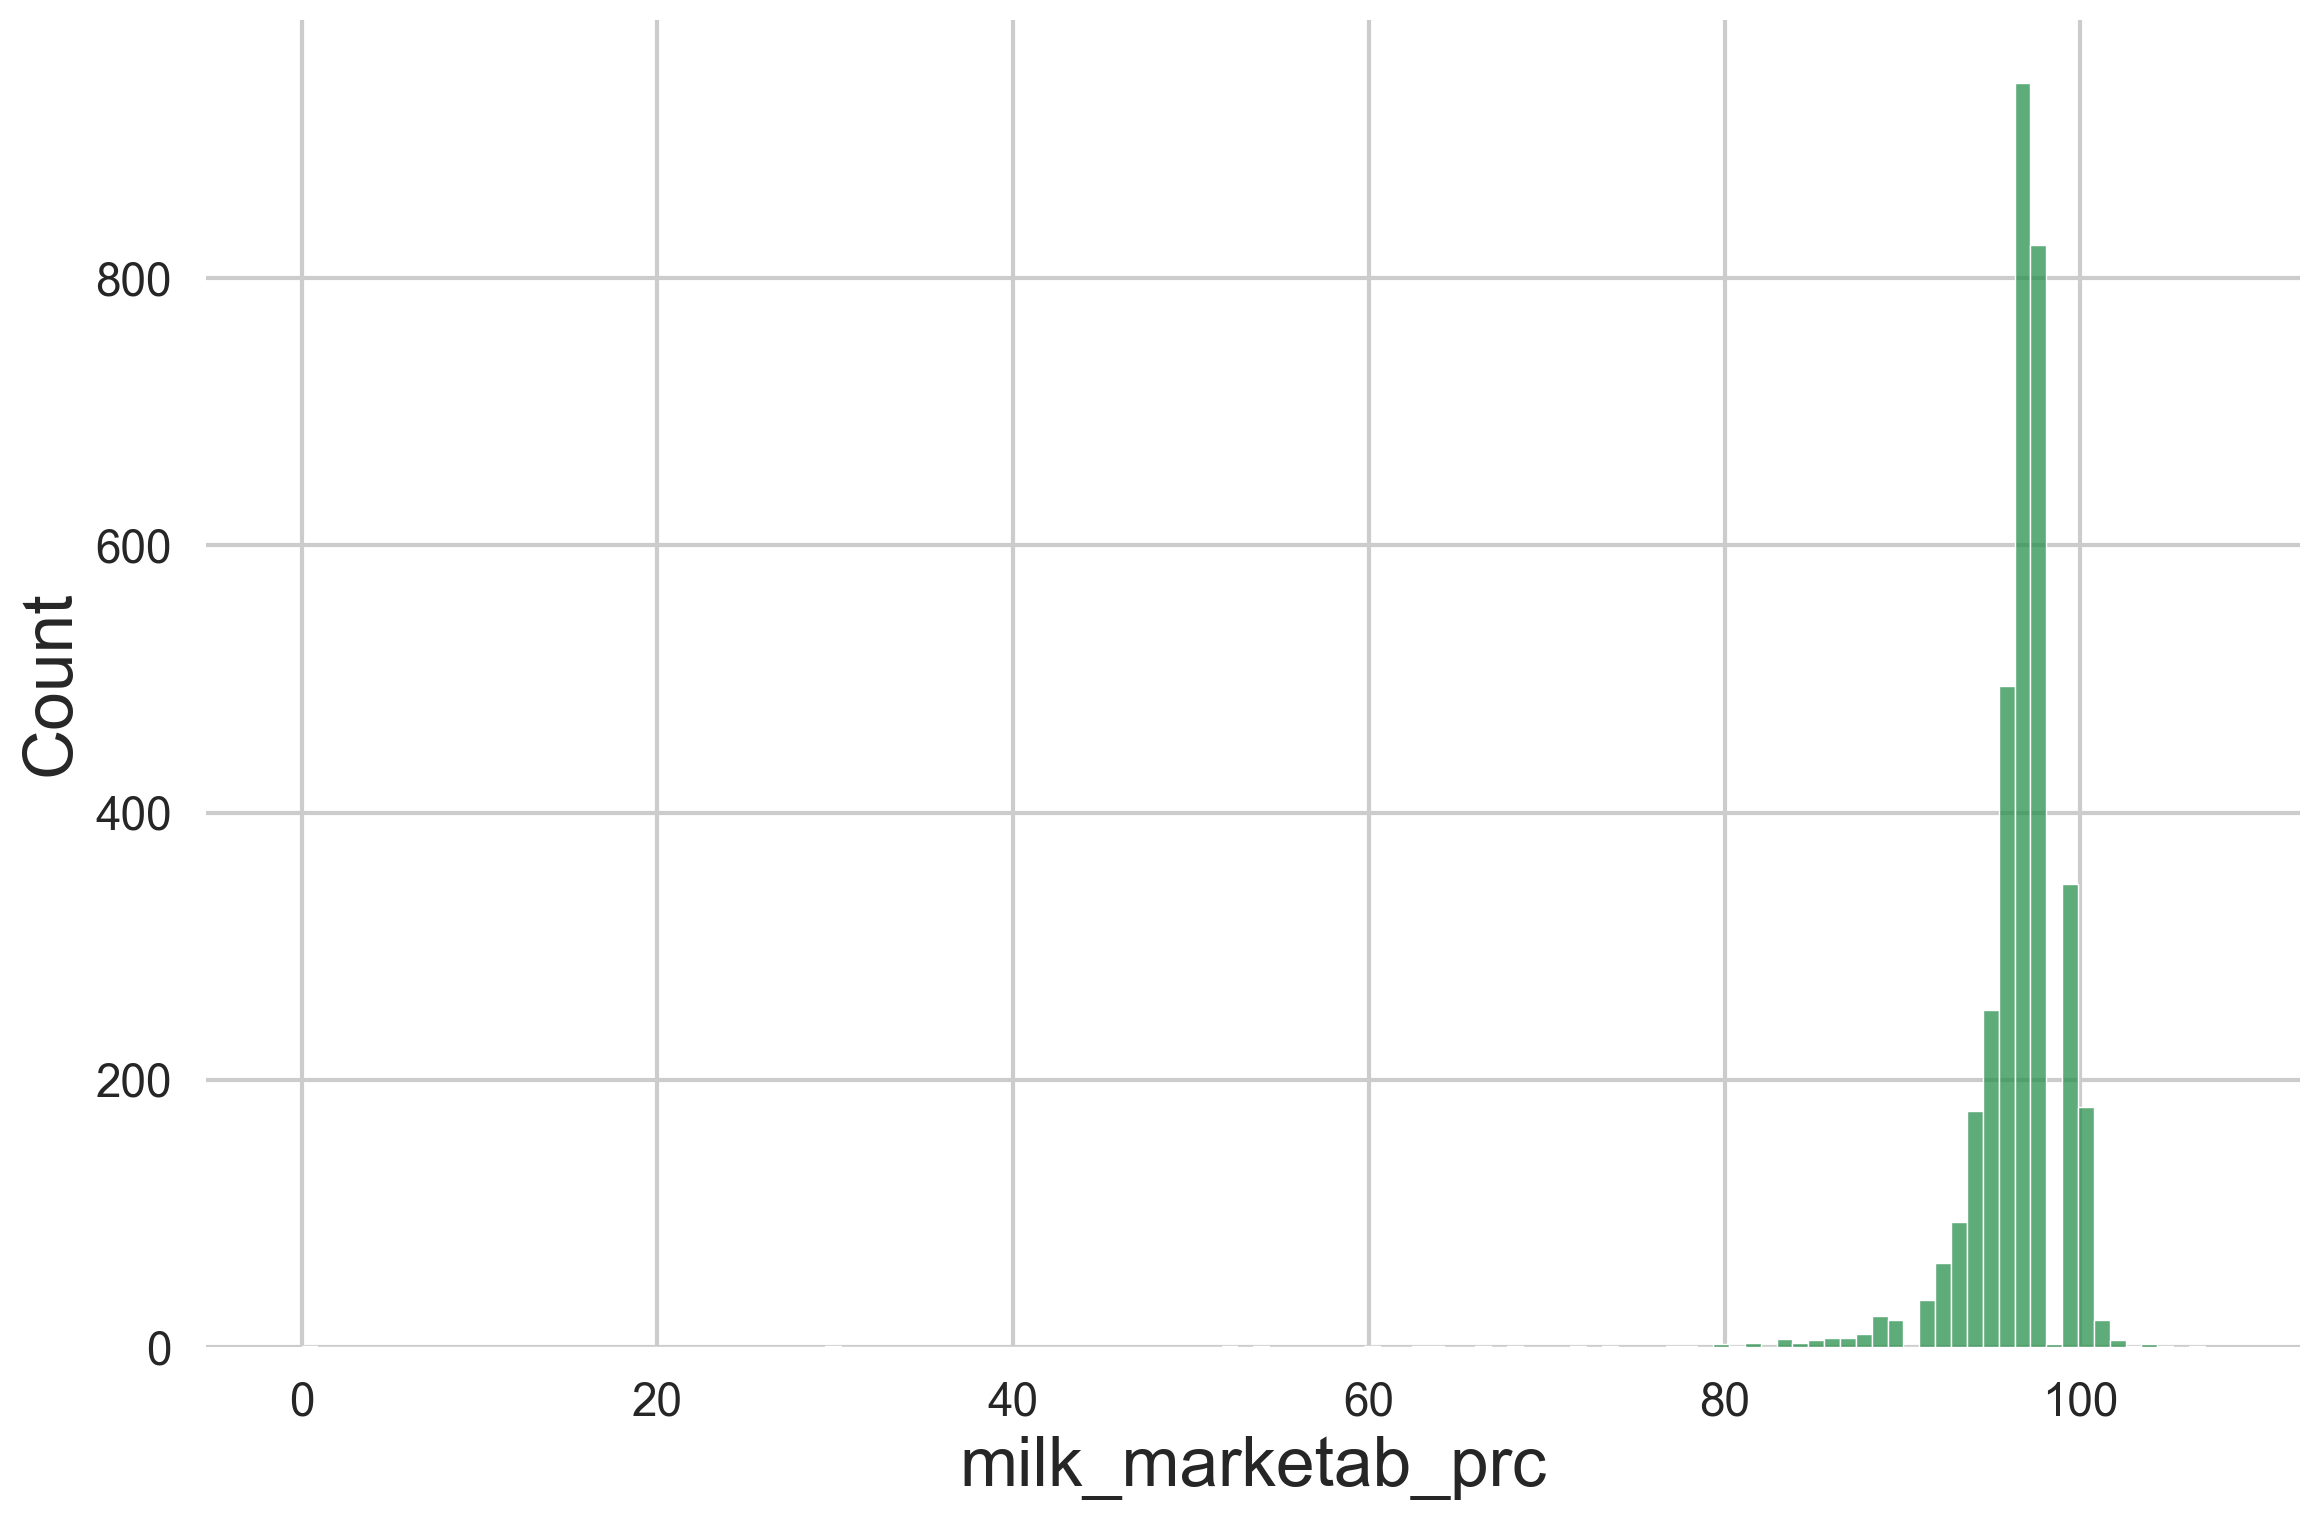

In [18]:
sns.histplot(herd_metrics, x="milk_marketab_prc")

In [19]:
feeding_25["RationName"].unique()

array(['Д1', 'Д1 (Лактация 1)', 'Н', 'T1', 'T2', 'Д3', 'С2', 'С2 нетели',
       'Д0', 'T4', 'Д2', 'Т3', 'Нетели', 'С2 Нетели', 'С1',
       'Т0 вне миксера', 'Н Нетели', 'д3 остатки', 'Т0 Б0 вне миксера',
       'Д1 КК11', 'Т2 6-8', 'Т0 ( Вне миксера )', 'Т0  0-2   вне миксера',
       'D1', 'Т3 Тлк 9-12', 'Т4 Тлк 13-20', 'Т2 Тлк 6-8', 'Т1 Тлк 3-5',
       'Нeтели', 'Т1 Комбикорм вне миксера', 'T0 вне миксера', 'C1',
       'НТ Нетели', 'Т3 9-12', 'Т1-2 3-8', 'D2', 'D0', 'Т0 (Вне миксера)',
       'Нетели вне миксера', 'ПД1', 'Нетели Загон', 'Д3 вне миксера',
       'Т 0 вне миксера', 'Т1 вне миксера', 'Б 0 вне миксера', 'Д1 КК 10',
       'Д1 кк11', 'Т1 3-5', 'Б-0 (вне миксера)', 'т-0 (вне миксера)',
       'Навес к/к(вне миксера)', 'Т4 13-20', 'д-1', 'д-3 (Вне миксера)',
       'Н (Нетели)', 'Т1 (вне миксера)', 'Б0 (вне миксера)',
       'Т0 (вне миксера)', 'нетели', 'Т4', 'Т1', 'Т2', 'T1 (Вне миксера)',
       'Т2 (6-8 мес)', 'Т1 (3-5 мес)', 'Т3 (9-12 мес)', 'Т4 (13-20 мес)',
     

In [20]:
monthly_feeding["feed_name"].unique()

array(['Биотек Микс', 'Добавка кормовая Бустер Милк',
       'Добавка кормовая Кальвобустер', 'Добавка кормовая Кальволит',
       'ЗЦМ "НЭОМИЛК"', 'ЗЦМ Евролак Turbo',
       'Комбикорм №4 КН Восток (покупной)',
       'Комбикорм гранула для телят "Престартер" (Каргилл)',
       'Комбикорм для телят (покупной)',
       'Комбикорм КК 62 для телят 0-3 мес', 'Молоко',
       'Молоко (Корма покупные)', 'Молоко сухое', 'Престартер (покупной)',
       'Провилит', 'Жом сухой', 'Комбикорм №3 КН Восток (покупной)',
       'Кукуруза фуражная (покупная) подработанная', 'Сенаж покупной',
       'Силос покупной', 'Шрот соевый', 'Актисаф HR+ (кормовая добавка)',
       'Глицерин кормовой', 'Дробленое зерно (кукуруза)',
       'Дробленое зерно (кукуруза) (покупное)',
       'Дробленое зерно (пшеница)', 'Дробленое зерно (ячмень)',
       'Дробленое зерно (ячмень) (покупное)',
       'Жир защищенный (Нутракор, Максимайзер, Оптима,Палмак)',
       'Жир растительный сухой ULTRA FEED F', 'Жмых рапсовый',

## Вопрос 1: Что за пресеты в monthly _feeding? это есть еще где-то?

In [21]:
display(feeding_25, feeding_details_25)

FeedingTaskID        Date  \
0       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
1       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
2       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
3       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
4       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
...                                                   ...         ...   
586831  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586832  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586833  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586834  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586835  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   

             FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0         ЖК Пеневичи           4         17                    14   
1         ЖК Пеневичи           6         10                    14   
2         ЖК Пеневичи           5         21                    14   
3       ЖК Бортниково           5         55                     5   
4       ЖК Бортниково           4         47                     5   
...               ...         ...        ...                   ...   
586831  ЖК Подболотье          16          1                     3   
586832  ЖК Подболотье          17         14                     7   
586833  ЖК Подболотье          18        139                     7   
586834  ЖК Подболотье          19        103                     7   
586835  ЖК Подболотье          20        131                     1   

       PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                          Д1                          275       1.0   
1                          Д1                          306       0.9   
2                          Д1                          260       1.0   
3                          Д1                          296       1.1   
4                          Д1                          293       1.0   
...                       ...                          ...       ...   
586831                     Д1                          139       1.1   
586832                     С1                           37       1.2   
586833                     С1                           37       1.3   
586834                     С1                           37       1.4   
586835                 Нетели                           32       1.2   

             RationName  RationPart  TotalWeight_kg  \
0                    Д1         0.8         11366.0   
1                    Д1         0.8         11075.0   
2                    Д1         1.0         11686.0   
3       Д1 (Лактация 1)         0.5          8997.0   
4       Д1 (Лактация 1)         0.5          8574.0   
...                 ...         ...             ...   
586831               Д1         0.6          5476.0   
586832               С1         1.0          1390.0   
586833               С1         1.0          1435.0   
586834               С1         1.0          1601.0   
586835               С1         1.0          1106.0   

                        CompletedAt  year  
0       2025-01-01T10:30:52.9959775  2025  
1       2025-01-01T09:18:28.5568200  2025  
2       2025-01-01T08:33:33.8061927  2025  
3       2025-01-01T10:23:00.0000000  2025  
4       2025-01-01T09:23:00.0000000  2025  
...                             ...   ...  
586831  2025-10-22T08:30:28.0916260  2025  
586832  2025-10-22T08:53:57.7488136  2025  
586833  2025-10-22T08:53:09.7102933  2025  
586834  2025-10-22T08:51:09.2068847  2025  
586835  2025-10-22T08:50:05.2368034  2025  

[586836 rows x 14 columns]

FeedingTaskID  SectionID  \
0        Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...         17   
1        Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...         17   
2        Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...         17   
3        Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...         17   
4        Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...         10   
...                                                    ...        ...   
4356426  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...        131   
4356427  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...        131   
4356428  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...        131   
4356429  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...        131   
4356430  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...        131   

         PhysiologicalGroupID PhysiologicalGroupName  IngredientID  \
0                          14                     Д1            57   
1                          14                     Д1           105   
2                          14                     Д1            96   
3                          14                     Д1             0   
4                          14                     Д1            57   
...                       ...                    ...           ...   
4356426                     1                 Нетели           119   
4356427                     1                 Нетели           335   
4356428                     1                 Нетели           331   
4356429                     1                 Нетели           143   
4356430                     1                 Нетели           298   

                 IngredientName  IngredientType  PhysicalWeight_kg  year  
0            5210.03.08.01.1.23          Forage           2415.000  2025  
1                 Карнаж (общ.)          Forage           1260.000  2025  
2            5210.07.05.02.1.24          Forage           3790.000  2025  
3                          Вода           Water            715.000  2025  
4            5210.03.08.01.1.23          Forage           2360.000  2025  
...                         ...             ...                ...   ...  
4356426           Солома (общ.)          Forage            120.643  2025  
4356427      6203.01.01.01.1.25          Forage            549.169  2025  
4356428  Жом свекловичный сухой     Concentrate             36.676  2025  
4356429   Премикс молодняк 6-24  VitaminMineral             10.049  2025  
4356430      6202.03.05.02.1.24          Forage            352.279  2025  

[4356431 rows x 9 columns]

In [22]:
feeding_and_details

FeedingTaskID        Date  \
0         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec...  2022-01-01   
1         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec...  2022-01-01   
2         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec...  2022-01-01   
3         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec...  2022-01-01   
4         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec...  2022-01-01   
...                                                     ...         ...   
16411360  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
16411361  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
16411362  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
16411363  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
16411364  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   

               FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0            ЖК Добрино          15          9                     2   
1            ЖК Добрино          15          9                     2   
2            ЖК Добрино          15          9                     2   
3            ЖК Добрино          15          9                     2   
4            ЖК Добрино          15          9                     2   
...                 ...         ...        ...                   ...   
16411360  ЖК Подболотье          20        131                     1   
16411361  ЖК Подболотье          20        131                     1   
16411362  ЖК Подболотье          20        131                     1   
16411363  ЖК Подболотье          20        131                     1   
16411364  ЖК Подболотье          20        131                     1   

         PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                            Д1                          352       0.9   
1                            Д1                          352       0.9   
2                            Д1                          352       0.9   
3                            Д1                          352       0.9   
4                            Д1                          352       0.9   
...                         ...                          ...       ...   
16411360                 Нетели                           32       1.2   
16411361                 Нетели                           32       1.2   
16411362                 Нетели                           32       1.2   
16411363                 Нетели                           32       1.2   
16411364                 Нетели                           32       1.2   

         RationName  RationPart  TotalWeight_kg                  CompletedAt  \
0                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
1                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
2                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
3                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
4                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
...             ...         ...             ...                          ...   
16411360         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411361         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411362         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411363         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411364         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   

          year  IngredientID          IngredientName  IngredientType  \
0         2022         125.0         Солома покупная          Forage   
1         2022         773.0      3645.01.01.01.1.20          Forage   
2         2022          72.0     Комбикорм 10 группы     Concentrate   
3         2022          82.0          Кукуруза сухая     Concentrate   
4         2022         129.0       Шрот подсолнечный     Concentrate  

## Еще 1 идея: как многоразовое питание влияет на продуктивность дойки
## Проверено на собственном опыте, ваще ботать не могу когда наемся сильно
## Гипотеза: Многоразовое питание помогает поддерживать большой уровень аппетита, и следовательно хорошие показатели молока

In [23]:
multy_feeding = feeding_and_details[feeding_and_details["RationPart"] < 1]
multy_feeding.shape[0] / feeding_and_details.shape[0]

0.5429236385882588

In [24]:
dff = feeding_and_details.groupby(["FeedingTaskID", "SectionID", "year", "PhysiologicalGroupID", "PhysiologicalGroupName"]).agg({"RationPart": "count"}).reset_index()
dff

FeedingTaskID  SectionID  year  \
0        Farms/EkoNiva1C.00ee2c4a-61ae-11e9-bbb2-b88303...         10  2024   
1        Farms/EkoNiva1C.00ee2c4a-61ae-11e9-bbb2-b88303...         17  2025   
2        Farms/EkoNiva1C.00ee2c4a-61ae-11e9-bbb2-b88303...         17  2025   
3        Farms/EkoNiva1C.00ee2c4a-61ae-11e9-bbb2-b88303...          1  2025   
4        Farms/EkoNiva1C.00ee2c4a-61ae-11e9-bbb2-b88303...          1  2025   
...                                                    ...        ...   ...   
2155373  Farms/EkoNiva1C.f2d76c26-5705-11e2-9cc0-00155d...          8  2023   
2155374  Farms/EkoNiva1C.f2d76c26-5705-11e2-9cc0-00155d...          8  2023   
2155375  Farms/EkoNiva1C.f2d76c26-5705-11e2-9cc0-00155d...         13  2023   
2155376  Farms/EkoNiva1C.f2d76c26-5705-11e2-9cc0-00155d...         14  2023   
2155377  Farms/EkoNiva1C.f2d76c26-5705-11e2-9cc0-00155d...         41  2023   

         PhysiologicalGroupID PhysiologicalGroupName  RationPart  
0                          14                     Д1           7  
1                          12           Б4 (>1 года)           8  
2                          14                     Д1           8  
3                          12           Б4 (>1 года)           8  
4                          14                     Д1           8  
...                       ...                    ...         ...  
2155373                    31                 Нетели           6  
2155374                    34                     С2           6  
2155375                    37          Т2 (6-8 мес.)           7  
2155376                    37          Т2 (6-8 мес.)           7  
2155377                    37          Т2 (6-8 мес.)           7  

[2155378 rows x 6 columns]

In [25]:
feeding_25

FeedingTaskID        Date  \
0       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
1       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
2       Farms/EkoNiva1C.ab72db43-092c-11ef-bbf4-b88303...  2025-01-01   
3       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
4       Farms/EkoNiva1C.5c89de55-021f-11ea-bbbe-b88303...  2025-01-01   
...                                                   ...         ...   
586831  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586832  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586833  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586834  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   
586835  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec...  2025-10-22   

             FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0         ЖК Пеневичи           4         17                    14   
1         ЖК Пеневичи           6         10                    14   
2         ЖК Пеневичи           5         21                    14   
3       ЖК Бортниково           5         55                     5   
4       ЖК Бортниково           4         47                     5   
...               ...         ...        ...                   ...   
586831  ЖК Подболотье          16          1                     3   
586832  ЖК Подболотье          17         14                     7   
586833  ЖК Подболотье          18        139                     7   
586834  ЖК Подболотье          19        103                     7   
586835  ЖК Подболотье          20        131                     1   

       PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                          Д1                          275       1.0   
1                          Д1                          306       0.9   
2                          Д1                          260       1.0   
3                          Д1                          296       1.1   
4                          Д1                          293       1.0   
...                       ...                          ...       ...   
586831                     Д1                          139       1.1   
586832                     С1                           37       1.2   
586833                     С1                           37       1.3   
586834                     С1                           37       1.4   
586835                 Нетели                           32       1.2   

             RationName  RationPart  TotalWeight_kg  \
0                    Д1         0.8         11366.0   
1                    Д1         0.8         11075.0   
2                    Д1         1.0         11686.0   
3       Д1 (Лактация 1)         0.5          8997.0   
4       Д1 (Лактация 1)         0.5          8574.0   
...                 ...         ...             ...   
586831               Д1         0.6          5476.0   
586832               С1         1.0          1390.0   
586833               С1         1.0          1435.0   
586834               С1         1.0          1601.0   
586835               С1         1.0          1106.0   

                        CompletedAt  year  
0       2025-01-01T10:30:52.9959775  2025  
1       2025-01-01T09:18:28.5568200  2025  
2       2025-01-01T08:33:33.8061927  2025  
3       2025-01-01T10:23:00.0000000  2025  
4       2025-01-01T09:23:00.0000000  2025  
...                             ...   ...  
586831  2025-10-22T08:30:28.0916260  2025  
586832  2025-10-22T08:53:57.7488136  2025  
586833  2025-10-22T08:53:09.7102933  2025  
586834  2025-10-22T08:51:09.2068847  2025  
586835  2025-10-22T08:50:05.2368034  2025  

[586836 rows x 14 columns]

In [26]:
df = feeding_25.groupby(["Date", "FarmName", "SectionID", "PhysiologicalGroupID", "PhysiologicalGroupName"]).agg({"RationPart": "sum"}).reset_index()
df[df["RationPart"] > 1].shape[0] / df.shape[0]

0.17870390277573467

### Здесь честно непонятно, если группировать по дате, ферме, секции и группе, то все равно не все наблюдения получают часть рациона 1, тут возможно я не так что то сделал, но идея интересная, если попытаться докрутить, то мб что-нибудь может получиться

### Возможно, это из за того, что существуют поврежденные данные, но это не поможет, потому что накапливается доля тех, что больше 1

### Интересно пощупать болезни коров, например, можно посмотреть на мастит, это очень распространенное заболевание среди коров, например можно понять связь аппетита с заболеваниями, гипотеза: когда аппетит падает, скоро может быть всплеск заболеваний, это можно отслеживать и предугадывать заболевания, после делать профилактику от заболеваний и получать гораздо больше прибыли

### Однако, это может быть спорно, потому что предсказывать заболевания - работа МЛщиков, и может быть невозможно придумать альт механизм

 14. Поиск “ферм-чемпионов” в каждой группе.

 • Для каждой физиогруппы (Д0, Д1, Д2, Д3, сухостой) и региона:
 • найти топ-фермы по удою, качеству молока и здоровью,
 • описать, чем они отличаются по:
 • структуре рациона,
 • аппетиту,
 • частоте и времени кормлений,
 • плотности посадки.
 • Бизнес: программа “тиражирования лучших практик” внутри холдинга

In [27]:
feeding_all = pd.concat([feeding_22, feeding_23, feeding_24, feeding_25], ignore_index=True)

In [28]:
feeding_all["Date"] = pd.to_datetime(feeding_all["Date"])

Date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж            ЭНА Левый берег        ЖК   
4    2022-12-01  Воронеж            ЭНА Левый берег        ЖК   
...         ...      ...                        ...       ...   
1233 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1234 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1235 2025-07-01   Сибирь   Сибирская Нива Маслянино        РМ   
1236 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1237 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

               FarmName  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
2      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
3           ЖК Бодеевка      2875.0     2548.0         112.0        2078.0   
4            ЖК Высокое      2777.0     2508.0         146.0        1835.0   
...                 ...         ...        ...           ...           ...   
1233          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1234        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1235        РМ Пеньково         0.0        0.0           0.0           0.0   
1236   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1237       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            375.0           0.0                    38.3           98563.0   
2            163.0         162.0                    35.2           87647.0   
3              0.0         358.0                    32.9           83916.0   
4            322.0         205.0                    34.2           84962.0   
...            ...           ...                     ...               ...   
1233         288.0         556.0                    36.0          191276.0   
1234         559.0         286.0                    36.7          147218.0   
1235           0.0           0.0                     NaN               NaN   
1236        1027.0          57.0                    40.4          119264.0   
1237         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            85.0                   NaN                 NaN   
2           153.0                   NaN                 NaN   
3            55.0                   NaN                 NaN   
4             0.0                   NaN                 NaN   
...           ...                   ...                 ...   
1233        526.0                   0.0                14.0   
1234        189.0                  48.0                23.0   
1235          0.0                   NaN                 NaN   
1236        115.0                  21.0                18.0   
1237         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  \
0                       NaN                 NaN              NaN      23.0   
1                       NaN                 NaN              NaN       0.0   
2                       NaN                 NaN              NaN      26.0   
3                       NaN                 NaN              NaN      33.0   
4                       NaN                 NaN              NaN      21.0   
...                     ...                 ...              ...       ...   
1233                   33.0                13.0      

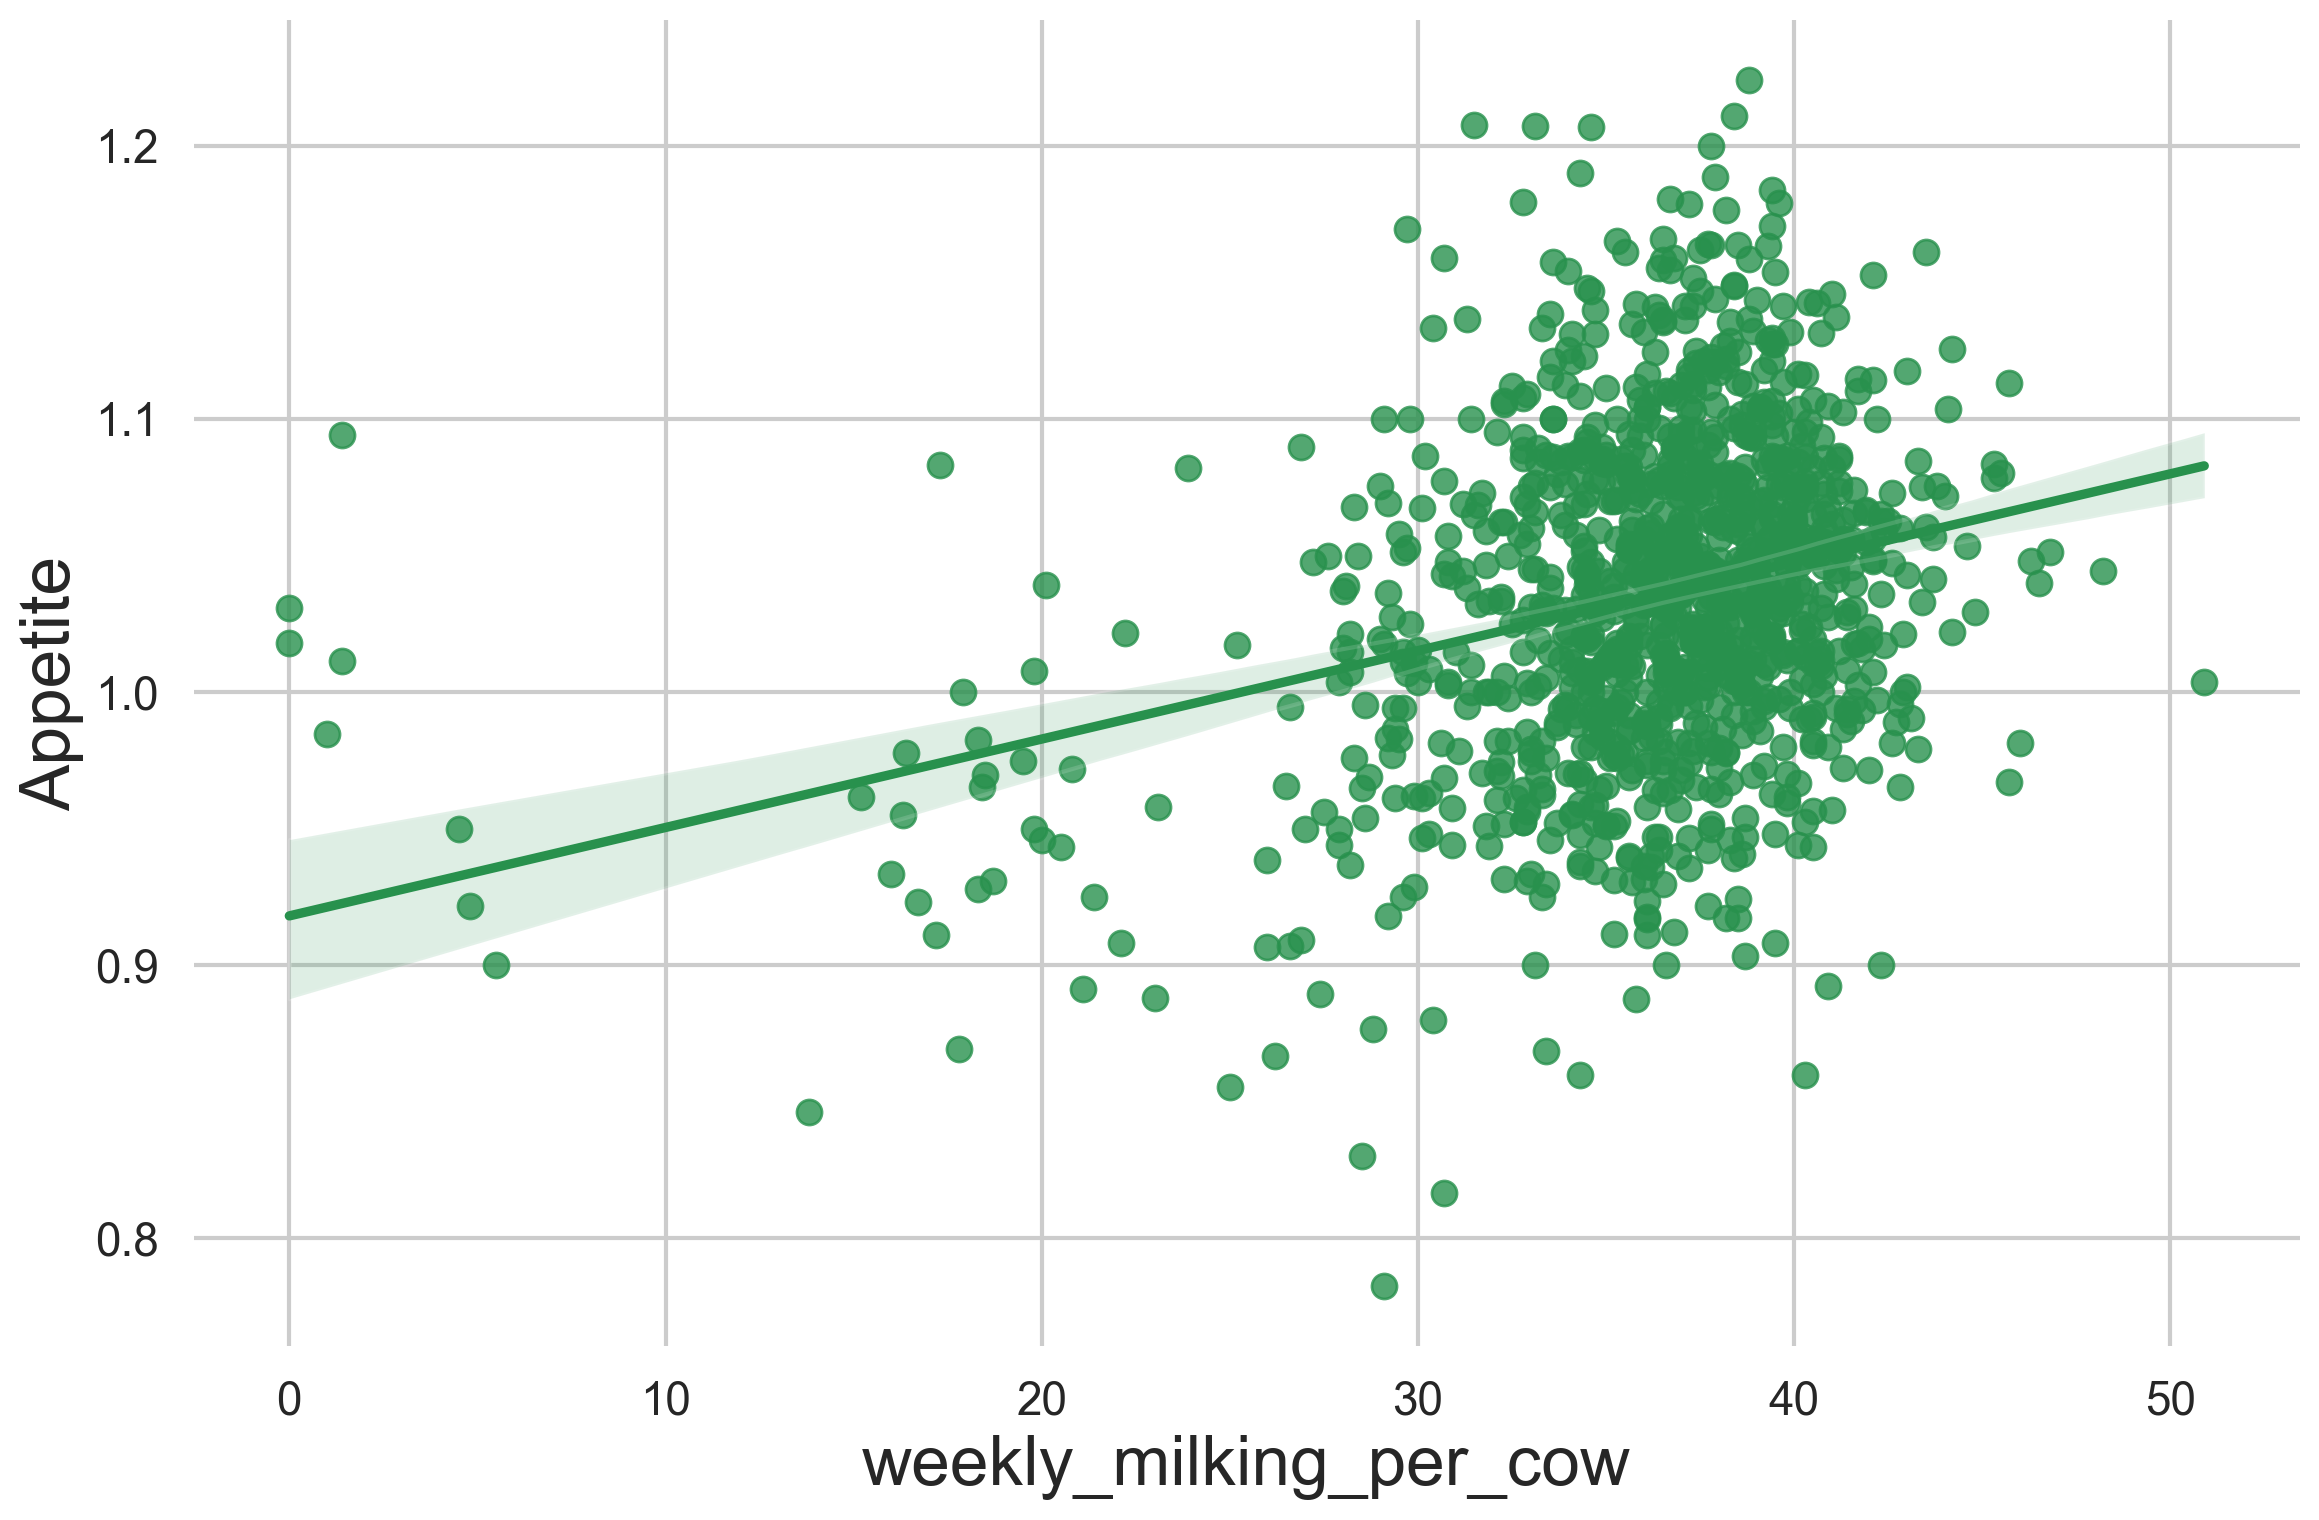

In [29]:
dff = feeding_all.groupby(["Date", "FarmName"]).agg({"Appetite": "mean"}).reset_index()

dfr = production_indicators.rename(columns={"date": "Date", "farm_name": "FarmName"}).merge(dff, on=["Date", "FarmName"], how="inner")

sns.regplot(dfr, x="weekly_milking_per_cow", y="Appetite")
dfr


In [30]:
production_indicators

date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
4    2022-12-01  Воронеж                 ЭНА Восток       МТФ   
...         ...      ...                        ...       ...   
1742 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1743 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1744 2025-07-01   Сибирь   Сибирская Нива Маслянино        РМ   
1745 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1746 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1           ЖК Бобров-2      2882.0     2591.0         131.0        2149.0   
2     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
3      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
4              МТФ ЭНАВ       799.0      738.0           8.0         507.0   
...                 ...         ...        ...           ...           ...   
1742          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1743        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1744        РМ Пеньково         0.0        0.0           0.0           0.0   
1745   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1746       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            261.0          50.0                    36.3           88816.0   
2            375.0           0.0                    38.3           98563.0   
3            163.0         162.0                    35.2           87647.0   
4              0.0         223.0                     NaN               NaN   
...            ...           ...                     ...               ...   
1742         288.0         556.0                    36.0          191276.0   
1743         559.0         286.0                    36.7          147218.0   
1744           0.0           0.0                     NaN               NaN   
1745        1027.0          57.0                    40.4          119264.0   
1746         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            68.0                   NaN                 NaN   
2            85.0                   NaN                 NaN   
3           153.0                   NaN                 NaN   
4            66.0                   NaN                 NaN   
...           ...                   ...                 ...   
1742        526.0                   0.0                14.0   
1743        189.0                  48.0                23.0   
1744          0.0                   NaN                 NaN   
1745        115.0                  21.0                18.0   
1746         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  
0                       NaN                 NaN              NaN      23.0  
1                       NaN                 NaN              NaN      18.0  
2                       NaN                 NaN              NaN       0.0  
3                       NaN                 NaN              NaN      26.0  
4                       NaN                 NaN              NaN       0.0  
...                     ...                 ...              ...       ...  
1742                   33.0                13.0             

1. Посмотреть распределение аппетита от разнообразия ингридиентов/количества добавок

1. Посмотреть распределения с маститом
1. Понять сам что лучше
1. Написать Глебу, спросить что лучше

In [31]:
milking_groups = {'Д1', 'Д2', 'Д0 (Новотельные)', 'Д3 (Предзапуск)', 'D3', 'Д3', 'Д0', 'Д-3'}
feeding_and_details["Date"] = pd.to_datetime(feeding_and_details["Date"])
dff = feeding_and_details[feeding_and_details["PhysiologicalGroupName"].isin(milking_groups)]
dfc = (
    dff.groupby(["FarmName", "Date"])
    .agg(
        Appetite=("Appetite", "first"),
        TotalWeight=("PhysicalWeight_kg", "sum"),
        ConcentrateWeight=("PhysicalWeight_kg",
                           lambda x: x.where(dff.loc[x.index, "IngredientType"] == "Concentrate").sum())
    )
    .assign(
        Доля_Concentrate_по_весу=lambda df: df["ConcentrateWeight"] / df["TotalWeight"]
    )
    .reset_index()
)
milk_protein = production_indicators.rename(columns={"date": "Date", "farm_name": "FarmName"}).merge(dfc, on=["Date", "FarmName"], how="inner")


In [32]:
milk_protein

Date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж            ЭНА Левый берег        ЖК   
4    2022-12-01  Воронеж            ЭНА Левый берег        ЖК   
...         ...      ...                        ...       ...   
1172 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1173 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1174 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1175 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1176 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

               FarmName  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
2      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
3           ЖК Бодеевка      2875.0     2548.0         112.0        2078.0   
4            ЖК Высокое      2777.0     2508.0         146.0        1835.0   
...                 ...         ...        ...           ...           ...   
1172         ЖК Борково      2561.0     2405.0           0.0        1946.0   
1173          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1174        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1175   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1176       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            375.0           0.0                    38.3           98563.0   
2            163.0         162.0                    35.2           87647.0   
3              0.0         358.0                    32.9           83916.0   
4            322.0         205.0                    34.2           84962.0   
...            ...           ...                     ...               ...   
1172           0.0         459.0                    35.3           81682.0   
1173         288.0         556.0                    36.0          191276.0   
1174         559.0         286.0                    36.7          147218.0   
1175        1027.0          57.0                    40.4          119264.0   
1176         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            85.0                   NaN                 NaN   
2           153.0                   NaN                 NaN   
3            55.0                   NaN                 NaN   
4             0.0                   NaN                 NaN   
...           ...                   ...                 ...   
1172         97.0                   6.0                 5.0   
1173        526.0                   0.0                14.0   
1174        189.0                  48.0                23.0   
1175        115.0                  21.0                18.0   
1176         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  \
0                       NaN                 NaN              NaN      23.0   
1                       NaN                 NaN              NaN       0.0   
2                       NaN                 NaN              NaN      26.0   
3                       NaN                 NaN              NaN      33.0   
4                       NaN                 NaN              NaN      21.0   
...                     ...                 ...              ...       ...   
1172                    5.0                15.0      

<Axes: xlabel='Доля_Concentrate_по_весу', ylabel='weekly_milking_per_cow'>

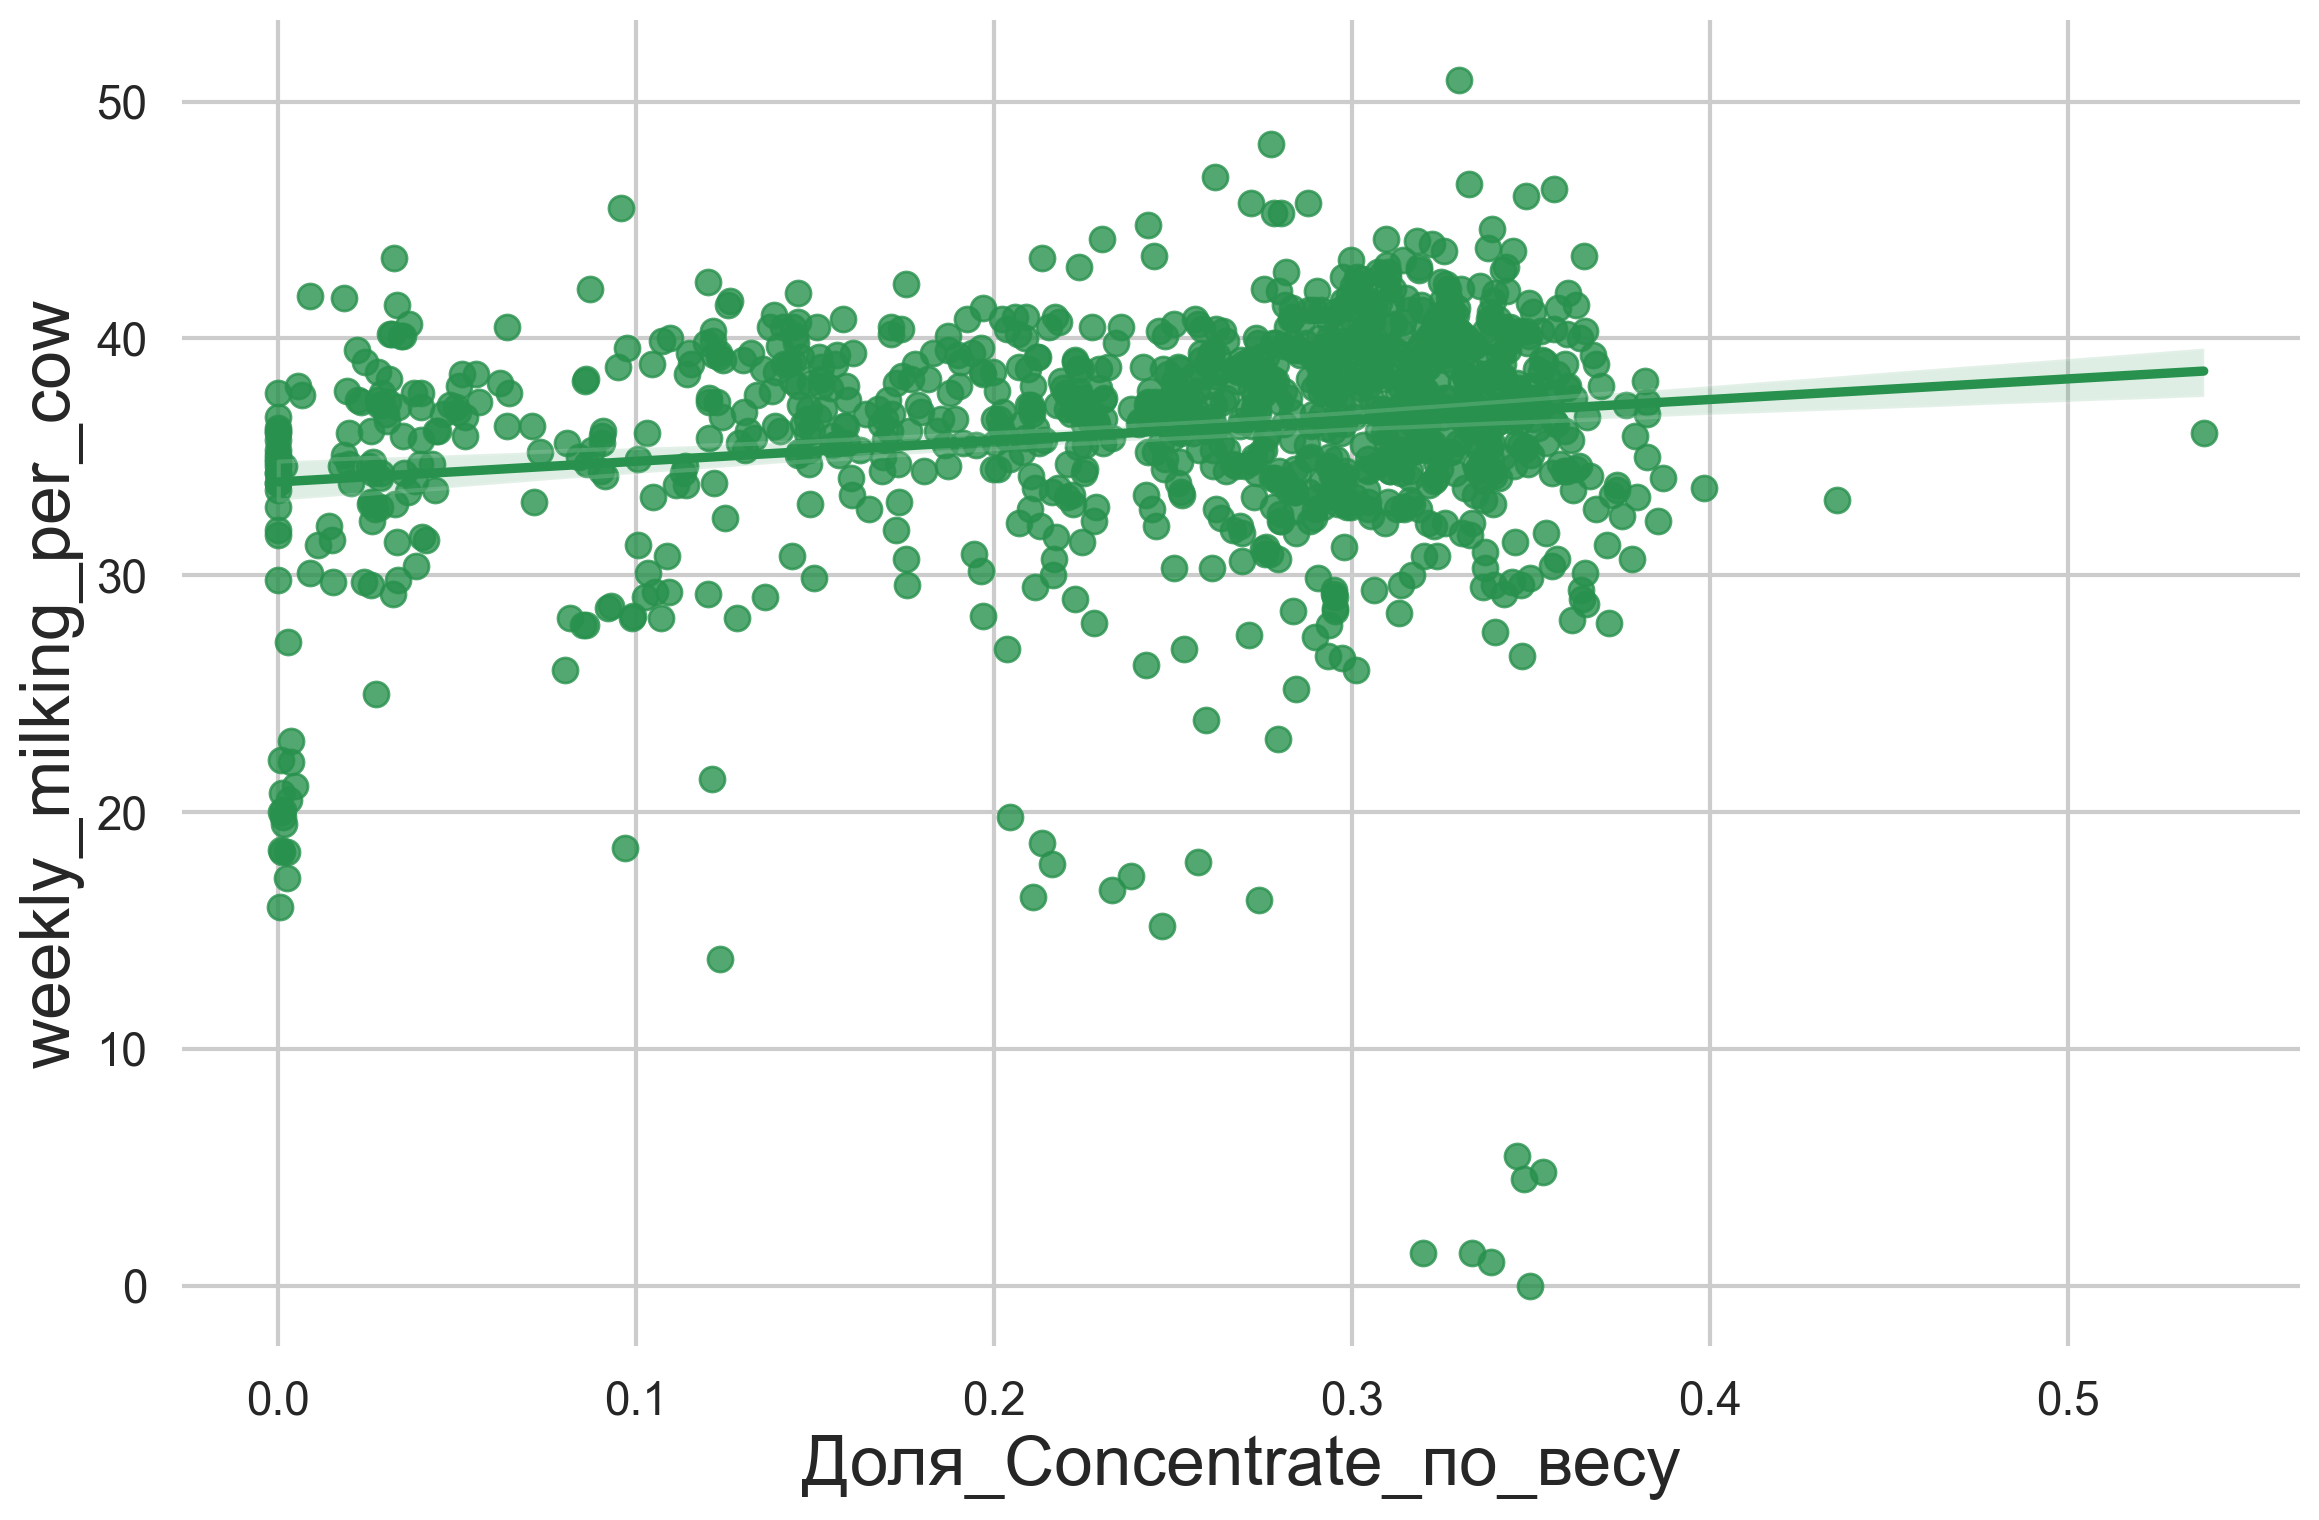

In [33]:
sns.regplot(milk_protein, x="Доля_Concentrate_по_весу", y="weekly_milking_per_cow")

<Axes: xlabel='Доля_Concentrate_по_весу'>

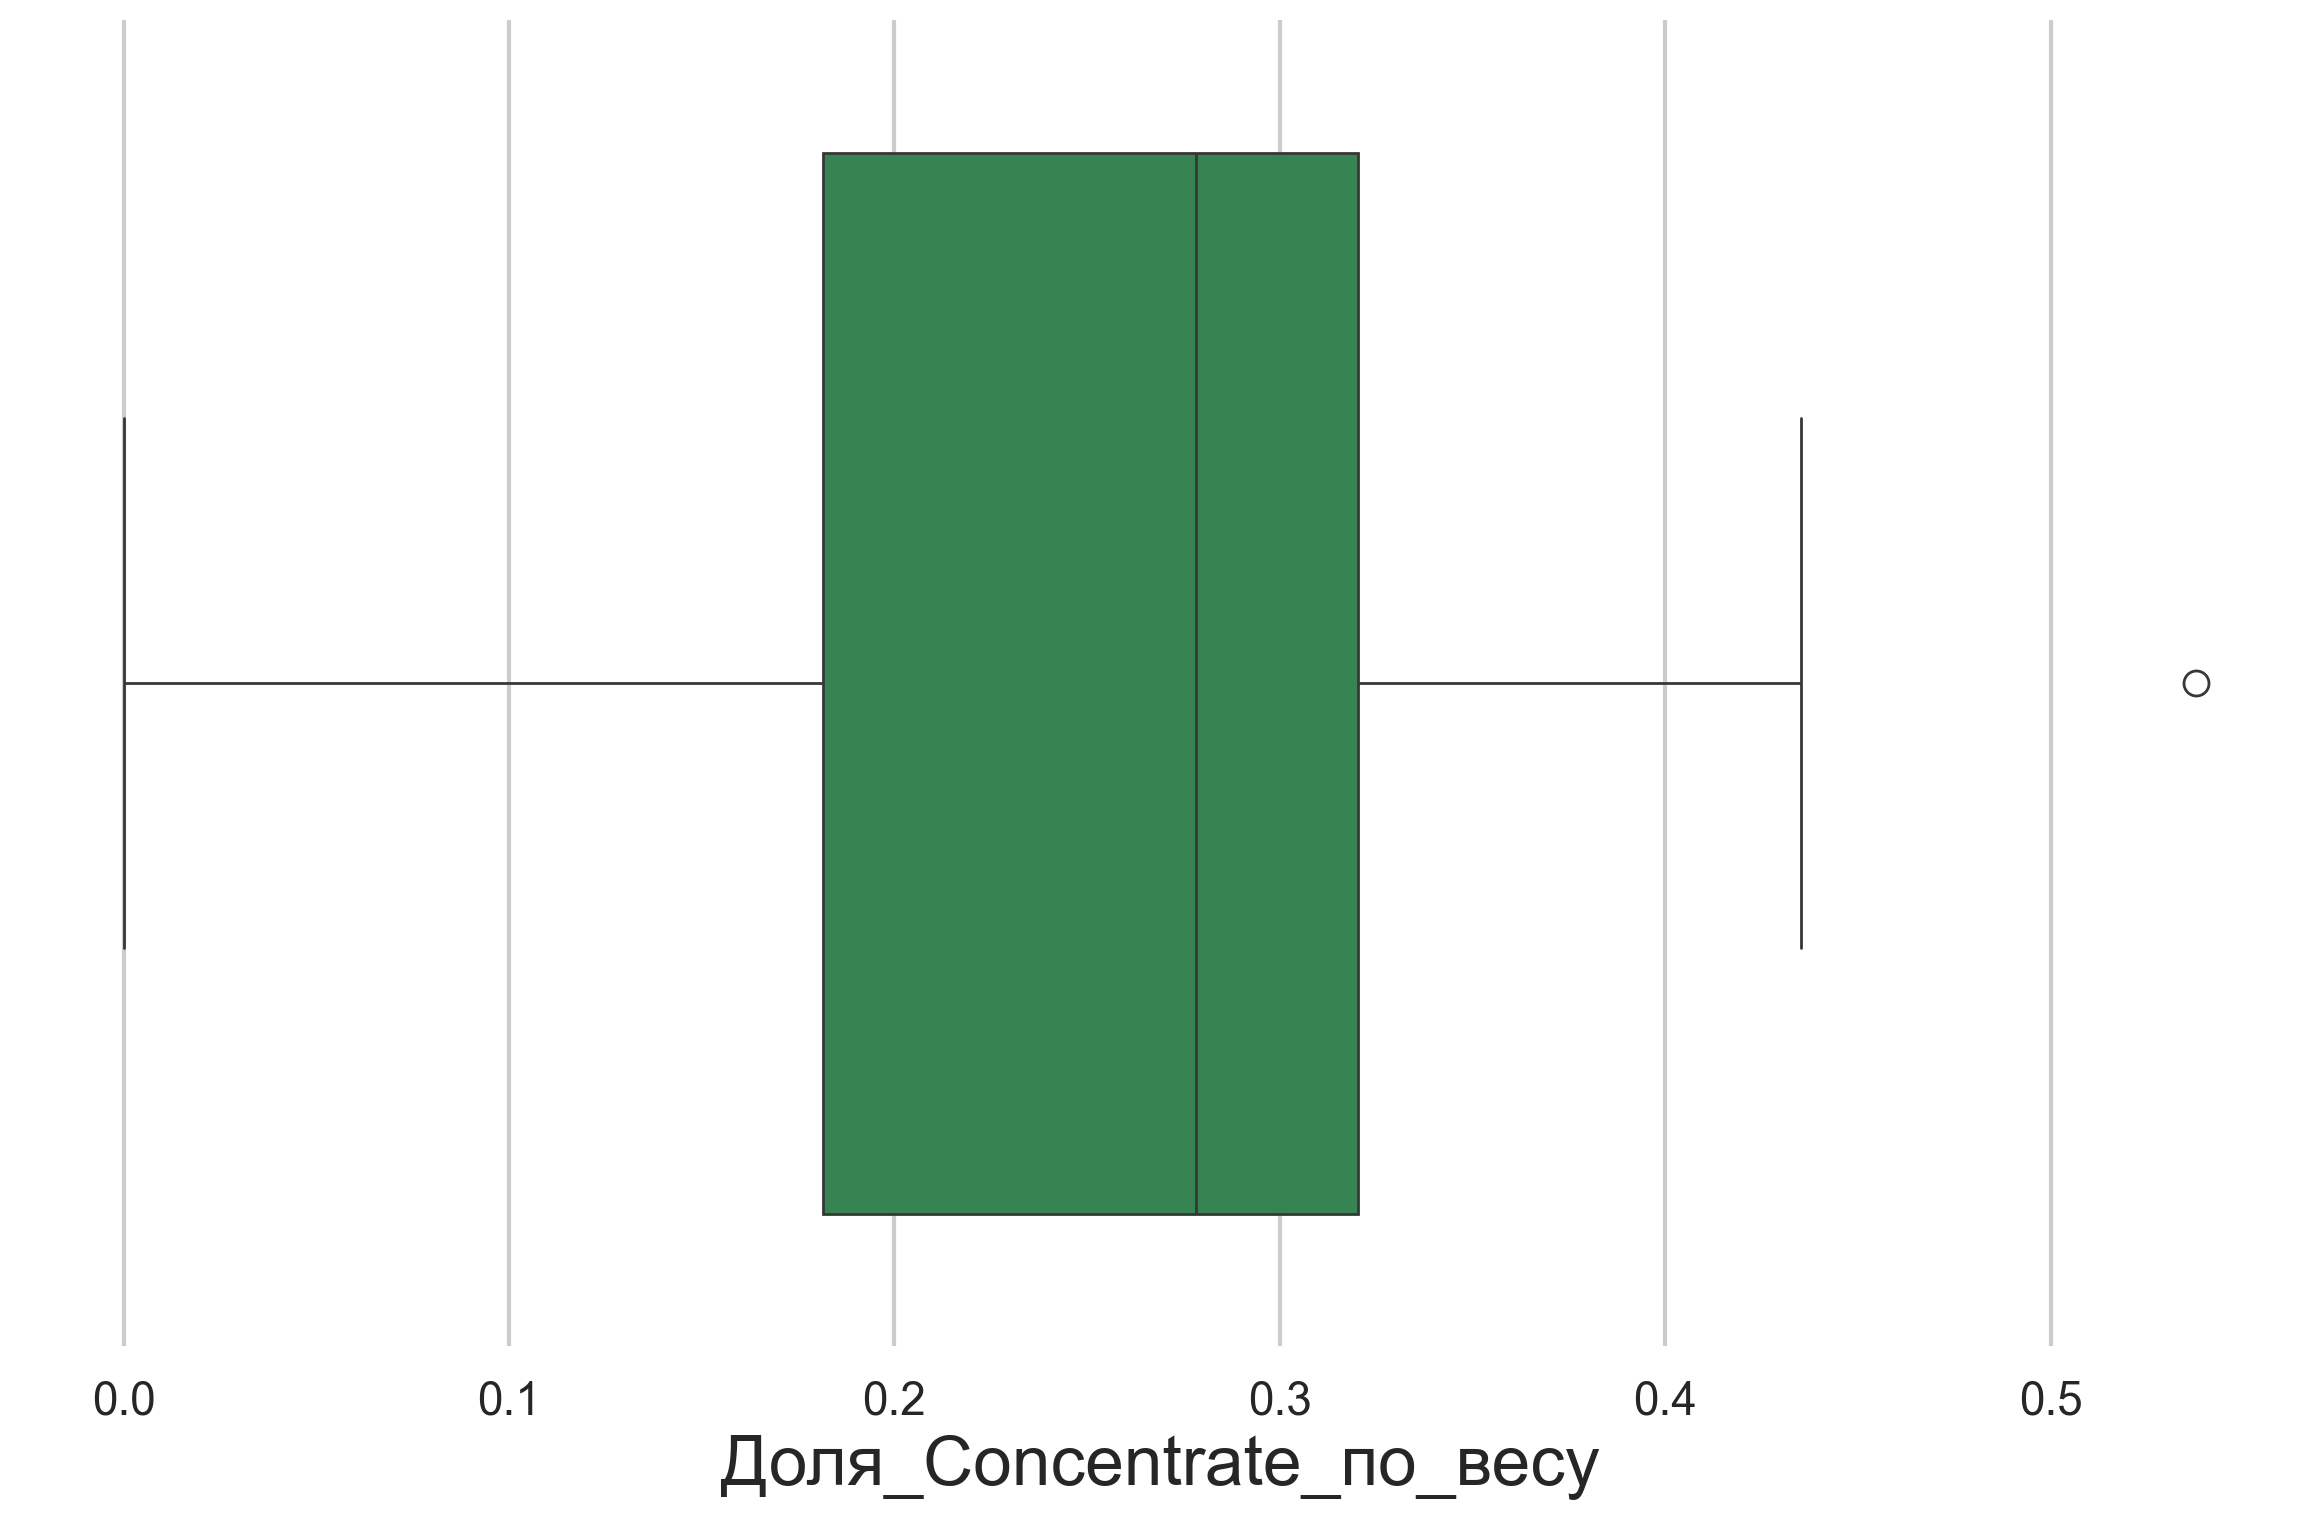

In [34]:
sns.boxplot(milk_protein, x="Доля_Concentrate_по_весу")

<Axes: xlabel='weekly_milking_per_cow'>

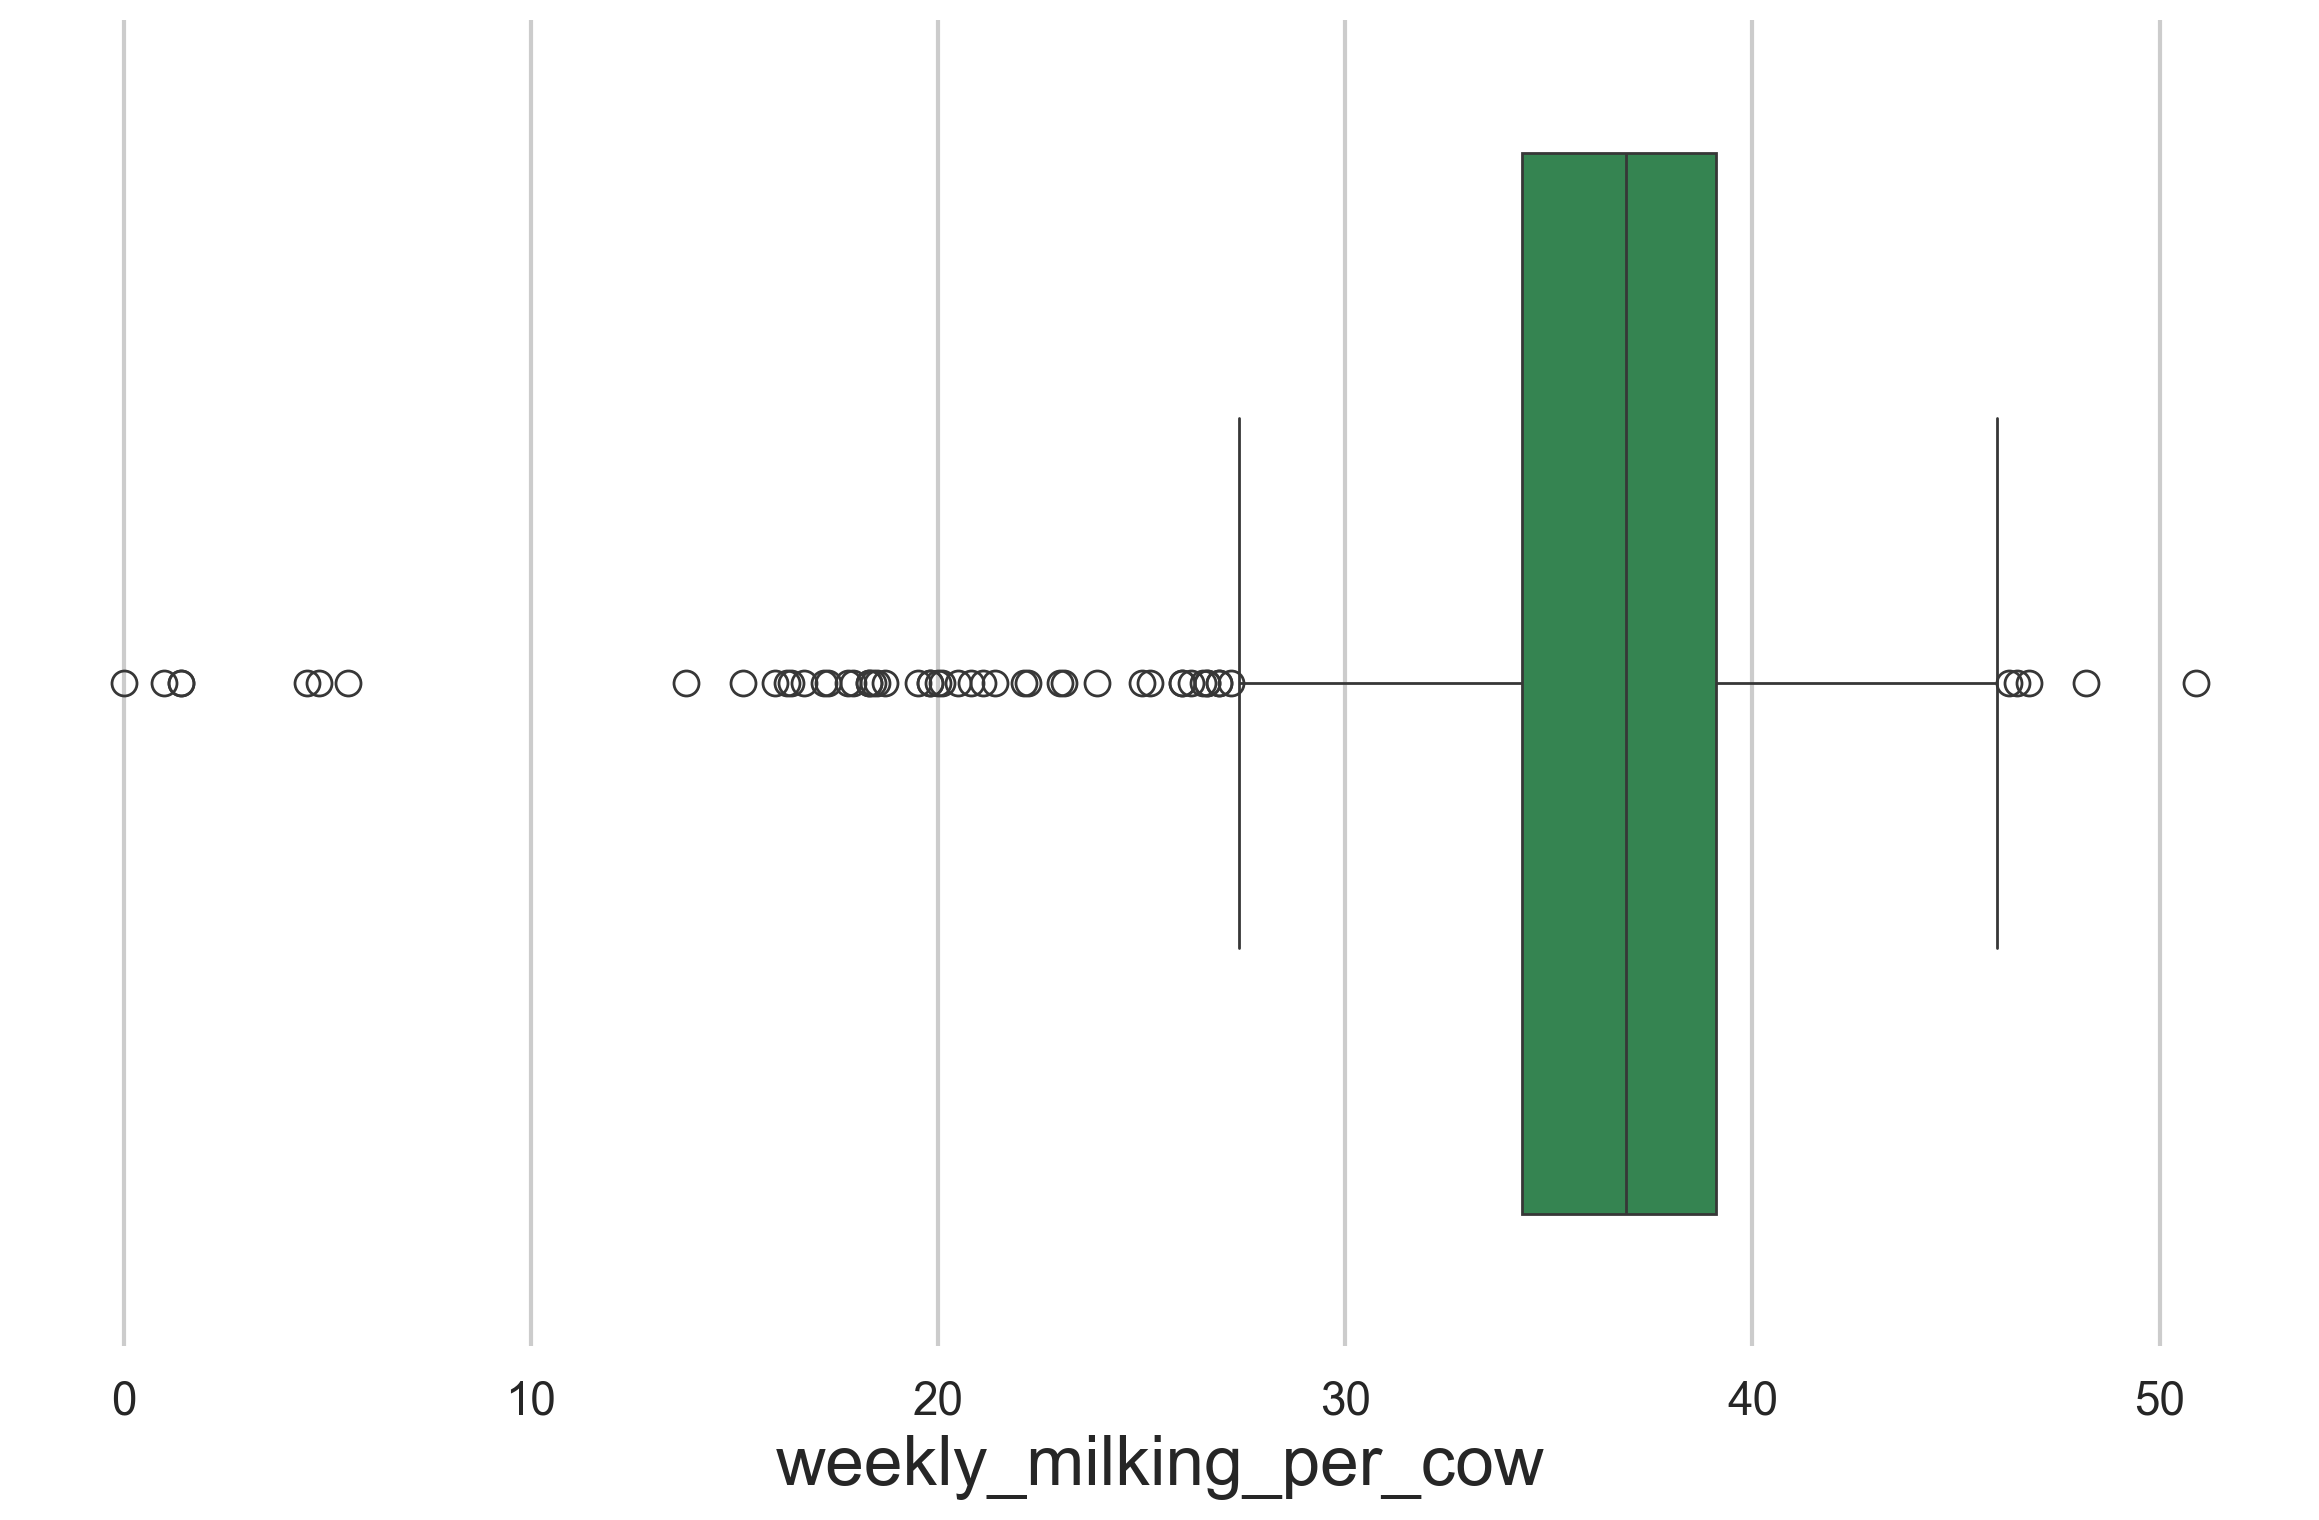

In [35]:
sns.boxplot(milk_protein, x="weekly_milking_per_cow")

In [36]:
milk_protein[["weekly_milking_per_cow", "Доля_Concentrate_по_весу"]].corr()

weekly_milking_per_cow  Доля_Concentrate_по_весу
weekly_milking_per_cow                  1.000000                  0.171505
Доля_Concentrate_по_весу                0.171505                  1.000000

In [37]:
df = herd_metrics.copy()
df['date'] = pd.to_datetime(df['date'])
df['farm_name'] = df['farm_name'].astype(str).str.strip()


df = df[df['milk_cow'] > 0]

df = df.rename(columns={"farm_name": "FarmName", "date": "Date"}).merge(feeding_all, on=["FarmName", "Date"], how='inner')

for col in ["Appetite", "milk_cow", "cow_mastits"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

distr = (
    df.groupby(['FarmName', 'Date'], as_index=False)
      .agg(
          Appetite_avg=('Appetite', 'mean'),
          Mastitis=('cow_mastits', 'sum'),
          Cows=('milk_cow', 'sum')
      )
)


distr['MastitisRate'] = distr['Mastitis'] / distr['Cows'].replace({0: np.nan})

distr = distr.dropna(subset=['Appetite_avg', 'MastitisRate'])
distr


FarmName       Date  Appetite_avg  Mastitis     Cows  MastitisRate
0     ЖК Авангард 2023-04-01      1.038710     868.0  33325.0      0.026047
1     ЖК Авангард 2023-05-01      1.036364    1221.0  35904.0      0.034007
2     ЖК Авангард 2023-06-01      1.009091     858.0  36333.0      0.023615
3     ЖК Авангард 2023-07-01      1.009091     990.0  35541.0      0.027855
4     ЖК Авангард 2023-08-01      0.975758    1386.0  35970.0      0.038532
...           ...        ...           ...       ...      ...           ...
1351    МТФ Щучье 2025-03-01      0.893548     279.0  16802.0      0.016605
1352    МТФ Щучье 2025-04-01      0.932258     217.0  16461.0      0.013183
1353    МТФ Щучье 2025-05-01      0.909677     310.0  14911.0      0.020790
1354    МТФ Щучье 2025-06-01      0.983871     341.0  14508.0      0.023504
1355    МТФ Щучье 2025-07-01      1.036667     390.0  15240.0      0.025591

[1356 rows x 6 columns]

<Axes: xlabel='Appetite_avg', ylabel='MastitisRate'>

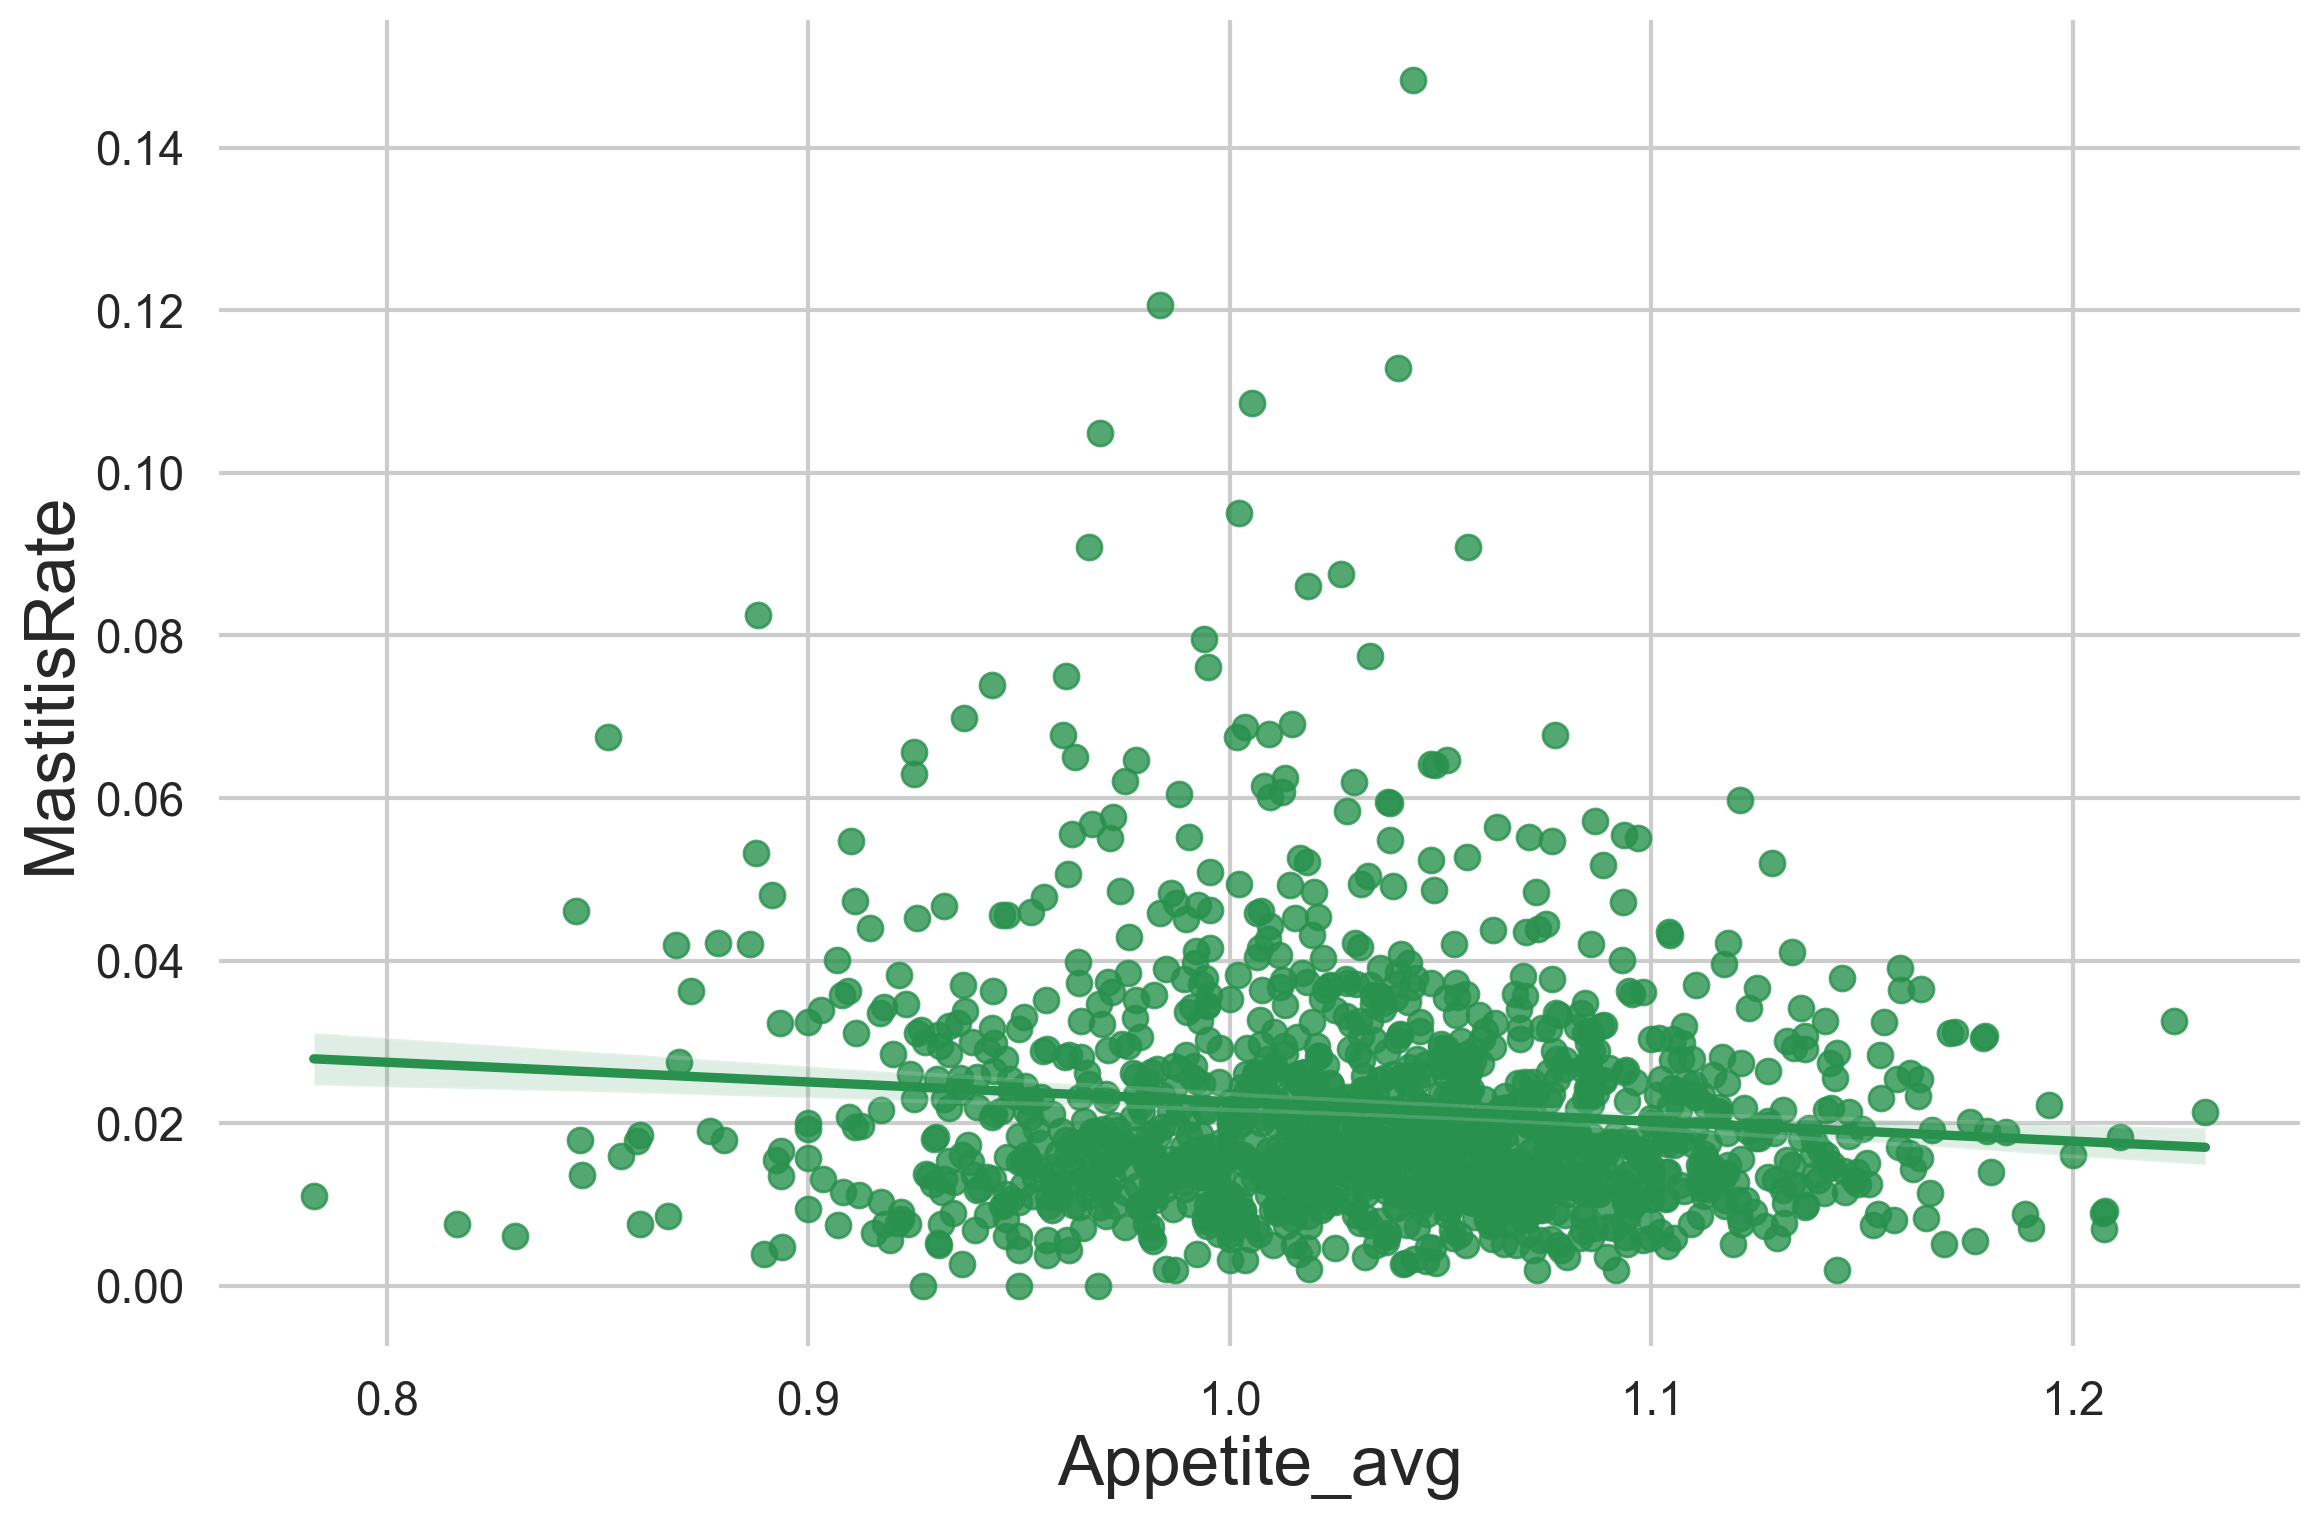

In [38]:
sns.regplot(distr, x="Appetite_avg", y="MastitisRate")

<Axes: xlabel='Appetite_avg', ylabel='MastitisRate'>

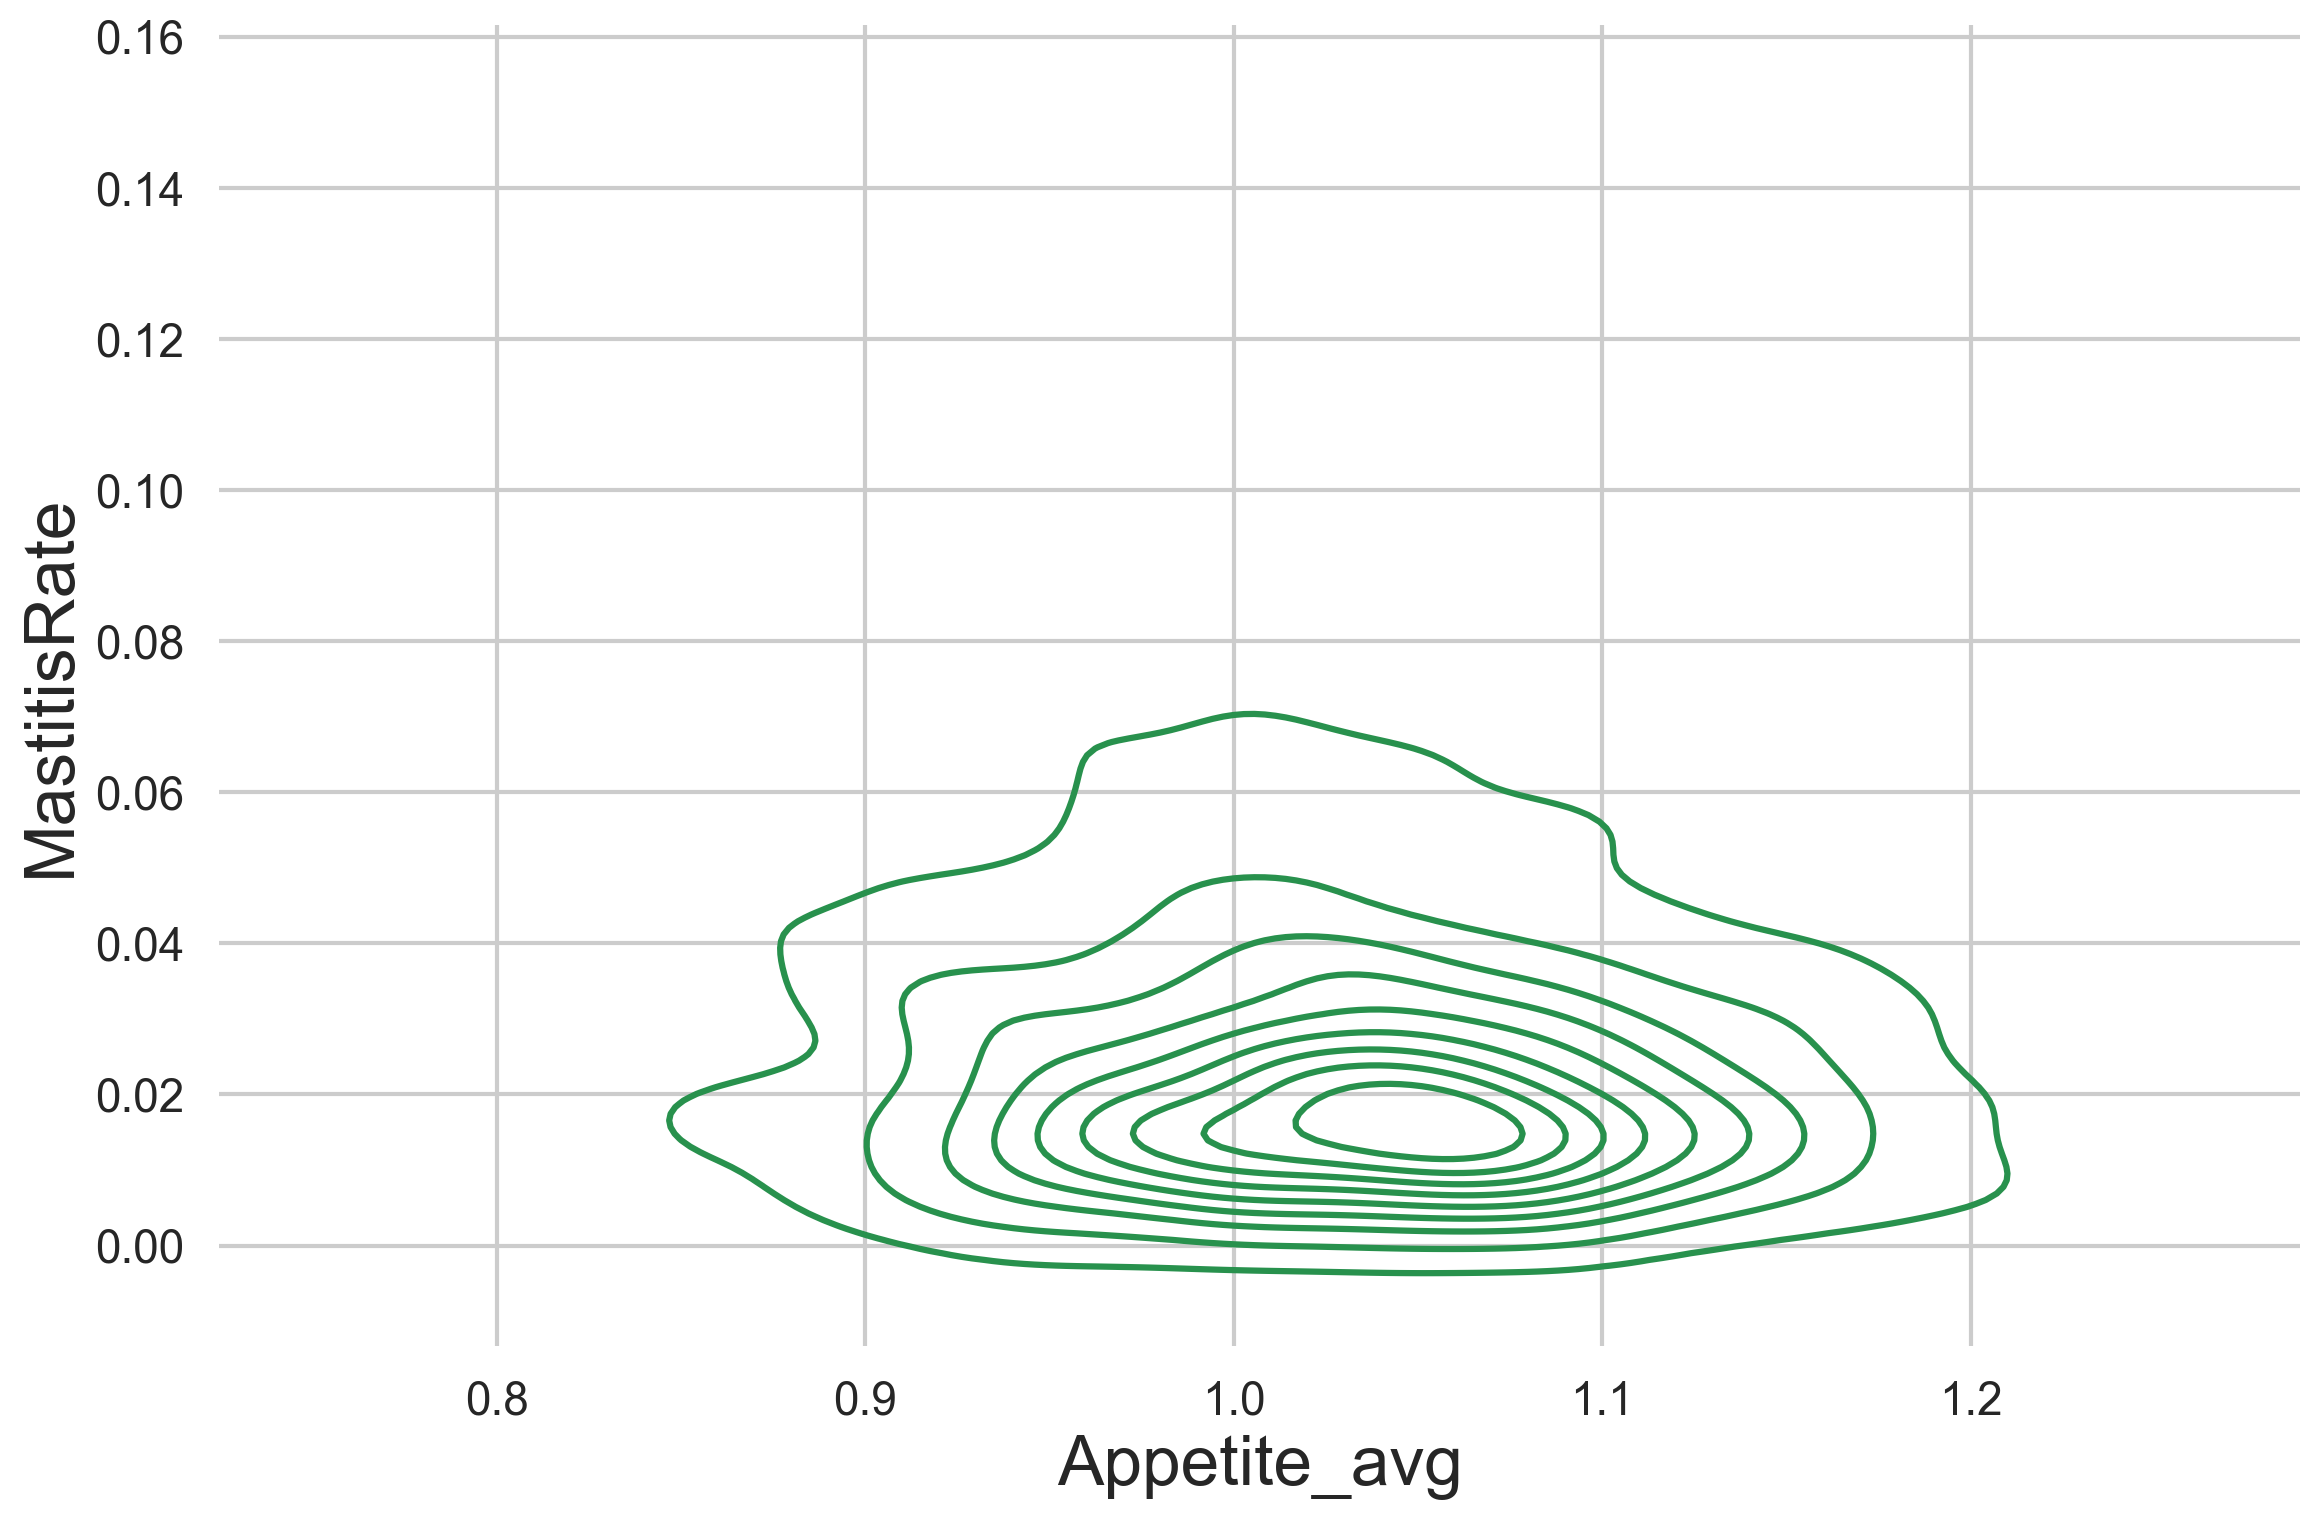

In [39]:
sns.kdeplot(distr, x="Appetite_avg", y="MastitisRate")

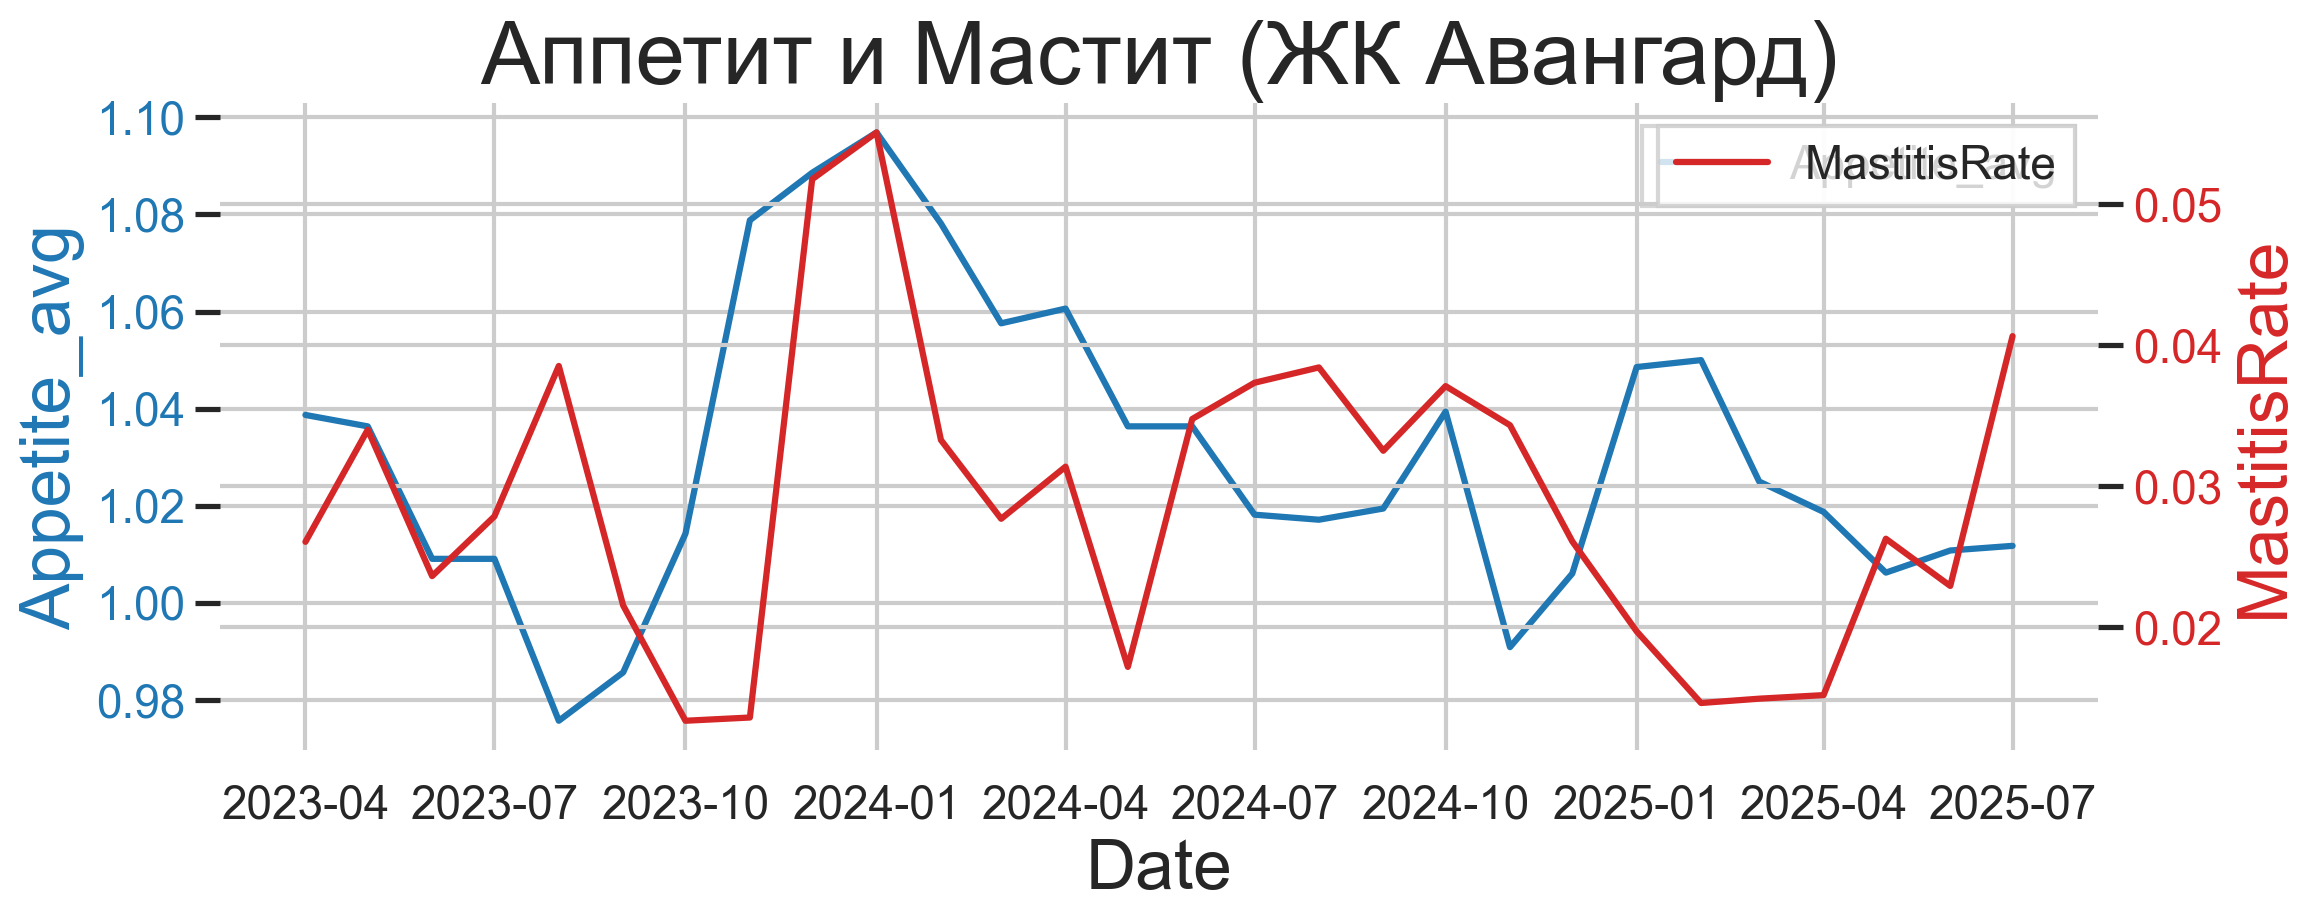

In [40]:
Avangard = distr[distr["FarmName"] == "ЖК Авангард"]
fig, ax = plt.subplots(figsize=(12, 5))

sns.lineplot(
    data=Avangard,
    x="Date",
    y="Appetite_avg",
    ax=ax,
    label="Appetite_avg",
    color="tab:blue"
)

ax.set_ylabel("Appetite_avg", color="tab:blue")
ax.tick_params(axis='y', labelcolor="tab:blue")

ax2 = ax.twinx()

sns.lineplot(
    data=Avangard,
    x="Date",
    y="MastitisRate",
    ax=ax2,
    label="MastitisRate",
    color="tab:red"
)

ax2.set_ylabel("MastitisRate", color="tab:red")
ax2.tick_params(axis='y', labelcolor="tab:red")

# --- Общие настройки ---
plt.title("Аппетит и Мастит (ЖК Авангард)")
fig.tight_layout()


In [41]:
import statsmodels.formula.api as smf

model = smf.ols("MastitisRate ~ Appetite_avg", data=distr).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           MastitisRate   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     15.21
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           0.000101
Time:                        11:40:50   Log-Likelihood:                 3799.8
No. Observations:                1356   AIC:                            -7596.
Df Residuals:                    1354   BIC:                            -7585.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0469      0.006      7.295   

In [42]:
distr[["Appetite_avg", "MastitisRate"]].corr()

Appetite_avg  MastitisRate
Appetite_avg      1.000000     -0.105407
MastitisRate     -0.105407      1.000000

---

In [43]:
production_indicators["farm_type"].value_counts()

farm_type
ЖК     1291
МТФ     228
РМ      181
РЖК      47
Name: count, dtype: int64

In [44]:
production_indicators

date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
4    2022-12-01  Воронеж                 ЭНА Восток       МТФ   
...         ...      ...                        ...       ...   
1742 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1743 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1744 2025-07-01   Сибирь   Сибирская Нива Маслянино        РМ   
1745 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1746 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1           ЖК Бобров-2      2882.0     2591.0         131.0        2149.0   
2     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
3      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
4              МТФ ЭНАВ       799.0      738.0           8.0         507.0   
...                 ...         ...        ...           ...           ...   
1742          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1743        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1744        РМ Пеньково         0.0        0.0           0.0           0.0   
1745   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1746       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            261.0          50.0                    36.3           88816.0   
2            375.0           0.0                    38.3           98563.0   
3            163.0         162.0                    35.2           87647.0   
4              0.0         223.0                     NaN               NaN   
...            ...           ...                     ...               ...   
1742         288.0         556.0                    36.0          191276.0   
1743         559.0         286.0                    36.7          147218.0   
1744           0.0           0.0                     NaN               NaN   
1745        1027.0          57.0                    40.4          119264.0   
1746         256.0           0.0                    37.3          115557.0   

      cow_retired  cow_retired_low_prod  cow_retired_hooves  \
0             0.0                   NaN                 NaN   
1            68.0                   NaN                 NaN   
2            85.0                   NaN                 NaN   
3           153.0                   NaN                 NaN   
4            66.0                   NaN                 NaN   
...           ...                   ...                 ...   
1742        526.0                   0.0                14.0   
1743        189.0                  48.0                23.0   
1744          0.0                   NaN                 NaN   
1745        115.0                  21.0                18.0   
1746         76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  
0                       NaN                 NaN              NaN      23.0  
1                       NaN                 NaN              NaN      18.0  
2                       NaN                 NaN              NaN       0.0  
3                       NaN                 NaN              NaN      26.0  
4                       NaN                 NaN              NaN       0.0  
...                     ...                 ...              ...       ...  
1742                   33.0                13.0             

In [45]:
herds_farm = production_indicators.merge(herd_metrics, on=["date", "prod_farm_name", "region", "farm_type", "farm_name"], how="inner")
herds_farm

date   region             prod_farm_name farm_type  \
0    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
1    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
2    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
3    2022-12-01  Воронеж                 ЭНА Восток        ЖК   
4    2022-12-01  Воронеж                 ЭНА Восток        РМ   
...         ...      ...                        ...       ...   
1486 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1487 2025-07-01   Сибирь   Сибирская Нива Маслянино        ЖК   
1488 2025-07-01   Сибирь   Сибирская Нива Маслянино        РМ   
1489 2025-07-01   Сибирь  Сибирская Нива Черепаново        ЖК   
1490 2025-07-01   Сибирь                   ЭН Алтай        ЖК   

              farm_name  cows_total  milk_cows  milk_cows_d0  milk_cows_d1  \
0             ЖК Бобров      2878.0     2609.0          69.0        2094.0   
1           ЖК Бобров-2      2882.0     2591.0         131.0        2149.0   
2     ЖК Верхний Икорец      2893.0     2580.0         101.0        2104.0   
3      ЖК Петропавловка      2885.0     2686.0          90.0        2271.0   
4         РМ Никольское         0.0        0.0           0.0           0.0   
...                 ...         ...        ...           ...           ...   
1486          ЖК Елбань      5882.0     5468.0         169.0        4455.0   
1487        ЖК Пеньково      4666.0     4172.0         304.0        3023.0   
1488        РМ Пеньково         0.0        0.0           0.0           0.0   
1489   ЖК Огнева Заимка      3544.0     3140.0         214.0        1842.0   
1490       ЖК Курочкино      3429.0     3189.0          91.0        2842.0   

      milk_cows_d2  milk_cows_d3  weekly_milking_per_cow  gross_milk_yield  \
0            340.0         106.0                    34.1           86551.0   
1            261.0          50.0                    36.3           88816.0   
2            375.0           0.0                    38.3           98563.0   
3            163.0         162.0                    35.2           87647.0   
4              0.0           0.0                     NaN               NaN   
...            ...           ...                     ...               ...   
1486         288.0         556.0                    36.0          191276.0   
1487         559.0         286.0                    36.7          147218.0   
1488           0.0           0.0                     NaN               NaN   
1489        1027.0          57.0                    40.4          119264.0   
1490         256.0           0.0                    37.3          115557.0   

      cow_retired_x  cow_retired_low_prod  cow_retired_hooves  \
0               0.0                   NaN                 NaN   
1              68.0                   NaN                 NaN   
2              85.0                   NaN                 NaN   
3             153.0                   NaN                 NaN   
4              34.0                   NaN                 NaN   
...             ...                   ...                 ...   
1486          526.0                   0.0                14.0   
1487          189.0                  48.0                23.0   
1488            0.0                   NaN                 NaN   
1489          115.0                  21.0                18.0   
1490           76.0                  21.0                 9.0   

      cow_retired_inj_joint  cow_retired_mastit  cow_retired_jkt  bull_num  \
0                       NaN                 NaN              NaN      23.0   
1                       NaN                 NaN              NaN      18.0   
2                       NaN                 NaN              NaN       0.0   
3                       NaN                 NaN              NaN      26.0   
4                       NaN                 NaN              NaN       0.0   
...                     ...                 ...              ...       ...   
1486                   33.0  

In [46]:
feeding_all

FeedingTaskID       Date  \
0        Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
1        Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
2        Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
3        Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
4        Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
...                                                    ...        ...   
2155373  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
2155374  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
2155375  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
2155376  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
2155377  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   

              FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0           ЖК Добрино          15          9                     2   
1           ЖК Добрино          16         10                     2   
2           ЖК Добрино          14         74                     2   
3           ЖК Добрино          33        101                     2   
4           ЖК Добрино          37         99                    58   
...                ...         ...        ...                   ...   
2155373  ЖК Подболотье          16          1                     3   
2155374  ЖК Подболотье          17         14                     7   
2155375  ЖК Подболотье          18        139                     7   
2155376  ЖК Подболотье          19        103                     7   
2155377  ЖК Подболотье          20        131                     1   

        PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                           Д1                          352       0.9   
1                           Д1                          352       0.9   
2                           Д1                          280       0.5   
3                           Д1                          386       1.0   
4               Т3 (9-12 мес.)                          304       1.0   
...                        ...                          ...       ...   
2155373                     Д1                          139       1.1   
2155374                     С1                           37       1.2   
2155375                     С1                           37       1.3   
2155376                     С1                           37       1.4   
2155377                 Нетели                           32       1.2   

        RationName  RationPart  TotalWeight_kg                  CompletedAt  \
0               Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
1               Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
2               Д1         0.5          3678.0  2022-01-03T05:45:50.5175580   
3               Д1         1.0         19675.0  2022-01-01T13:28:00.0000000   
4          Т3 9-12         1.0          4360.0  2022-01-01T10:45:00.0000000   
...            ...         ...             ...                          ...   
2155373         Д1         0.6          5476.0  2025-10-22T08:30:28.0916260   
2155374         С1         1.0          1390.0  2025-10-22T08:53:57.7488136   
2155375         С1         1.0          1435.0  2025-10-22T08:53:09.7102933   
2155376         С1         1.0          1601.0  2025-10-22T08:51:09.2068847   
2155377         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   

         year  
0        2022  
1        2022  
2        2022  
3        2022  
4        2022  
...       ...  
2155373  2025  
2155374  2025  
2155375  2025  
2155376  2025  
2155377  2025  

[2155378 rows x 14 columns]

In [47]:
feeding_and_details

FeedingTaskID       Date  \
0         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
1         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
2         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
3         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
4         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
...                                                     ...        ...   
16411360  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411361  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411362  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411363  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411364  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   

               FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0            ЖК Добрино          15          9                     2   
1            ЖК Добрино          15          9                     2   
2            ЖК Добрино          15          9                     2   
3            ЖК Добрино          15          9                     2   
4            ЖК Добрино          15          9                     2   
...                 ...         ...        ...                   ...   
16411360  ЖК Подболотье          20        131                     1   
16411361  ЖК Подболотье          20        131                     1   
16411362  ЖК Подболотье          20        131                     1   
16411363  ЖК Подболотье          20        131                     1   
16411364  ЖК Подболотье          20        131                     1   

         PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                            Д1                          352       0.9   
1                            Д1                          352       0.9   
2                            Д1                          352       0.9   
3                            Д1                          352       0.9   
4                            Д1                          352       0.9   
...                         ...                          ...       ...   
16411360                 Нетели                           32       1.2   
16411361                 Нетели                           32       1.2   
16411362                 Нетели                           32       1.2   
16411363                 Нетели                           32       1.2   
16411364                 Нетели                           32       1.2   

         RationName  RationPart  TotalWeight_kg                  CompletedAt  \
0                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
1                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
2                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
3                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
4                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
...             ...         ...             ...                          ...   
16411360         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411361         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411362         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411363         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411364         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   

          year  IngredientID          IngredientName  IngredientType  \
0         2022         125.0         Солома покупная          Forage   
1         2022         773.0      3645.01.01.01.1.20          Forage   
2         2022          72.0     Комбикорм 10 группы     Concentrate   
3         2022          82.0          Кукуруза сухая     Concentrate   
4         2022         129.0       Шрот подсолнечный     Concentrate   
...       

In [48]:
grouped = feeding_and_details.groupby(
    ["Date", "FarmName", "IngredientType"]
)["PhysicalWeight_kg"].sum().reset_index()

grouped["TotalWeight_kg_byFarm"] = grouped.groupby(
    ["Date", "FarmName"]
)["PhysicalWeight_kg"].transform("sum")

planned = feeding_and_details[
    ["FeedingTaskID", "SectionID", "Date", "FarmName", "TotalWeight_kg", "PhysiologicalGroupHeadCount"]
].drop_duplicates()

task_totals = planned.groupby(
    ["Date", "FarmName"]).agg(
        {
          "TotalWeight_kg": "sum",
          "PhysiologicalGroupHeadCount": "sum" 
        }).reset_index().rename(columns={
            "TotalWeight_kg": "WeightPerDay",
             "PhysiologicalGroupHeadCount": "CowCount"
        })


merged = pd.merge(
    grouped,
    task_totals,
    on=["Date", "FarmName"],
    how="left"
)

merged["Share"] = merged["PhysicalWeight_kg"] / merged["TotalWeight_kg_byFarm"]

merged


Date     FarmName  IngredientType  PhysicalWeight_kg  \
0      2022-01-01   ЖК Добрино     Concentrate          56526.080   
1      2022-01-01   ЖК Добрино          Forage         156425.000   
2      2022-01-01   ЖК Добрино  VitaminMineral           4223.865   
3      2022-01-01   ЖК Добрино           Water          24437.001   
4      2022-01-01   ЖК Коршево     Concentrate          40109.999   
...           ...          ...             ...                ...   
205540 2025-10-22    РМ Поляна          Forage           9405.000   
205541 2025-10-22    РМ Поляна  VitaminMineral             84.000   
205542 2025-10-22  РМ Торопово     Concentrate           1337.000   
205543 2025-10-22  РМ Торопово          Forage          36567.000   
205544 2025-10-22  РМ Торопово  VitaminMineral            315.054   

        TotalWeight_kg_byFarm  WeightPerDay  CowCount     Share  
0                  241611.946      238688.0      9769  0.233954  
1                  241611.946      238688.0      9769  0.647422  
2                  241611.946      238688.0      9769  0.017482  
3                  241611.946      238688.0      9769  0.101142  
4                  153633.191      150635.0      5067  0.261076  
...                       ...           ...       ...       ...  
205540              11500.000       11549.0       653  0.817826  
205541              11500.000       11549.0       653  0.007304  
205542              38219.054       38220.0      4067  0.034983  
205543              38219.054       38220.0      4067  0.956774  
205544              38219.054       38220.0      4067  0.008243  

[205545 rows x 8 columns]

In [49]:
df = merged.copy()

df["WeightDiff"] = abs(df["WeightPerDay"] - df["TotalWeight_kg_byFarm"])
df

Date     FarmName  IngredientType  PhysicalWeight_kg  \
0      2022-01-01   ЖК Добрино     Concentrate          56526.080   
1      2022-01-01   ЖК Добрино          Forage         156425.000   
2      2022-01-01   ЖК Добрино  VitaminMineral           4223.865   
3      2022-01-01   ЖК Добрино           Water          24437.001   
4      2022-01-01   ЖК Коршево     Concentrate          40109.999   
...           ...          ...             ...                ...   
205540 2025-10-22    РМ Поляна          Forage           9405.000   
205541 2025-10-22    РМ Поляна  VitaminMineral             84.000   
205542 2025-10-22  РМ Торопово     Concentrate           1337.000   
205543 2025-10-22  РМ Торопово          Forage          36567.000   
205544 2025-10-22  РМ Торопово  VitaminMineral            315.054   

        TotalWeight_kg_byFarm  WeightPerDay  CowCount     Share  WeightDiff  
0                  241611.946      238688.0      9769  0.233954    2923.946  
1                  241611.946      238688.0      9769  0.647422    2923.946  
2                  241611.946      238688.0      9769  0.017482    2923.946  
3                  241611.946      238688.0      9769  0.101142    2923.946  
4                  153633.191      150635.0      5067  0.261076    2998.191  
...                       ...           ...       ...       ...         ...  
205540              11500.000       11549.0       653  0.817826      49.000  
205541              11500.000       11549.0       653  0.007304      49.000  
205542              38219.054       38220.0      4067  0.034983       0.946  
205543              38219.054       38220.0      4067  0.956774       0.946  
205544              38219.054       38220.0      4067  0.008243       0.946  

[205545 rows x 9 columns]

In [50]:
df["FarmName"].nunique()

53

In [51]:
dff = df.groupby(["Date", "FarmName"]).agg({"WeightDiff": "first"}).reset_index()

<Axes: xlabel='Date', ylabel='WeightDiff'>

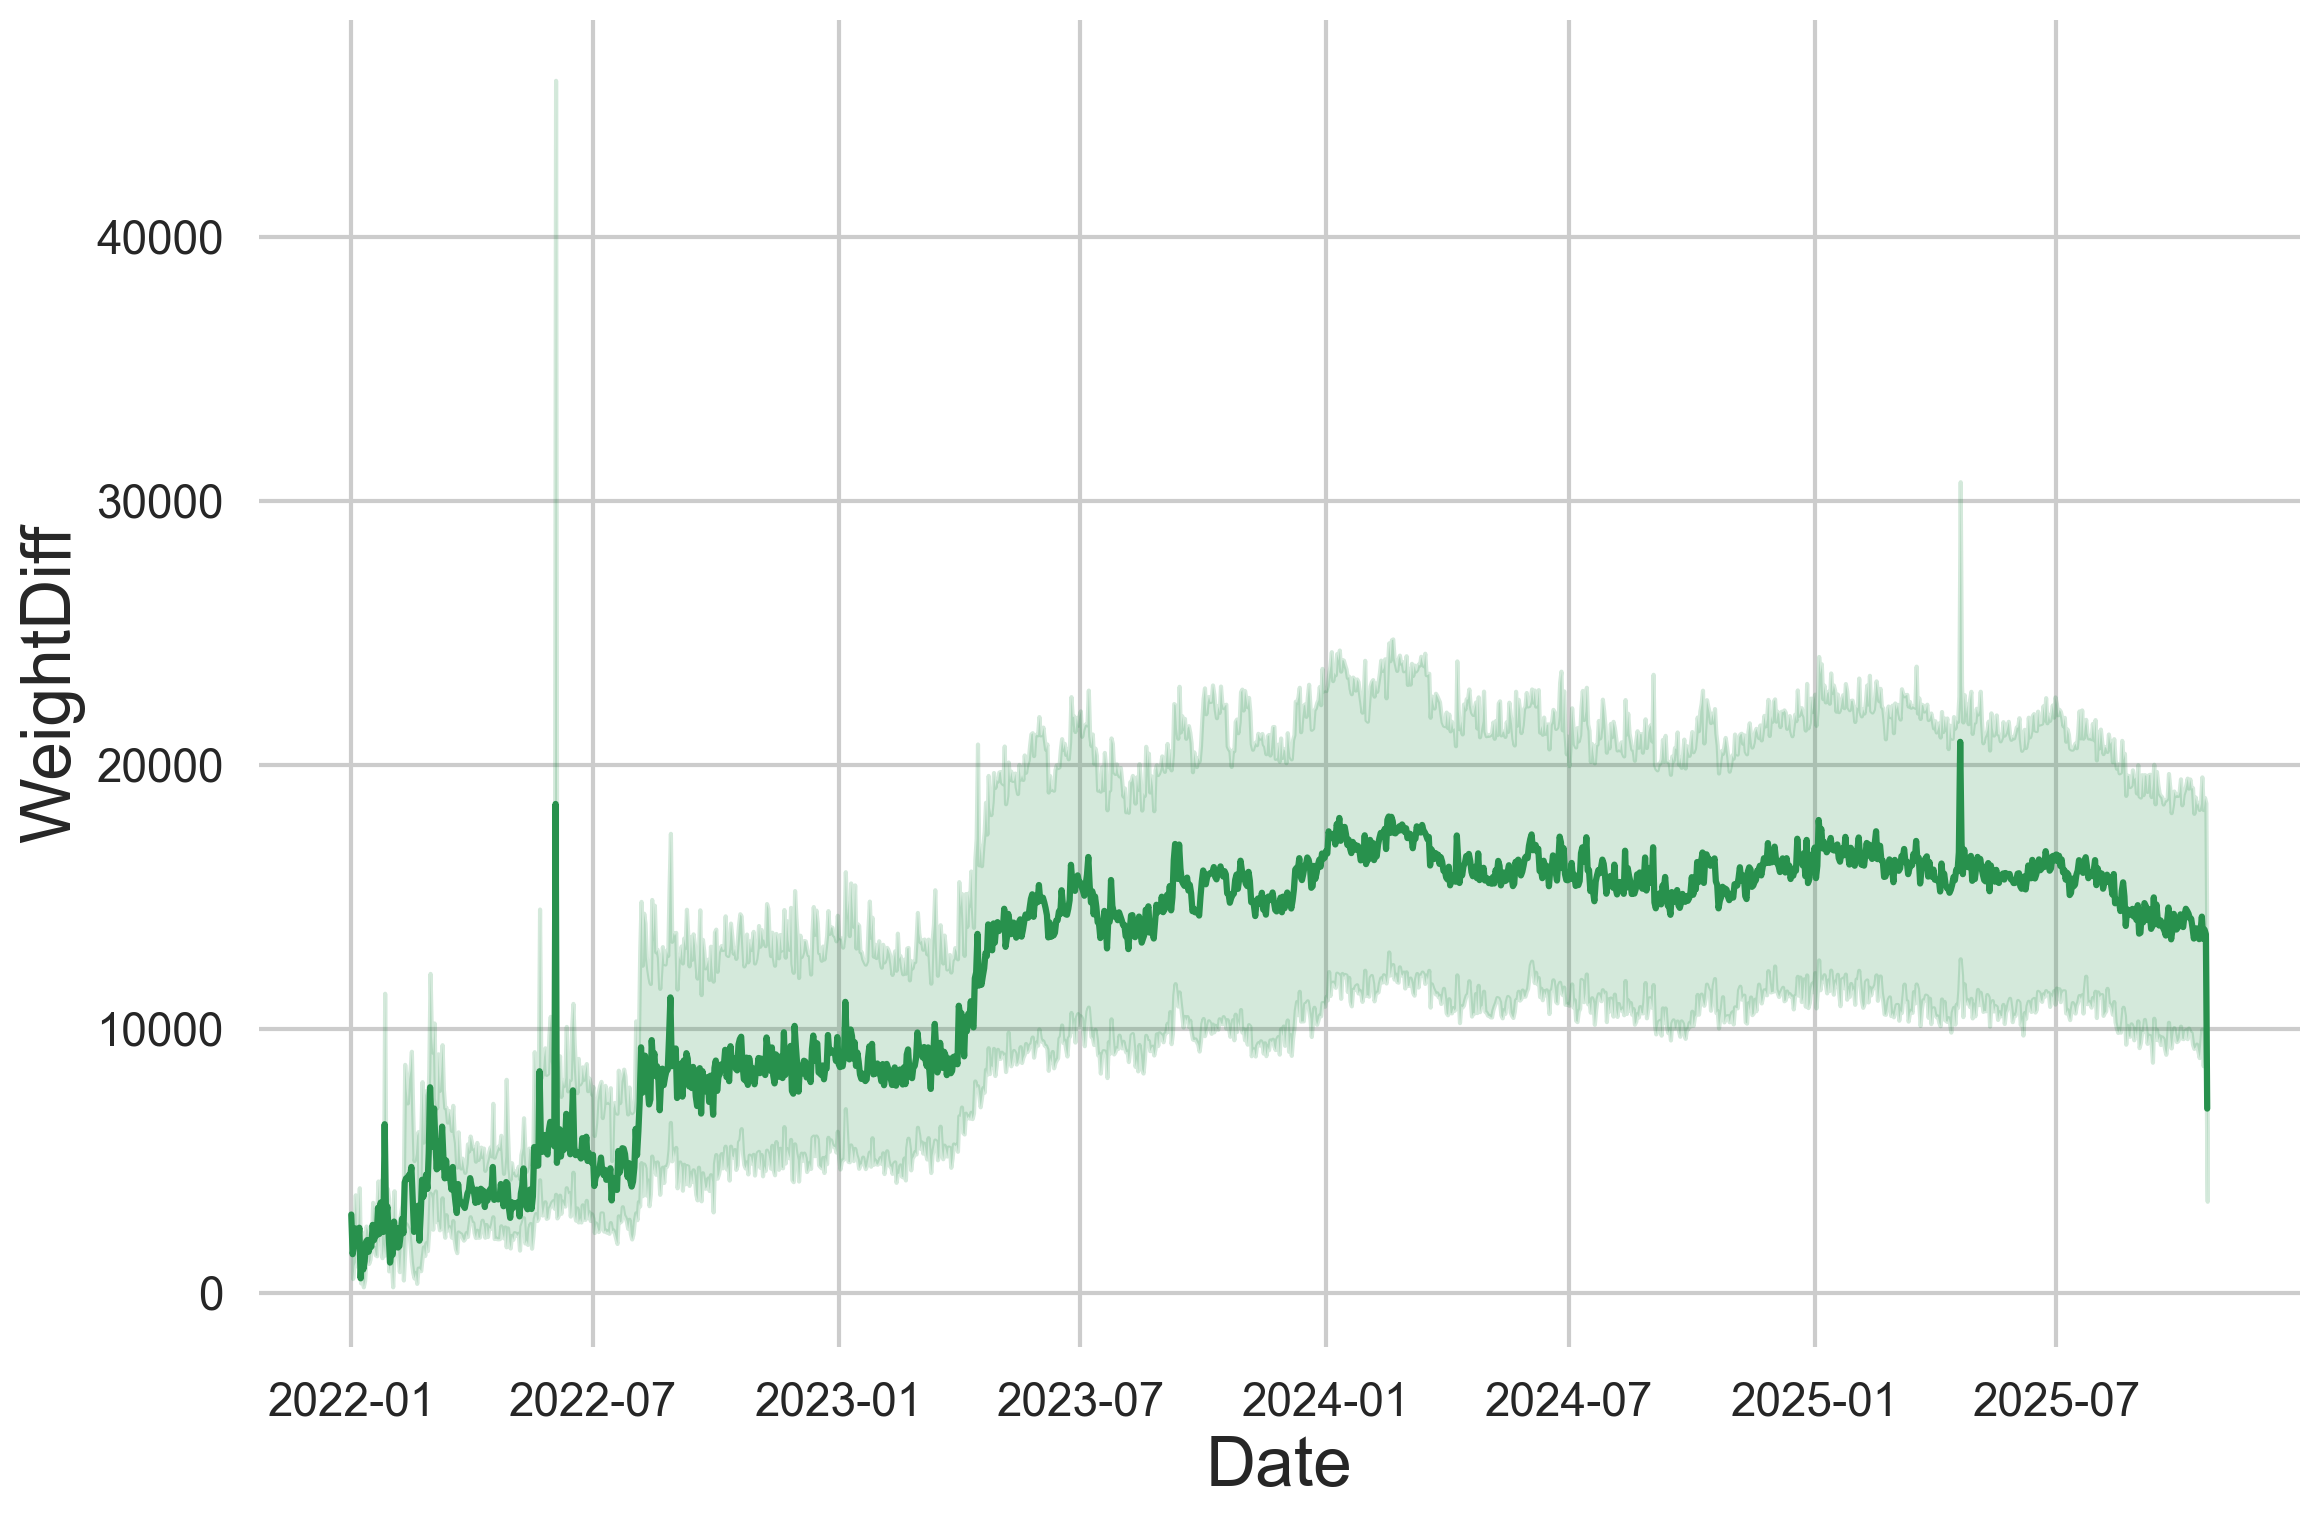

In [52]:
sns.lineplot(dff, x="Date", y="WeightDiff")

<Axes: xlabel='Date', ylabel='WeightDiff'>

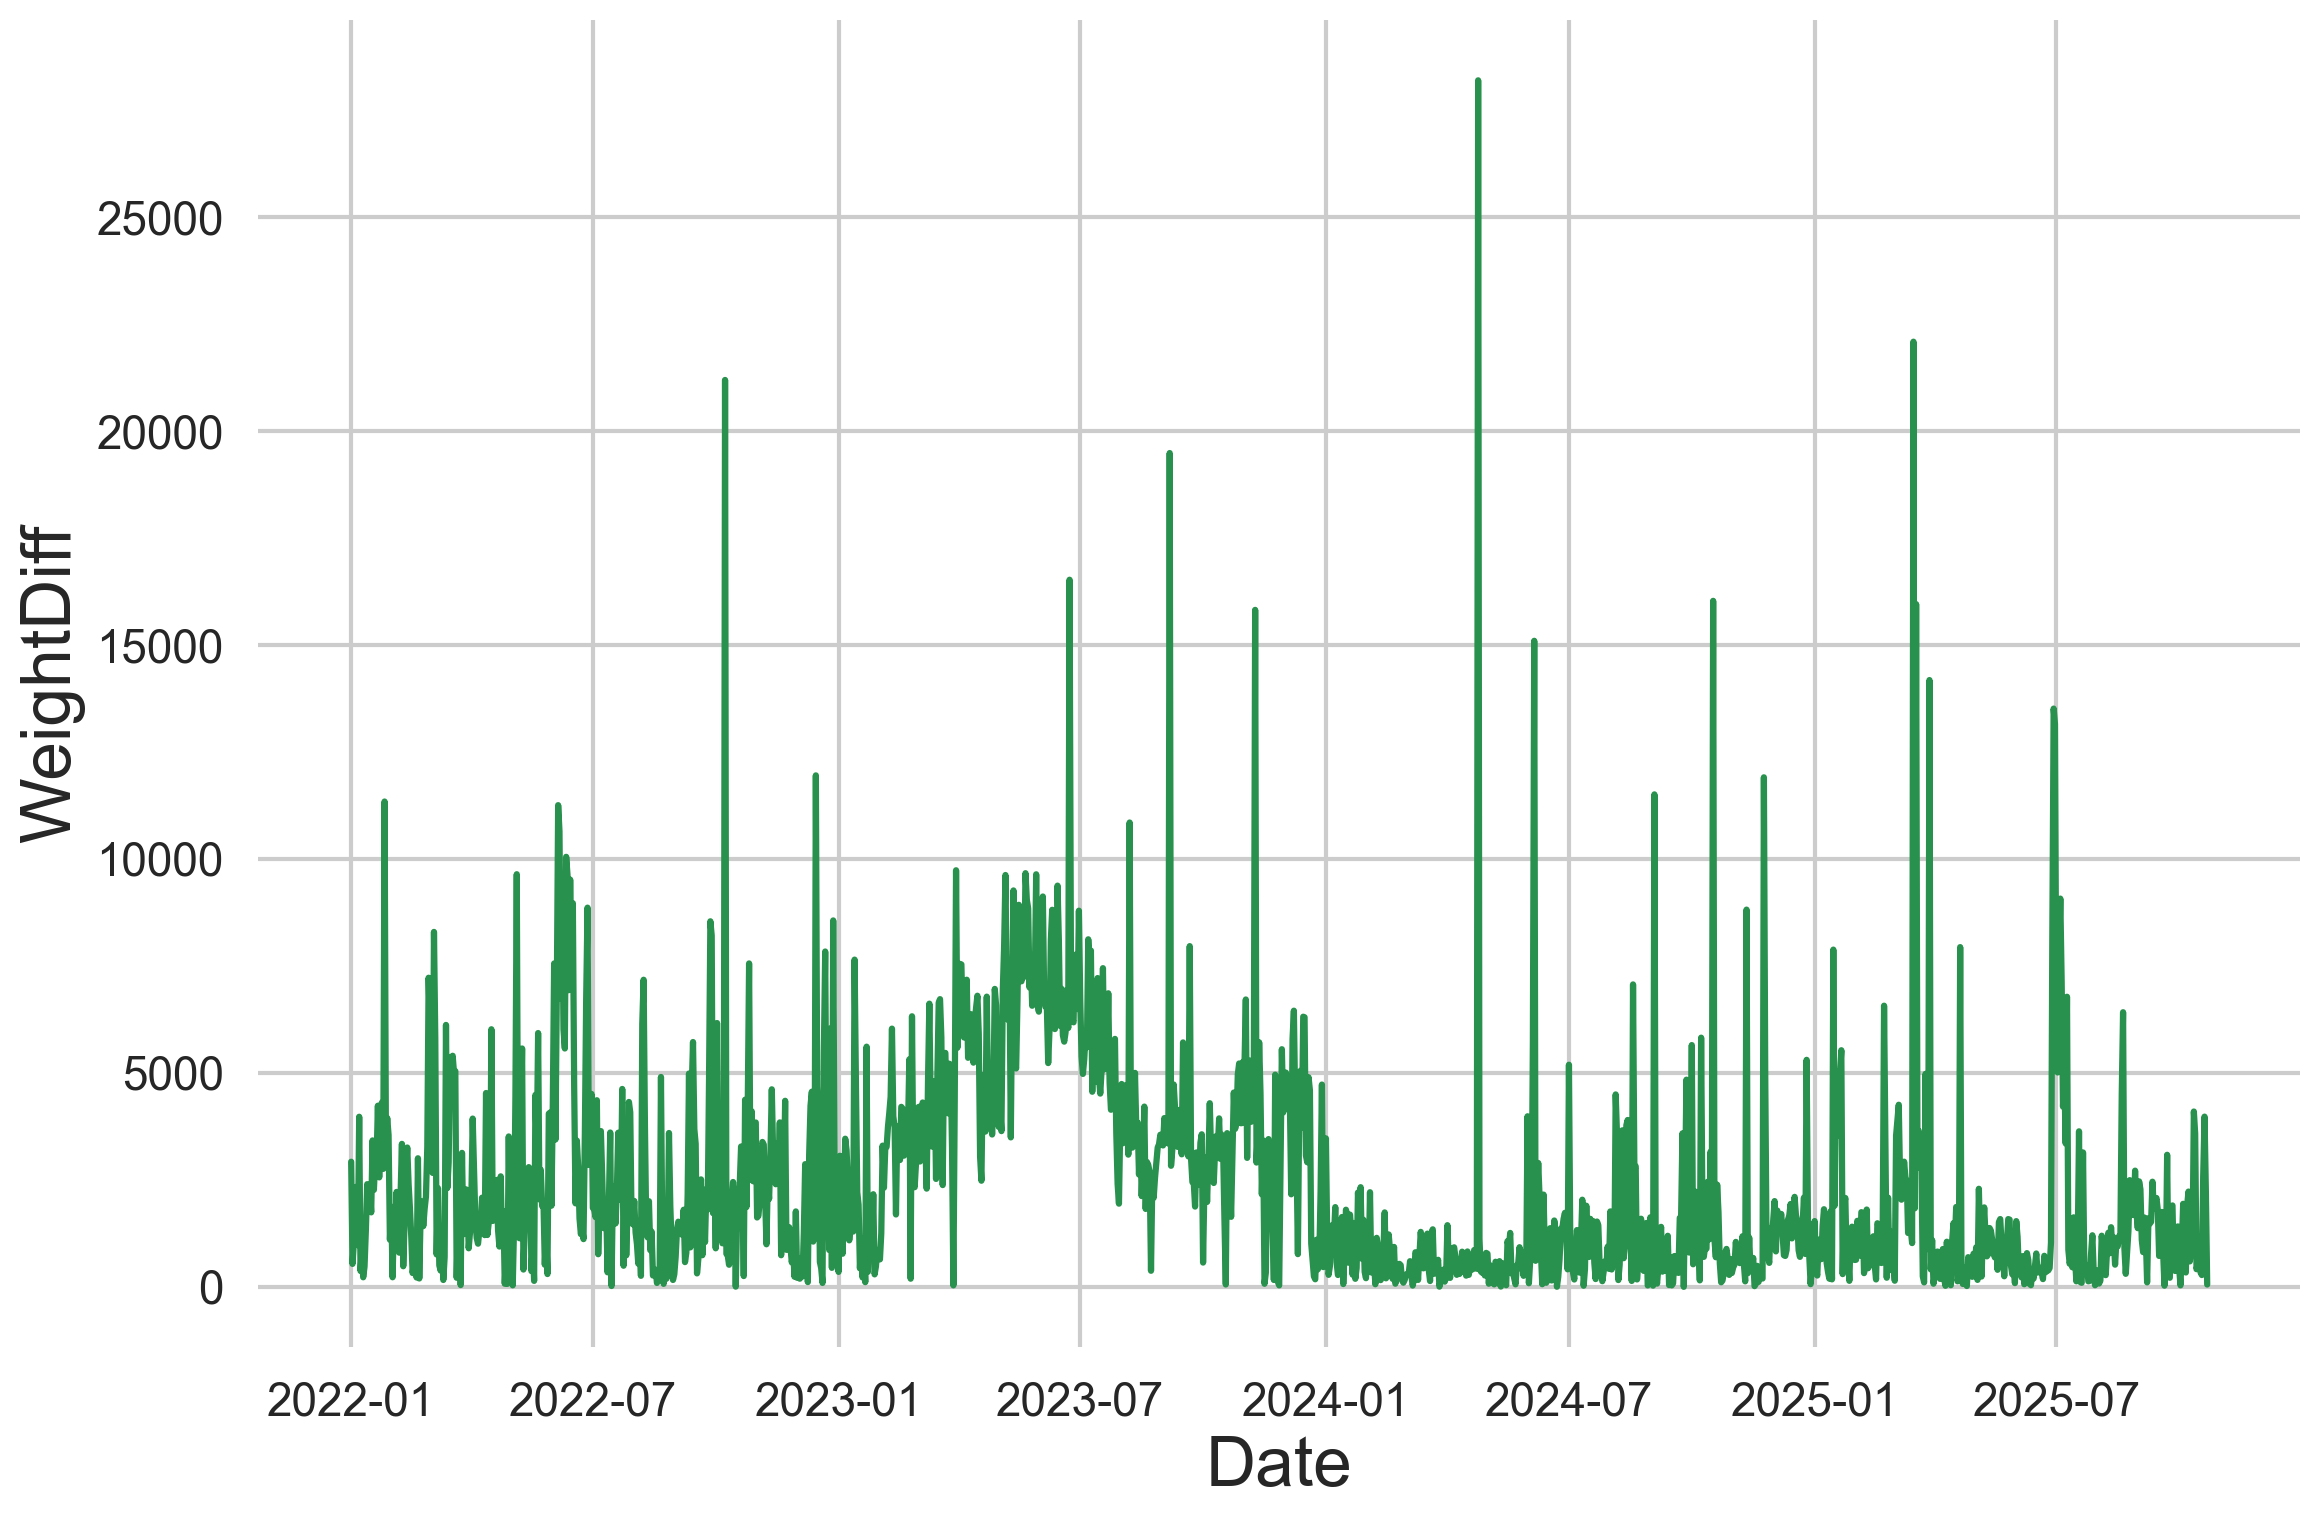

In [53]:
sns.lineplot(dff[dff["FarmName"] == "ЖК Добрино"], x="Date", y="WeightDiff")

<Axes: xlabel='WeightDiff', ylabel='Count'>

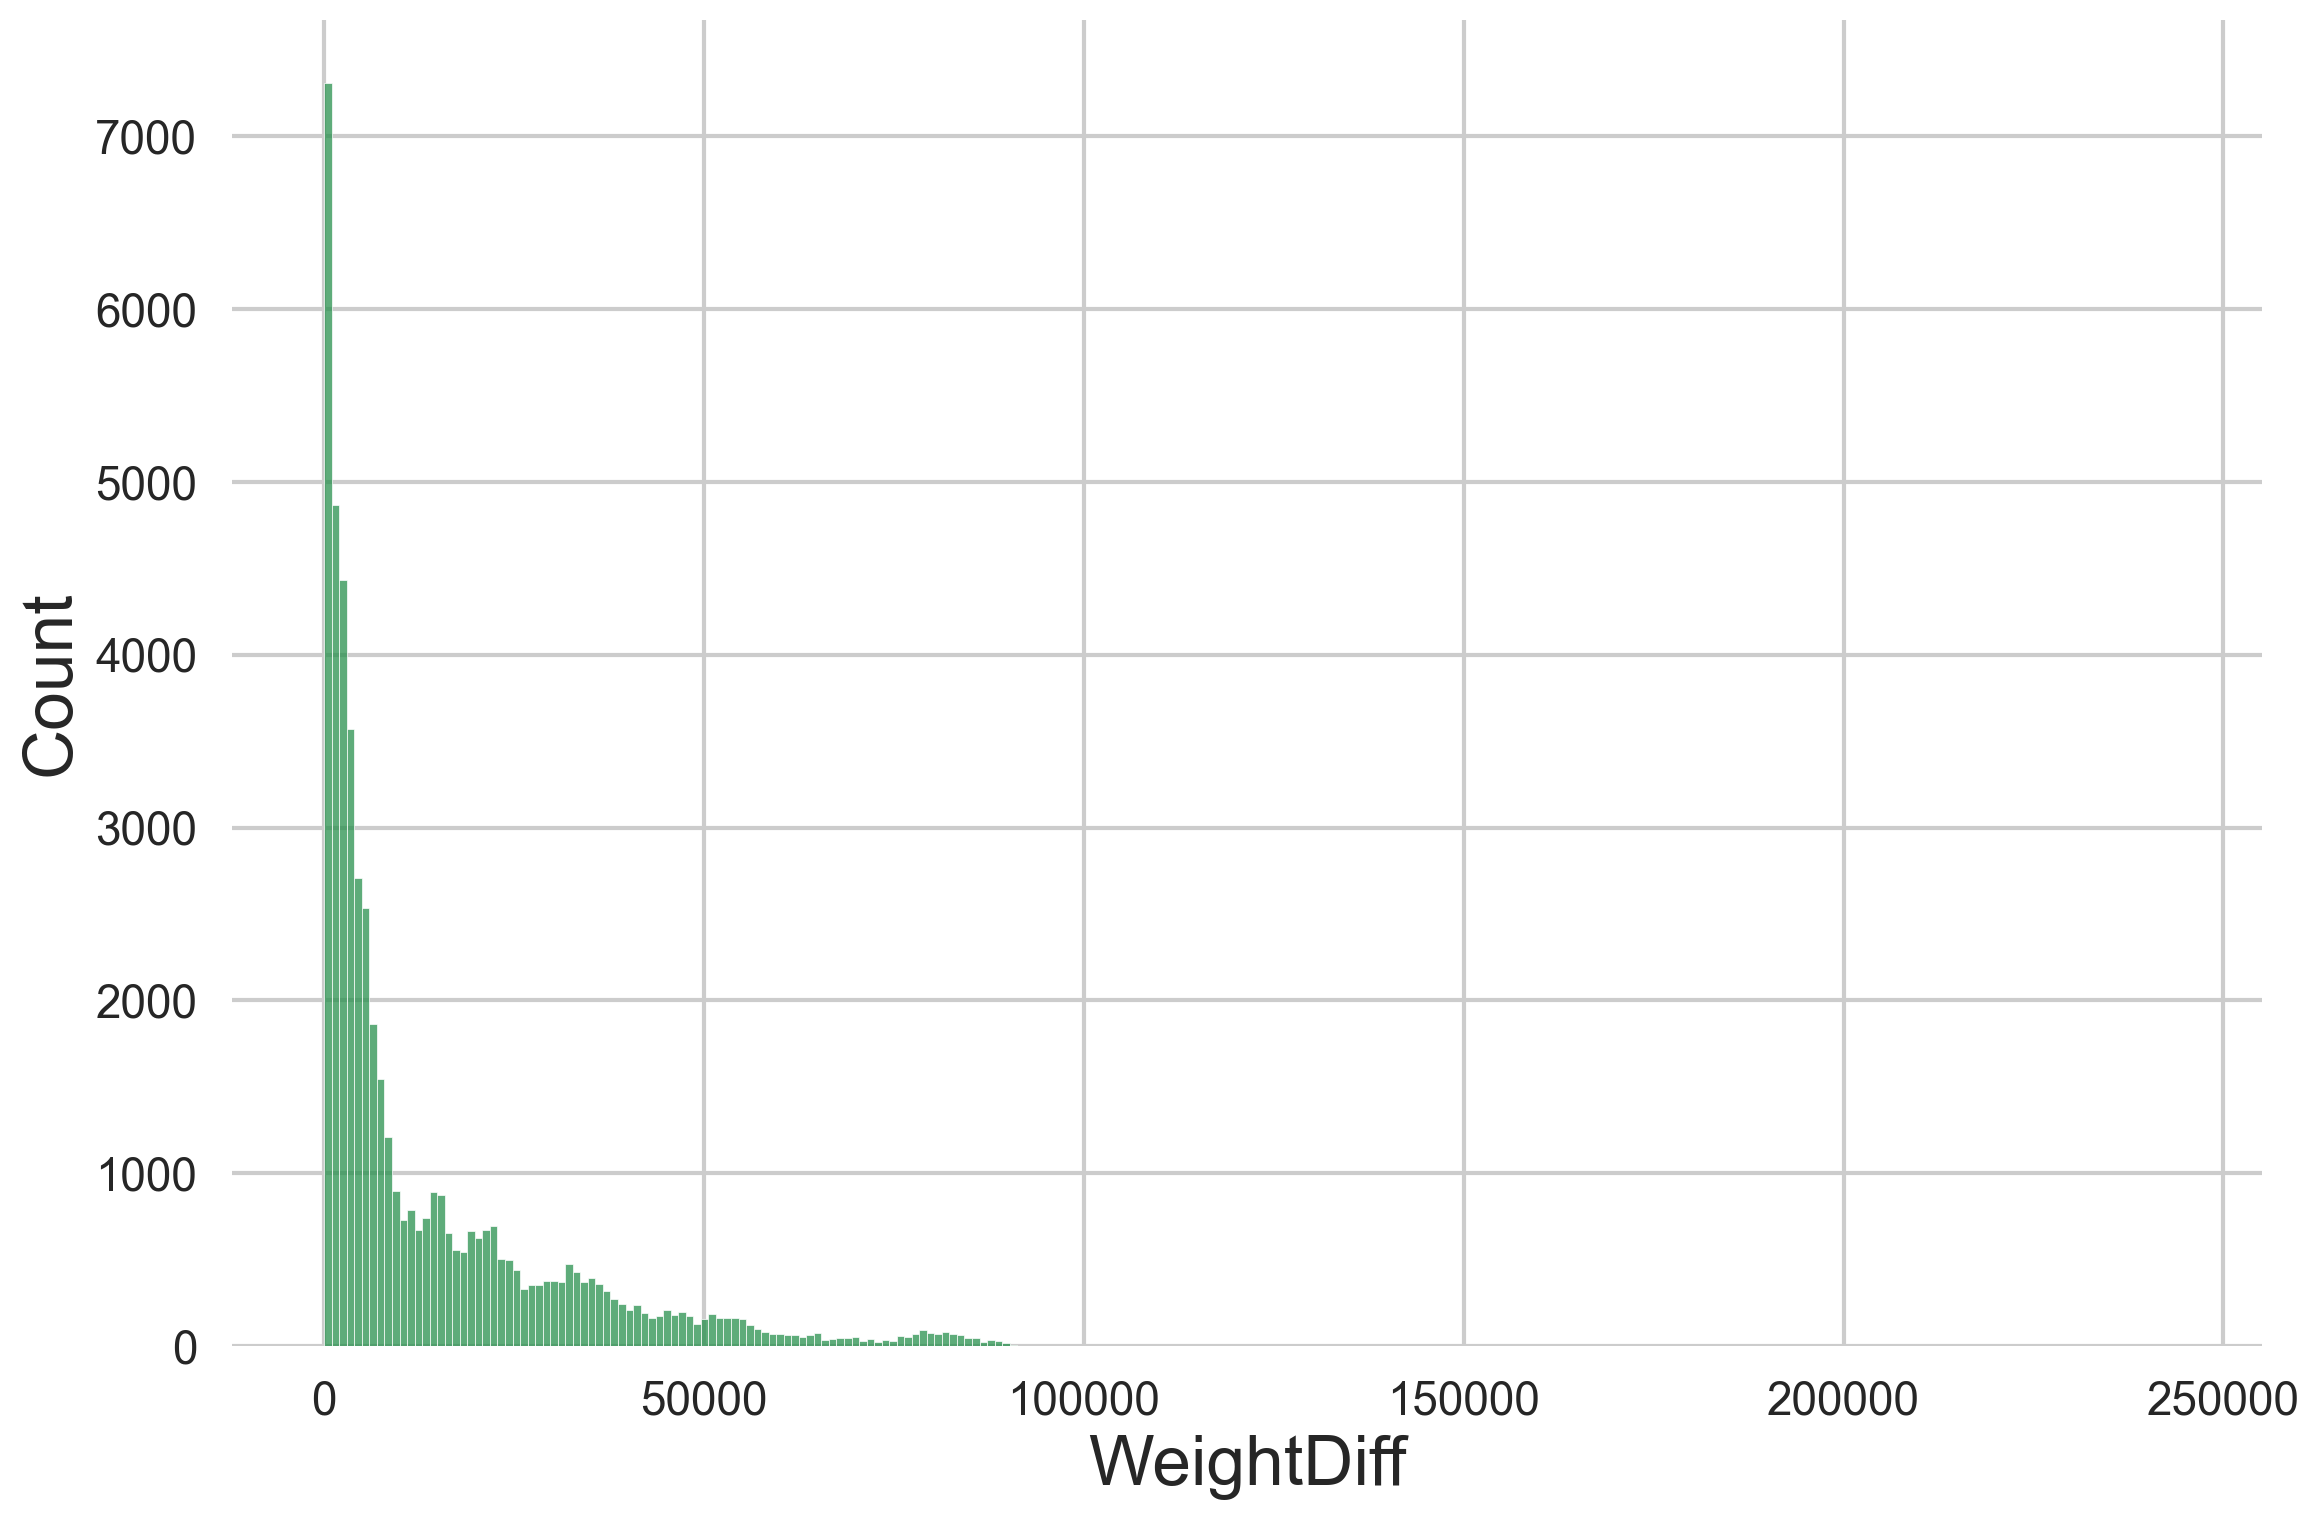

In [54]:
sns.histplot(dff, x="WeightDiff")

In [55]:
pivot = (
    df.pivot_table(
        index=["Date", "FarmName"],
        columns="IngredientType",
        values="Share",
        aggfunc="sum" 
    )
    .reset_index()
)
date_feeding = pivot.merge(df[["TotalWeight_kg_byFarm", "WeightDiff", "Date", "FarmName", "CowCount"]], on=["Date", "FarmName"]).drop_duplicates()
date_feeding["FoodPerHead"] = date_feeding["TotalWeight_kg_byFarm"] / date_feeding["CowCount"]
date_feeding

Date      FarmName  Concentrate    Forage  Medication  \
0      2022-01-01    ЖК Добрино     0.233954  0.647422         NaN   
4      2022-01-01    ЖК Коршево     0.261076  0.491918         NaN   
8      2022-01-02    ЖК Добрино     0.233882  0.649658         NaN   
12     2022-01-02    ЖК Коршево     0.254878  0.494606         NaN   
16     2022-01-03    ЖК Добрино     0.232219  0.656850         NaN   
...           ...           ...          ...       ...         ...   
205531 2025-10-22  МТФ Романово     0.046965  0.813442         NaN   
205535 2025-10-22   РМ Кольцово     1.000000       NaN         NaN   
205536 2025-10-22   РМ Пеньково     0.267839  0.724947         NaN   
205539 2025-10-22     РМ Поляна     0.174870  0.817826         NaN   
205542 2025-10-22   РМ Торопово     0.034983  0.956774         NaN   

        Premixture  VitaminMineral     Water  TotalWeight_kg_byFarm  \
0              NaN        0.017482  0.101142             241611.946   
4              NaN        0.002689  0.244316             153633.191   
8              NaN        0.017349  0.099111             259699.545   
12             NaN        0.002633  0.247883             146540.822   
16             NaN        0.015297  0.095634             258611.680   
...            ...             ...       ...                    ...   
205531         NaN        0.023285  0.116308              25338.002   
205535         NaN             NaN       NaN                647.000   
205536         NaN        0.007214       NaN             246169.884   
205539         NaN        0.007304       NaN              11500.000   
205542         NaN        0.008243       NaN              38219.054   

        WeightDiff  CowCount  FoodPerHead  
0         2923.946      9769    24.732516  
4         2998.191      5067    30.320346  
8          536.455     10129    25.639209  
12        2382.822      4484    32.680826  
16        1027.680     10146    25.489028  
...            ...       ...          ...  
205531    8349.998       784    32.318880  
205535       0.000       144     4.493056  
205536   16704.116     23779    10.352407  
205539      49.000       653    17.611026  
205542       0.946      4067     9.397358  

[51381 rows x 12 columns]

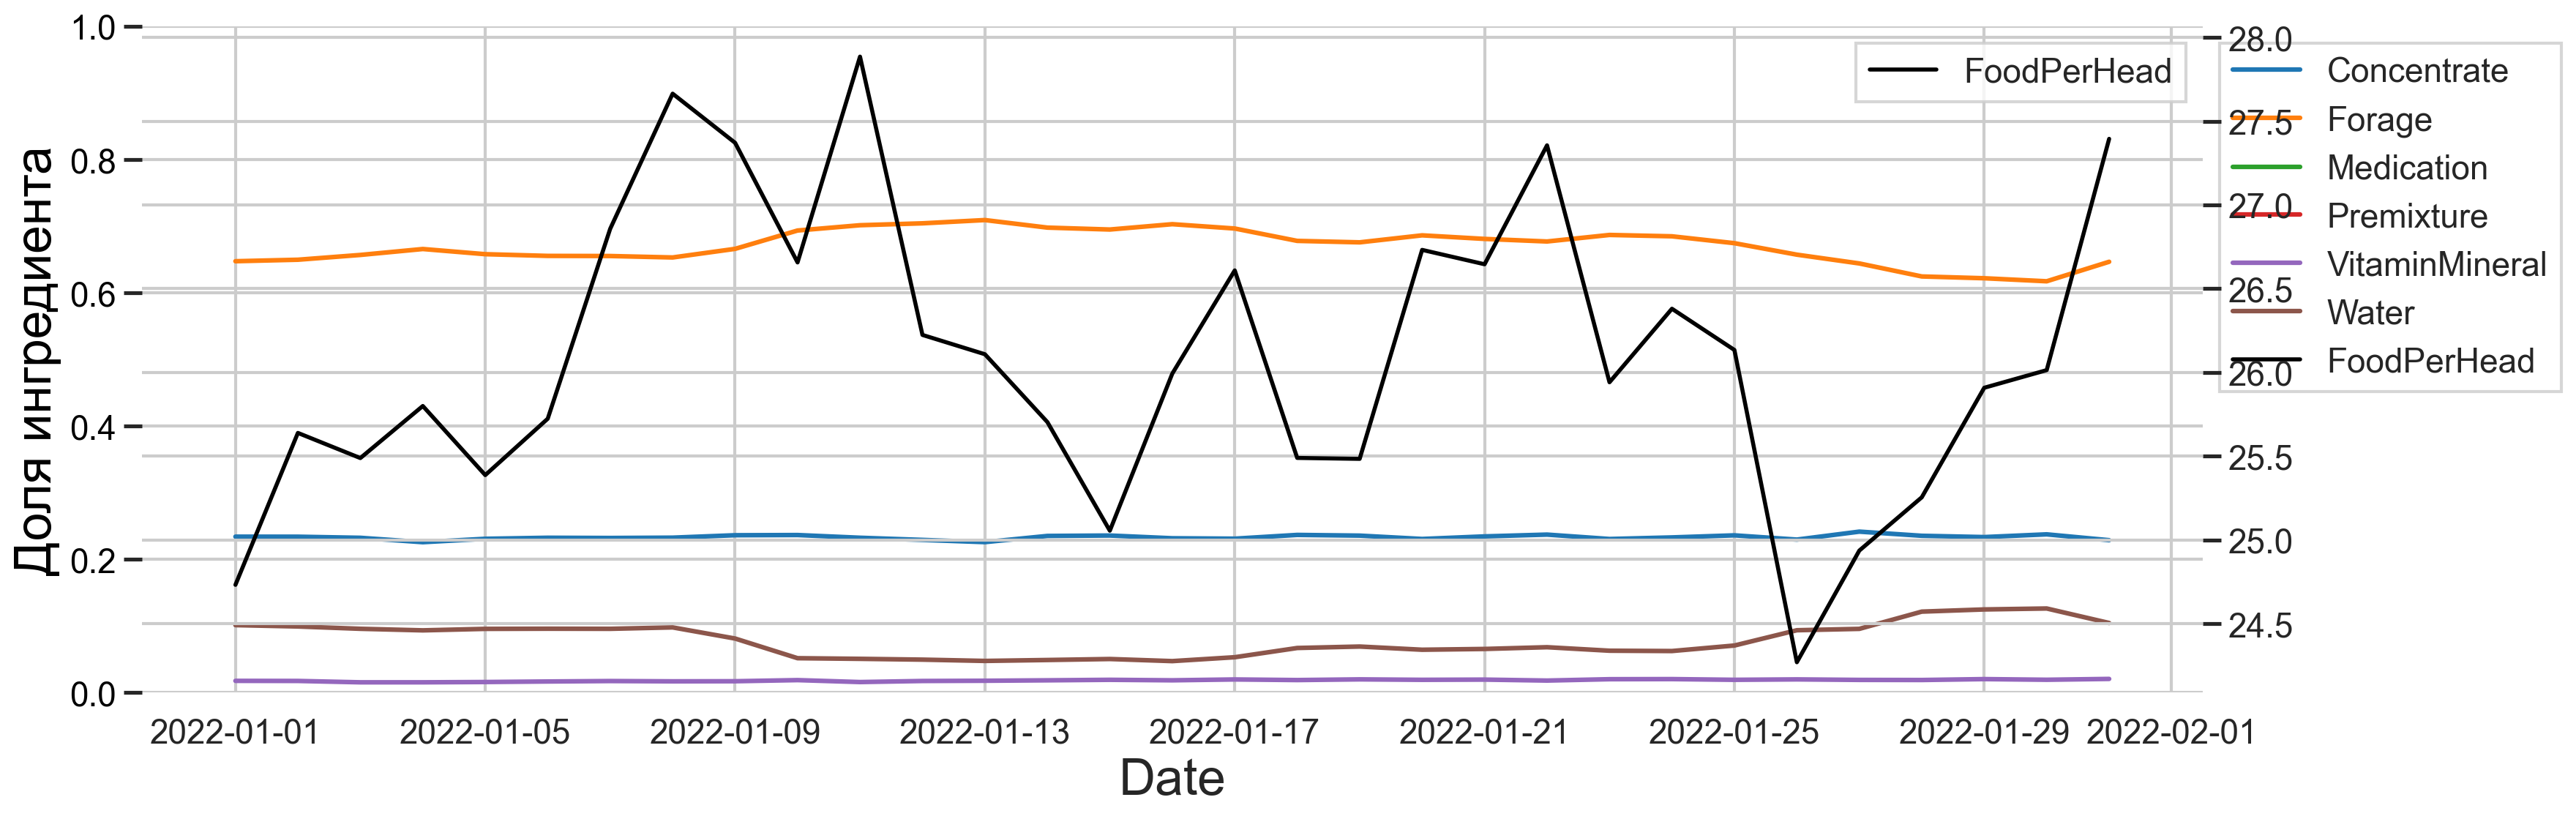

In [56]:
# Выбираем нужный диапазон
df = date_feeding[(date_feeding["FarmName"] == "ЖК Добрино") & 
                  (date_feeding["Date"] < pd.to_datetime("2022-02-01"))]

share_cols = ["Concentrate", "Forage", "Medication", "Premixture", "VitaminMineral", "Water"]

# Создаем "длинный" формат для sns.lineplot
df_melted = df.melt(id_vars=["Date"], value_vars=share_cols, 
                    var_name="Ingredient", value_name="Share")

fig, ax1 = plt.subplots(figsize=(18, 6))

# Линии долей ингредиентов
sns.lineplot(data=df_melted, x="Date", y="Share", hue="Ingredient", ax=ax1, palette="tab10")
ax1.set_ylabel("Доля ингредиента", color="black")
ax1.set_ylim(0,1)
ax1.tick_params(axis='y', labelcolor='black')

# Правая ось для общего веса
ax2 = ax1.twinx()
sns.lineplot(data=df, x="Date", y="FoodPerHead", ax=ax2, color="black", linewidth=2, label="FoodPerHead")
ax2.set_ylabel(None)

# Объединяем легенды
handles1, labels1 = ax1.get_legend_handles_labels()
handles2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(handles1 + handles2, labels1 + labels2, loc="upper left", bbox_to_anchor=(1,1))

plt.grid(True)
plt.show()


---

### Now will do some finding Lag on DATA 

### For this will analise Appetite with Shares

In [57]:
feeding_and_details

FeedingTaskID       Date  \
0         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
1         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
2         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
3         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
4         Farms/EkoNiva1C.216d4235-2852-11e8-80c4-1c98ec... 2022-01-01   
...                                                     ...        ...   
16411360  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411361  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411362  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411363  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   
16411364  Farms/EkoNiva1C.6c69fe1b-2b6f-11e8-80c4-1c98ec... 2025-10-22   

               FarmName  FeedNumber  SectionID  PhysiologicalGroupID  \
0            ЖК Добрино          15          9                     2   
1            ЖК Добрино          15          9                     2   
2            ЖК Добрино          15          9                     2   
3            ЖК Добрино          15          9                     2   
4            ЖК Добрино          15          9                     2   
...                 ...         ...        ...                   ...   
16411360  ЖК Подболотье          20        131                     1   
16411361  ЖК Подболотье          20        131                     1   
16411362  ЖК Подболотье          20        131                     1   
16411363  ЖК Подболотье          20        131                     1   
16411364  ЖК Подболотье          20        131                     1   

         PhysiologicalGroupName  PhysiologicalGroupHeadCount  Appetite  \
0                            Д1                          352       0.9   
1                            Д1                          352       0.9   
2                            Д1                          352       0.9   
3                            Д1                          352       0.9   
4                            Д1                          352       0.9   
...                         ...                          ...       ...   
16411360                 Нетели                           32       1.2   
16411361                 Нетели                           32       1.2   
16411362                 Нетели                           32       1.2   
16411363                 Нетели                           32       1.2   
16411364                 Нетели                           32       1.2   

         RationName  RationPart  TotalWeight_kg                  CompletedAt  \
0                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
1                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
2                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
3                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
4                Д1         0.5          8324.0  2022-01-03T05:45:50.5175580   
...             ...         ...             ...                          ...   
16411360         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411361         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411362         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411363         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   
16411364         С1         1.0          1106.0  2025-10-22T08:50:05.2368034   

          year  IngredientID          IngredientName  IngredientType  \
0         2022         125.0         Солома покупная          Forage   
1         2022         773.0      3645.01.01.01.1.20          Forage   
2         2022          72.0     Комбикорм 10 группы     Concentrate   
3         2022          82.0          Кукуруза сухая     Concentrate   
4         2022         129.0       Шрот подсолнечный     Concentrate   
...       

<Axes: xlabel='Date', ylabel='Appetite'>

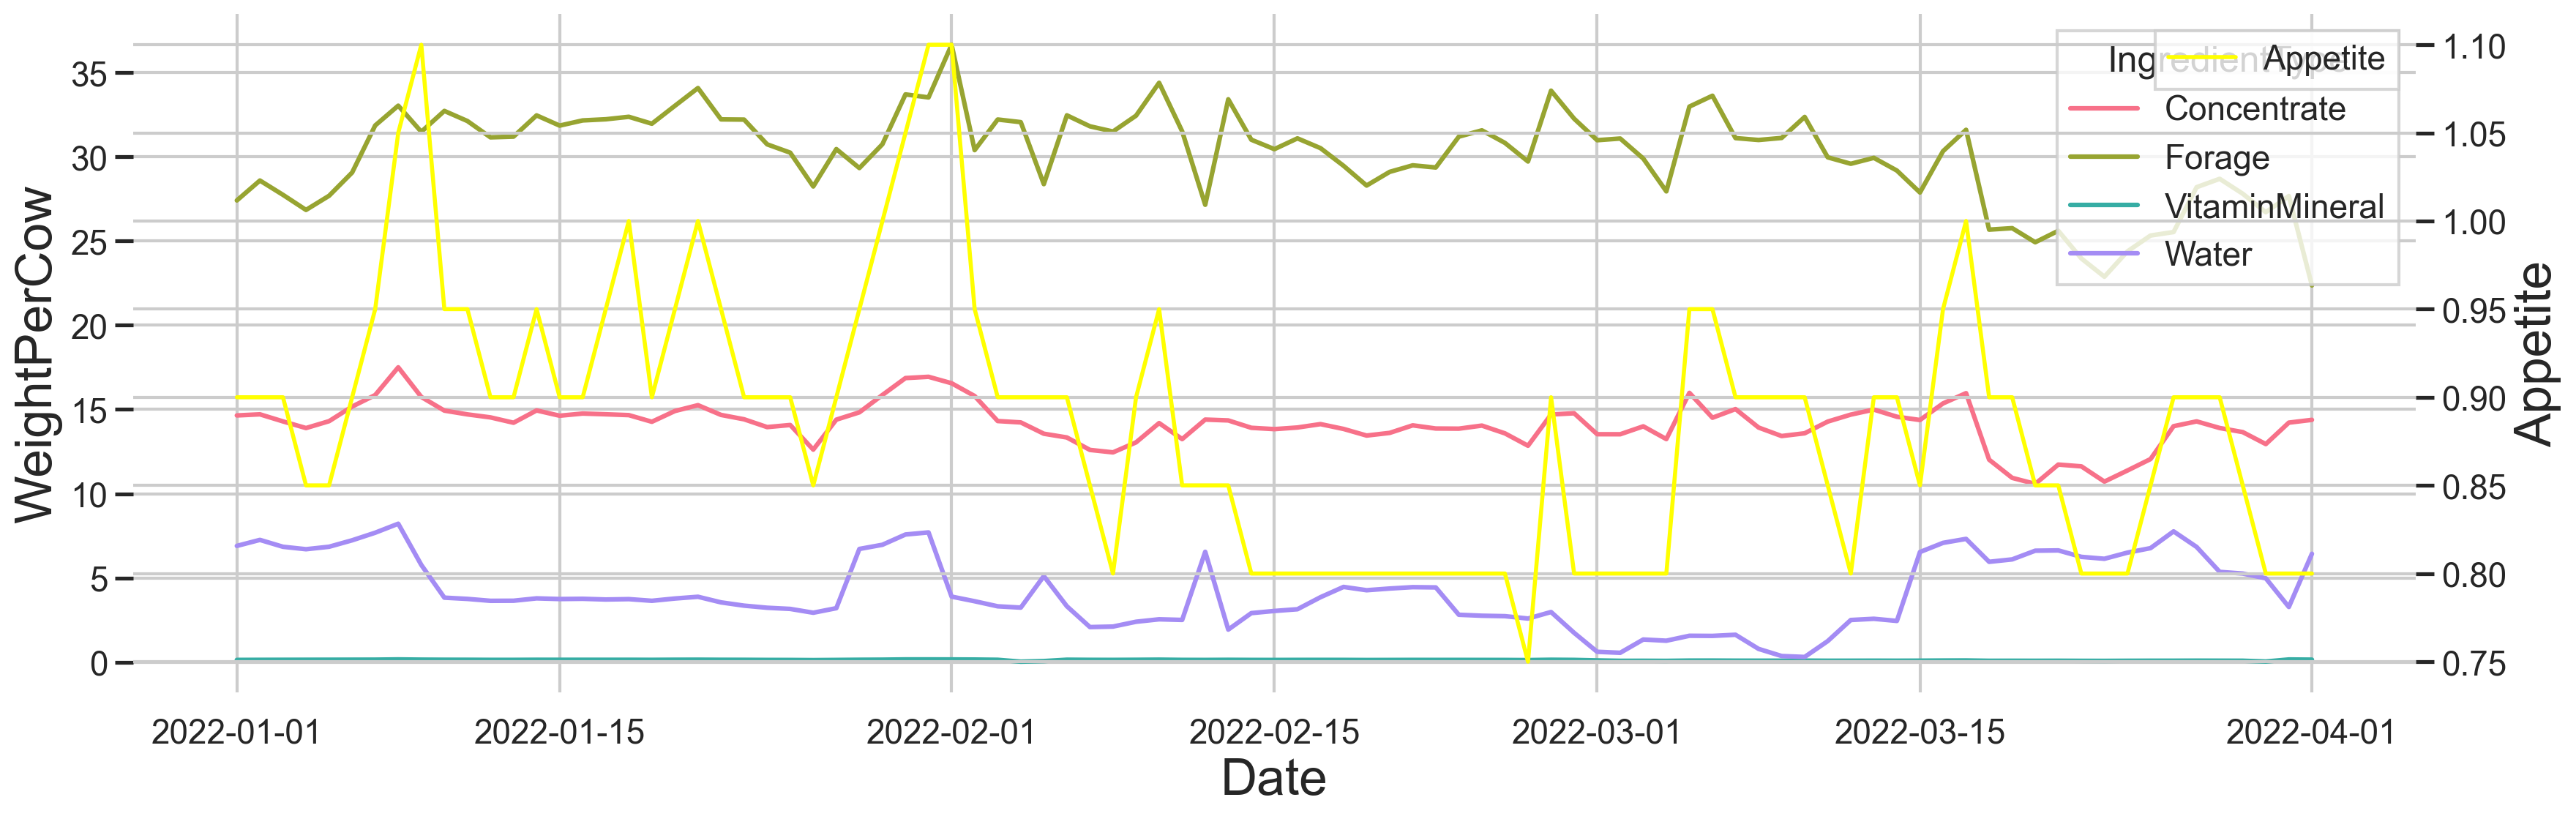

In [58]:
df = feeding_and_details.copy()

grouped = df.groupby(
    ["Date", "FarmName", "SectionID", "PhysiologicalGroupName", "IngredientType"]
)["PhysicalWeight_kg"].sum().reset_index()

planned = df[
    ["Date", "FarmName", "SectionID", "PhysiologicalGroupName", "Appetite", "PhysiologicalGroupHeadCount"]
].drop_duplicates()

appetites = planned.groupby(
    ["Date", "FarmName", "SectionID", "PhysiologicalGroupName"]
).agg({
    "Appetite": "mean",
    "PhysiologicalGroupHeadCount": "mean"
}).reset_index().rename(columns={"PhysiologicalGroupHeadCount": "CowCount"})

date_group_feeding = pd.merge(
    grouped,
    appetites,
    on=["Date", "FarmName", "SectionID", "PhysiologicalGroupName"],
    how="left"
)

date_group_feeding["WeightPerCow"] = date_group_feeding["PhysicalWeight_kg"] / date_group_feeding["CowCount"]

df_plot = date_group_feeding[(date_group_feeding["FarmName"] == "ЖК Добрино") & 
                 (date_group_feeding["SectionID"] == 1) & 
                 (date_group_feeding["PhysiologicalGroupName"] == "Д1") &
                 (date_group_feeding["Date"].between(pd.to_datetime("2022-01-01"), pd.to_datetime("2022-04-01")))]

fig, ax1 = plt.subplots(figsize=(18, 6))

sns.lineplot(df_plot, x="Date", y="WeightPerCow", hue="IngredientType", ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(df_plot.groupby("Date")["Appetite"].first().reset_index(), 
             x="Date", y="Appetite", ax=ax2, color="yellow", linewidth=2, label="Appetite")

In [59]:
df = feeding_and_details.copy()

grouped = df.groupby(
    ["Date", "FarmName", "PhysiologicalGroupName", "IngredientType"]
)["PhysicalWeight_kg"].sum().reset_index()

planned = df[
    ["Date", "FarmName", "PhysiologicalGroupName", "Appetite", "PhysiologicalGroupHeadCount"]
].drop_duplicates()

appetites = planned.groupby(
    ["Date", "FarmName", "PhysiologicalGroupName"]
).agg({
    "Appetite": "mean",
    "PhysiologicalGroupHeadCount": "sum"
}).reset_index().rename(columns={"PhysiologicalGroupHeadCount": "CowCount"})

date_phy_feeding = pd.merge(
    grouped,
    appetites,
    on=["Date", "FarmName", "PhysiologicalGroupName"],
    how="left"
)
date_phy_feeding["WeightPerCow"] = date_phy_feeding["PhysicalWeight_kg"] / date_phy_feeding["CowCount"]
date_phy_feeding

Date     FarmName PhysiologicalGroupName  IngredientType  \
0       2022-01-01   ЖК Добрино       Д0 (Новотельные)     Concentrate   
1       2022-01-01   ЖК Добрино       Д0 (Новотельные)          Forage   
2       2022-01-01   ЖК Добрино       Д0 (Новотельные)  VitaminMineral   
3       2022-01-01   ЖК Добрино       Д0 (Новотельные)           Water   
4       2022-01-01   ЖК Добрино                     Д1     Concentrate   
...            ...          ...                    ...             ...   
1390452 2025-10-22  РМ Торопово         Т3 (9-12 мес.)          Forage   
1390453 2025-10-22  РМ Торопово         Т3 (9-12 мес.)  VitaminMineral   
1390454 2025-10-22  РМ Торопово           Т4 (>1 года)     Concentrate   
1390455 2025-10-22  РМ Торопово           Т4 (>1 года)          Forage   
1390456 2025-10-22  РМ Торопово           Т4 (>1 года)  VitaminMineral   

         PhysicalWeight_kg  Appetite  CowCount  WeightPerCow  
0                 1827.086       1.0       136     13.434456  
1                 3675.000       1.0       136     27.022059  
2                   23.079       1.0       136      0.169699  
3                  551.000       1.0       136      4.051471  
4                41653.997       1.0      3439     12.112241  
...                    ...       ...       ...           ...  
1390452           2703.000       0.8       150     18.020000  
1390453             22.291       0.8       150      0.148607  
1390454            326.000       0.8       404      0.806931  
1390455           8491.000       0.8       404     21.017327  
1390456             75.866       0.8       404      0.187787  

[1390457 rows x 8 columns]

In [60]:
date_group_feeding[(date_group_feeding["FarmName"] == "ЖК Авангард") & 
                 (date_group_feeding["Date"].between(pd.to_datetime("2024-01-01"), pd.to_datetime("2024-04-01")))]

Date     FarmName  SectionID PhysiologicalGroupName  \
1855966 2024-01-01  ЖК Авангард          1       Д0 (Новотельные)   
1855967 2024-01-01  ЖК Авангард          1       Д0 (Новотельные)   
1855968 2024-01-01  ЖК Авангард          1       Д0 (Новотельные)   
1855969 2024-01-01  ЖК Авангард          1       Д0 (Новотельные)   
1855970 2024-01-01  ЖК Авангард          2                     Д1   
...            ...          ...        ...                    ...   
2191850 2024-04-01  ЖК Авангард         17        Д3 (Предзапуск)   
2191851 2024-04-01  ЖК Авангард         18          Б0 (0-2 мес.)   
2191852 2024-04-01  ЖК Авангард         18          Б0 (0-2 мес.)   
2191853 2024-04-01  ЖК Авангард         18          Т0 (0-2 мес.)   
2191854 2024-04-01  ЖК Авангард         18          Т0 (0-2 мес.)   

         IngredientType  PhysicalWeight_kg  Appetite  CowCount  WeightPerCow  
1855966     Concentrate            350.000       1.1      46.0      7.608696  
1855967          Forage           1195.000       1.1      46.0     25.978261  
1855968  VitaminMineral             44.979       1.1      46.0      0.977804  
1855969           Water            145.000       1.1      46.0      3.152174  
1855970     Concentrate           1814.092       1.1     151.0     12.013854  
...                 ...                ...       ...       ...           ...  
2191850          Forage           4070.000       1.2      74.0     55.000000  
2191851     Concentrate            131.719       0.8      19.0      6.932579  
2191852  VitaminMineral              1.708       0.8      19.0      0.089895  
2191853     Concentrate           1102.281       0.8     159.0      6.932585  
2191854  VitaminMineral             14.292       0.8     159.0      0.089887  

[6179 rows x 9 columns]

In [61]:
date_group_feeding["Month"] = date_group_feeding["Date"].dt.month
date_group_feeding["Year"] = date_group_feeding["Date"].dt.year
date_group_feeding["date"] = pd.to_datetime(
    date_group_feeding["Year"].astype(str) + "-" + 
    date_group_feeding["Month"].astype(str) + "-01"
)
date_group_feeding


Date     FarmName  SectionID PhysiologicalGroupName  \
0       2022-01-01   ЖК Добрино          1                     Д1   
1       2022-01-01   ЖК Добрино          1                     Д1   
2       2022-01-01   ЖК Добрино          1                     Д1   
3       2022-01-01   ЖК Добрино          1                     Д1   
4       2022-01-01   ЖК Добрино          2                     Д1   
...            ...          ...        ...                    ...   
4468465 2025-10-22  РМ Торопово          9                 Нетели   
4468466 2025-10-22  РМ Торопово          9                 Нетели   
4468467 2025-10-22  РМ Торопово         10         Т3 (9-12 мес.)   
4468468 2025-10-22  РМ Торопово         10         Т3 (9-12 мес.)   
4468469 2025-10-22  РМ Торопово         10         Т3 (9-12 мес.)   

         IngredientType  PhysicalWeight_kg  Appetite  CowCount  WeightPerCow  \
0           Concentrate           2900.049      0.90     198.0     14.646712   
1                Forage           5426.625      0.90     198.0     27.407197   
2        VitaminMineral             27.029      0.90     198.0      0.136510   
3                 Water           1366.976      0.90     198.0      6.903919   
4           Concentrate           4048.376      1.15     227.0     17.834256   
...                 ...                ...       ...       ...           ...   
4468465          Forage          14792.000      1.00     549.0     26.943534   
4468466  VitaminMineral            126.436      1.00     549.0      0.230302   
4468467     Concentrate             86.444      0.80      64.0      1.350688   
4468468          Forage           1128.786      0.80      64.0     17.637281   
4468469  VitaminMineral              9.309      0.80      64.0      0.145453   

         Month  Year       date  
0            1  2022 2022-01-01  
1            1  2022 2022-01-01  
2            1  2022 2022-01-01  
3            1  2022 2022-01-01  
4            1  2022 2022-01-01  
...        ...   ...        ...  
4468465     10  2025 2025-10-01  
4468466     10  2025 2025-10-01  
4468467     10  2025 2025-10-01  
4468468     10  2025 2025-10-01  
4468469     10  2025 2025-10-01  

[4468470 rows x 12 columns]